In [3]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, pipeline, preprocessing, linear_model
import scipy.stats as stats

import seaborn as sns
%matplotlib inline
%pylab inline
plt.rcParams['figure.dpi'] = 300
sns.set_style("darkgrid")

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [4]:
df = pd.read_pickle('../data/df_all.pkl')
df.head()

address  days_on_trulia  elementary_school_count  \
0   66 West 38th Street Manhattan NY               2                       42   
1  435 West 45th Street Manhattan NY               2                       42   
2   56 West 11th Street Manhattan NY              14                       42   
3   298 Mulberry Street Manhattan NY               2                       40   
4  71 West 107th Street Manhattan NY              14                       27   

   high_school_count  middle_school_count  pets_allowed  price  sqft  \
0                 12                   22             1   3795  None   
1                 11                   22             1   1950   500   
2                 16                   19             0   4550   768   
3                 13                   17             0   5350  None   
4                  6                   15             0   2475  None   

                                                 url  zip_code  \
0  https://www.trulia.com/p/ny/manhattan/66-w-38t...     10018   
1  https://www.trulia.com/p/ny/manhattan/435-w-45...     10036   
2  https://www.trulia.com/p/ny/manhattan/56-w-11t...     10011   
3  https://www.trulia.com/p/ny/manhattan/298-mulb...     10012   
4  https://www.trulia.com/p/ny/manhattan/71-w-107...     10025   

          ...          demo_pct_two_or_more_races  demo_pct_white  \
0         ...                            0.039550        0.591078   
1         ...                            0.020125        0.642167   
2         ...                            0.029680        0.794004   
3         ...                            0.038882        0.756643   
4         ...                            0.041946        0.659955   

   demo_pct_black_or_african_american  \
0                            0.054936   
1                            0.074845   
2                            0.045889   
3                            0.026125   
4                            0.121467   

   demo_pct_american_indian_and_alaska_native  demo_pct_asian  \
0                                    0.000000        0.293474   
1                                    0.004579        0.192712   
2                                    0.001270        0.101004   
3                                    0.001549        0.161355   
4                                    0.008341        0.091821   

   demo_pct_native_hawaiian_and_other_pacific_islander  \
0                                           0.000000     
1                                           0.000000     
2                                           0.000079     
3                                           0.000489     
4                                           0.000232     

   demo_pct_some_other_race  demo_pct_hispanic_or_latino_(of_any_race)  \
0                  0.020962                                   0.165118   
1                  0.065571                                   0.177435   
2                  0.028073                                   0.109456   
3                  0.014958                                   0.058730   
4                  0.076238                                   0.227076   

   rest_num  n_of_establishments  
0      2879                 6723  
1      1783                 6131  
2      2131                 4002  
3      2328                 2972  
4       418                 2027  

[5 rows x 78 columns]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6342 entries, 0 to 6341
Data columns (total 78 columns):
address                                                6342 non-null object
days_on_trulia                                         6342 non-null int64
elementary_school_count                                6342 non-null int64
high_school_count                                      6342 non-null int64
middle_school_count                                    6342 non-null int64
pets_allowed                                           6342 non-null int64
price                                                  6342 non-null int64
sqft                                                   2318 non-null object
url                                                    6342 non-null object
zip_code                                               6342 non-null int64
evac                                                   1604 non-null object
guarantor                                              6342 non-

In [91]:
# check for nulls
df.columns[df.isna().any()].tolist()

['sqft',
 'evac',
 'pct_high_income',
 'demo_total_population',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_under_5_years',
 'demo_pct_5_to_9_years',
 'demo_pct_10_to_14_years',
 'demo_pct_15_to_19_years',
 'demo_pct_20_to_24_years',
 'demo_pct_25_to_34_years',
 'demo_pct_35_to_44_years',
 'demo_pct_45_to_54_years',
 'demo_pct_55_to_59_years',
 'demo_pct_60_to_64_years',
 'demo_pct_65_to_74_years',
 'demo_pct_75_to_84_years',
 'demo_pct_85_years_and_over',
 'demo_pct_18_years_and_over',
 'demo_pct_21_years_and_over',
 'demo_pct_62_years_and_over',
 'demo_pct_65_years_and_over',
 'demo_pct_one_race',
 'demo_pct_two_or_more_races',
 'demo_pct_white',
 'demo_pct_black_or_african_american',
 'demo_pct_american_indian_and_alaska_native',
 'demo_pct_asian',
 'demo_pct_native_hawaiian_and_other_pacific_islander',
 'demo_pct_some_other_race',
 'demo_pct_hispanic_or_latino_(of_any_race)']

In [92]:
# check which zip codes have NULL values
df[pd.isnull(df.demo_total_population)]['zip_code'].unique()

array([11249])

In [93]:
# how many records contain this zip code
df[df['zip_code']==11249]['zip_code'].count()

70

In [94]:
# drop rows containing this zip code
df = df[df.zip_code != 11249].copy()

In [95]:
# check for nulls
df.evac.unique()

array([None, '2', '5', '4', '6', '1', '3', 'c'], dtype=object)

In [96]:
# fix feature name to feed to patsy
df.rename(columns={'flooring:_hardwood': 'flooring_hardwood'}, inplace=True)
df.rename(columns={'off-street_parking': 'off_street_parking'}, inplace=True)
df.rename(columns={'demo_pct_hispanic_or_latino_(of_any_race)': 'demo_pct_hispanic_or_latino'}, inplace=True)

In [97]:
df.loc[:, df.dtypes == object].head()

address  sqft  \
0   66 West 38th Street Manhattan NY  None   
1  435 West 45th Street Manhattan NY   500   
2   56 West 11th Street Manhattan NY   768   
3   298 Mulberry Street Manhattan NY  None   
4  71 West 107th Street Manhattan NY  None   

                                                 url  evac  
0  https://www.trulia.com/p/ny/manhattan/66-w-38t...  None  
1  https://www.trulia.com/p/ny/manhattan/435-w-45...  None  
2  https://www.trulia.com/p/ny/manhattan/56-w-11t...  None  
3  https://www.trulia.com/p/ny/manhattan/298-mulb...  None  
4  https://www.trulia.com/p/ny/manhattan/71-w-107...  None

In [98]:
# create a list of all columns not related to demo data
non_demo_cols = [col for col in df.columns if 'demo' not in col]

In [99]:
# create a list with non-numerical columns 
non_num = ['address','url','evac','zip_code']
non_demo_cols = list(set(non_demo_cols).difference(set(non_num)))

# create a list with demo columns
demo_cols = [col for col in df.columns if 'demo' in col]
print('Non-demo columns:', len(non_demo_cols))
print('Demo columns:    ', len(demo_cols))

Non-demo columns: 45
Demo columns:     29


In [100]:
# create of non-demo numerical and booleam column lists
non_demo_num = ['sqft','median_income','middle_school_count','elementary_school_count',
               'high_school_count', 'n_of_establishments', 'rest_num', 'days_on_trulia', 'price', 'pct_high_income']

# create a list of binary columns
non_demo_bool = list(set(non_demo_cols).difference(set(non_demo_num)))

# remove dep var from non_demo_num list
non_demo_num.remove('price')

# remove sqft for now since it countains NULL values
non_demo_num.remove('sqft')

In [101]:
# list of non-binary variables
non_demo_num

['median_income',
 'middle_school_count',
 'elementary_school_count',
 'high_school_count',
 'n_of_establishments',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [102]:
# list of binary variables corresponding to the characteristics of the apartement
non_demo_bool

['guarantor',
 'dishwasher',
 'elevator',
 'fireplace',
 'garden',
 'concierge',
 'terrace',
 'co_purchase',
 'furnished',
 'washing_machine',
 'air_conditioning',
 'storage',
 'balcony',
 'board_approval_required',
 'parents',
 'off_street_parking',
 'deck',
 'pied_a_terre',
 'pets_allowed',
 'fios_available',
 'dryer',
 'leed_registered',
 'garage',
 'live_in_super',
 'childrens_playroom',
 'courtyard',
 'valet_parking',
 'pets',
 'fitness_center',
 'sublets',
 'flooring_hardwood',
 'cable_tv_ready',
 'pool',
 'microwave_oven',
 'recreation_facilities']

In [103]:
# demo variabes from Census data
demo_cols

['demo_total_population',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_under_5_years',
 'demo_pct_5_to_9_years',
 'demo_pct_10_to_14_years',
 'demo_pct_15_to_19_years',
 'demo_pct_20_to_24_years',
 'demo_pct_25_to_34_years',
 'demo_pct_35_to_44_years',
 'demo_pct_45_to_54_years',
 'demo_pct_55_to_59_years',
 'demo_pct_60_to_64_years',
 'demo_pct_65_to_74_years',
 'demo_pct_75_to_84_years',
 'demo_pct_85_years_and_over',
 'demo_pct_18_years_and_over',
 'demo_pct_21_years_and_over',
 'demo_pct_62_years_and_over',
 'demo_pct_65_years_and_over',
 'demo_pct_one_race',
 'demo_pct_two_or_more_races',
 'demo_pct_white',
 'demo_pct_black_or_african_american',
 'demo_pct_american_indian_and_alaska_native',
 'demo_pct_asian',
 'demo_pct_native_hawaiian_and_other_pacific_islander',
 'demo_pct_some_other_race',
 'demo_pct_hispanic_or_latino']

In [104]:
# check dep var stats
df.price.describe()

count     6272.000000
mean      2720.768495
std       1542.082094
min        390.000000
25%       1799.000000
50%       2425.000000
75%       3286.500000
max      71850.000000
Name: price, dtype: float64

In [105]:
# see outliers on the high end
df[df.price>10000]

address  days_on_trulia  \
1059  160 Central Park South Manhattan NY              46   
1221           795 5th Avenue New York NY              62   
1355    15 Central Park West Manhattan NY              77   
1368    128 East 70th Street Manhattan NY              79   
1424     210 East 65th Street New York NY              90   
1537  160 Central Park South Manhattan NY             213   
1814        166 Perry Street Manhattan NY              30   
1927      7 East 20th Street Manhattan NY              50   
2026    1 Central Park South Manhattan NY             101   
2060     42 West 58th Street Manhattan NY             172   
2149          521 Park Avenue New York NY               0   
5838        2303 Bronx Park East Bronx NY              38   
6302    157 West 57th Street Manhattan NY              14   

      elementary_school_count  high_school_count  middle_school_count  \
1059                       34                  9                   20   
1221                       34                  9                   20   
1355                       30                 10                   21   
1368                       32                  9                   20   
1424                       33                  8                   20   
1537                       34                  9                   20   
1814                       45                 17                   19   
1927                       43                 14                   21   
2026                       35                 10                   20   
2060                       36                 10                   21   
2149                       38                  9                   21   
5838                       23                  3                   11   
6302                       40                 11                   22   

      pets_allowed  price   sqft  \
1059             0  12900    750   
1221             1  20000    975   
1355             1  11500  1,342   
1368             0  10500   None   
1424             1  11700    643   
1537             0  11300    791   
1814             1  10500  1,126   
1927             1  10900  2,400   
2026             1  12895   None   
2060             0  71850  1,500   
2149             1  17000  1,911   
5838             0  17000   None   
6302             0  11999  1,021   

                                                    url  zip_code  \
1059  https://www.trulia.com/p/ny/manhattan/160-cent...     10019   
1221  https://www.trulia.com/p/ny/new-york/795-5th-a...     10065   
1355  https://www.trulia.com/p/ny/manhattan/15-centr...     10023   
1368  https://www.trulia.com/p/ny/manhattan/128-e-70...     10021   
1424  https://www.trulia.com/p/ny/new-york/210-e-65t...     10065   
1537  https://www.trulia.com/p/ny/manhattan/160-cent...     10019   
1814  https://www.trulia.com/p/ny/manhattan/166-perr...     10014   
1927  https://www.trulia.com/p/ny/manhattan/7-e-20th...     10003   
2026  https://www.trulia.com/p/ny/manhattan/1-centra...     10019   
2060  https://www.trulia.com/p/ny/manhattan/42-w-58t...     10019   
2149  https://www.trulia.com/p/ny/new-york/521-park-...     10065   
5838  https://www.trulia.com/p/ny/bronx/2303-bronx-p...     10467   
6302  https://www.trulia.com/p/ny/manhattan/157-w-57...     10019   

             ...          demo_pct_two_or_more_races  demo_pct_white  \
1059         ...                            0.032907        0.697836   
1221         ...                            0.011733        0.871571   
1355         ...                            0.020993        0.820900   
1368         ...                            0.034931        0.826517   
1424         ...                            0.011733        0.871571   
1537         ...                            0.032907        0.697836   
1814         ...                            0.018847        0.889207   
1927         ...                            0.028432        0.775116   
2026         ...                    

In [106]:
# see outliers on the ;ow end
df[df.price<500]

address  days_on_trulia  elementary_school_count  \
3496  117 Avenue T Brooklyn NY              19                       56   

      high_school_count  middle_school_count  pets_allowed  price  sqft  \
3496                  6                   35             0    390  None   

                                                    url  zip_code  \
3496  https://www.trulia.com/rental/4045692209-117-A...     11223   

             ...          demo_pct_two_or_more_races  demo_pct_white  \
3496         ...                            0.019441        0.633375   

      demo_pct_black_or_african_american  \
3496                            0.041402   

      demo_pct_american_indian_and_alaska_native  demo_pct_asian  \
3496                                    0.004979        0.229437   

      demo_pct_native_hawaiian_and_other_pacific_islander  \
3496                                           0.002069     

      demo_pct_some_other_race  demo_pct_hispanic_or_latino  rest_num  \
3496                  0.069296                     0.134705       190   

      n_of_establishments  
3496                 2137  

[1 rows x 78 columns]

In [107]:
df[non_demo_num].describe()

median_income  middle_school_count  elementary_school_count  \
count    6272.000000          6272.000000               6272.00000   
mean    77900.886001            19.960938                 35.81824   
std     32224.488307             6.785896                 11.23259   
min     21553.000000             6.000000                 15.00000   
25%     51864.000000            15.000000                 26.00000   
50%     75362.000000            19.000000                 35.00000   
75%    108178.000000            23.000000                 42.00000   
max    250001.000000            41.000000                 64.00000   

       high_school_count  n_of_establishments      rest_num  days_on_trulia  \
count        6272.000000          6272.000000   6272.000000     6272.000000   
mean            8.689573          2308.647800    843.970823       27.099171   
std             4.436418          1656.241665   1118.292186       40.366769   
min             2.000000            74.000000      1.000000       -1.000000   
25%             5.000000          1079.000000    253.000000        6.000000   
50%             8.000000          1967.000000    452.000000       15.000000   
75%            12.000000          3015.000000   1180.250000       34.000000   
max            28.000000          7373.000000  11931.000000      889.000000   

       pct_high_income  
count      6272.000000  
mean         15.028189  
std          11.589212  
min           0.400000  
25%           4.200000  
50%          10.400000  
75%          24.900000  
max          59.900000

In [108]:
# check negative values in 'days on Trulia' 
df.loc[df.days_on_trulia < 0]

address  days_on_trulia  \
2072   323 East 75th Street Manhattan NY              -1   
2073    185 Bleecker Street Manhattan NY              -1   
2075    1657 Madison Avenue Manhattan NY              -1   
2076     75 East 3rd Street Manhattan NY              -1   
2077   330 East 38th Street Manhattan NY              -1   
2078   346 West 36th Street Manhattan NY              -1   
2079  92 Morningside Avenue Manhattan NY              -1   
2081   328 East 15th Street Manhattan NY              -1   
2082       377 Rector Place Manhattan NY              -1   

      elementary_school_count  high_school_count  middle_school_count  \
2072                       30                  7                   19   
2073                       42                 14                   19   
2075                       27                  6                   16   
2076                       40                 13                   17   
2077                       40                 14                   21   
2078                       42                 12                   22   
2079                       25                  4                   13   
2081                       42                 16                   20   
2082                       39                 14                   19   

      pets_allowed  price  sqft  \
2072             0   4750  None   
2073             0   3200  None   
2075             0   1800  None   
2076             0   2750  None   
2077             1   3800   763   
2078             1   2000   600   
2079             0   3256  None   
2081             1   2400   700   
2082             1   3050   654   

                                                    url  zip_code  \
2072  https://www.trulia.com/p/ny/manhattan/323-e-75...     10021   
2073  https://www.trulia.com/p/ny/manhattan/185-blee...     10012   
2075  https://www.trulia.com/p/ny/manhattan/1657-mad...     10029   
2076  https://www.trulia.com/p/ny/manhattan/75-e-3rd...     10003   
2077  https://www.trulia.com/p/ny/manhattan/330-e-38...     10016   
2078  https://www.trulia.com/p/ny/manhattan/346-w-36...     10018   
2079  https://www.trulia.com/p/ny/manhattan/92-morni...     10027   
2081  https://www.trulia.com/p/ny/manhattan/328-e-15...     10003   
2082  https://www.trulia.com/p/ny/manhattan/377-rect...     10280   

             ...          demo_pct_two_or_more_races  demo_pct_white  \
2072         ...                            0.034931        0.826517   
2073         ...                            0.038882        0.756643   
2075         ...                            0.026218        0.346891   
2076         ...                            0.028432        0.775116   
2077         ...                            0.038260        0.726072   
2078         ...                            0.039550        0.591078   
2079         ...                            0.036385        0.299969   
2081         ...                            0.028432        0.775116   
2082         ...                            0.028949        0.770340   

      demo_pct_black_or_african_american  \
2072                            0.012726   
2073                            0.026125   
2075                            0.289418   
2076                            0.043916   
2077                            0.030469   
2078                            0.054936   
2079                            0.414005   
2081                            0.043916   
2082                            0.015846   

      demo_pct_american_indian_and_alaska_native  demo_pct_asian  \
2072                                    0.006982        0.094563   
2073                                    0.001549        0.161355   
2075                                    0.002330        0.087041   
2076                                    0.001850        0.129441   
2077                                    0.001348        0.195702   
2078                                    0.000000        0.293474   
2079                 

In [109]:
# after checking on site, it looks like -1 value was meant to be 1
# change 1 day and 0 days to 1 to be able to put a log on it
df.loc[df.days_on_trulia < 1, 'days_on_trulia'] = 1

# Visualization

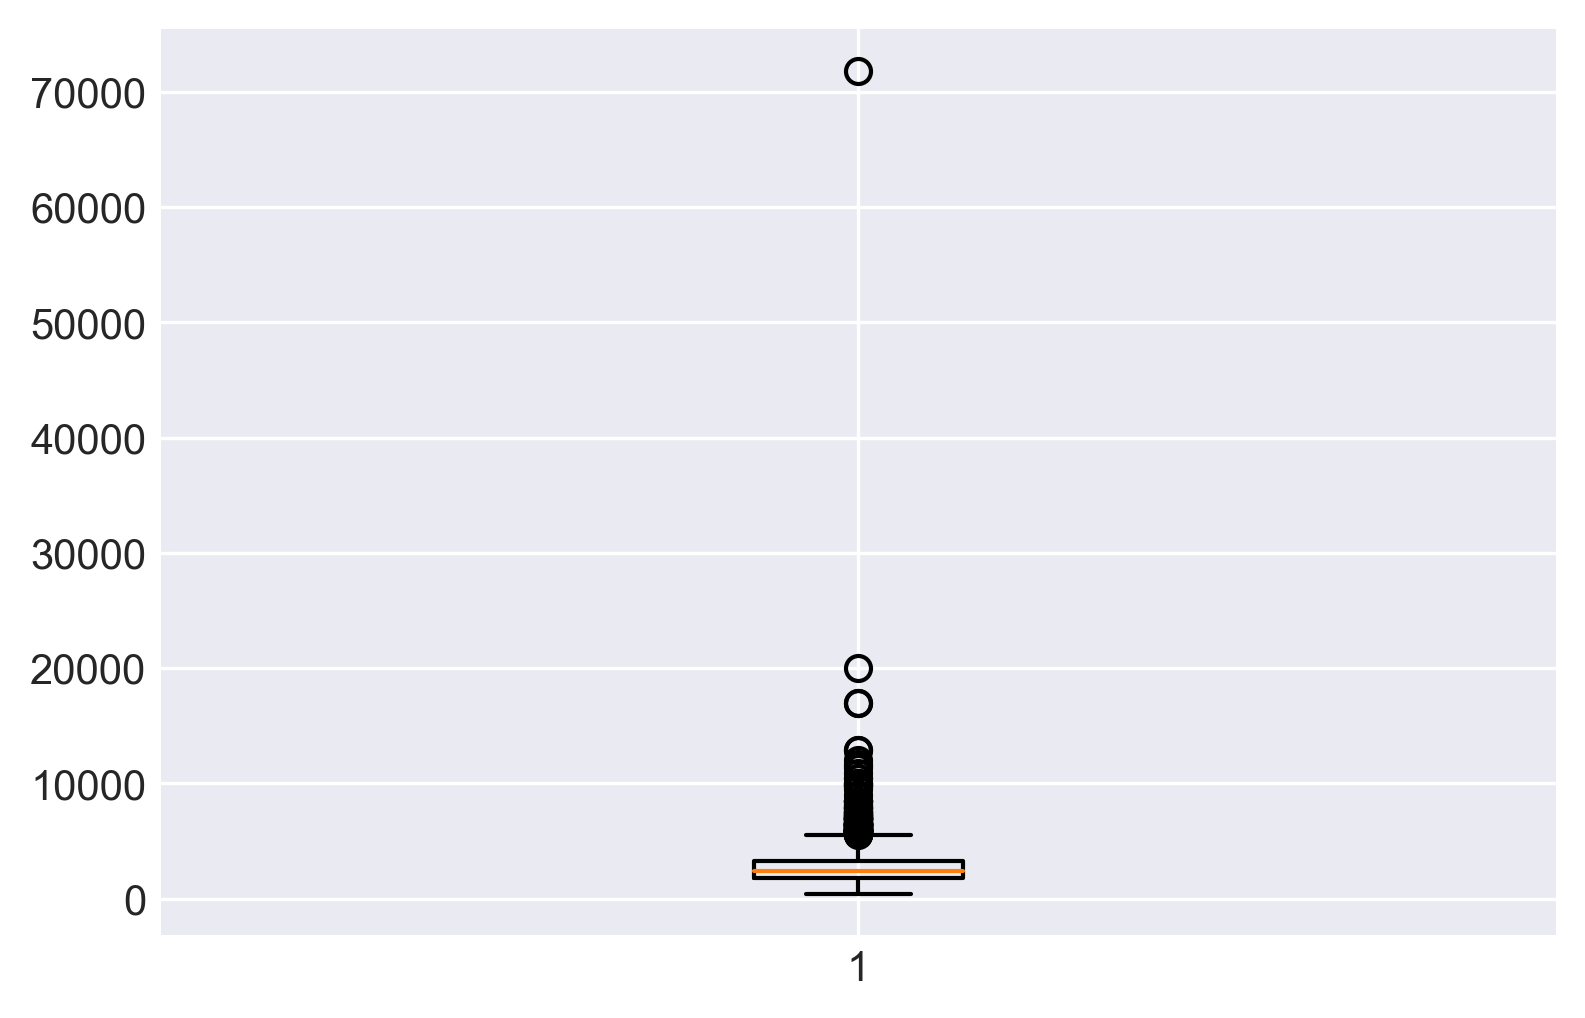

In [110]:
# dep variable distribution
plt.boxplot(df.price);

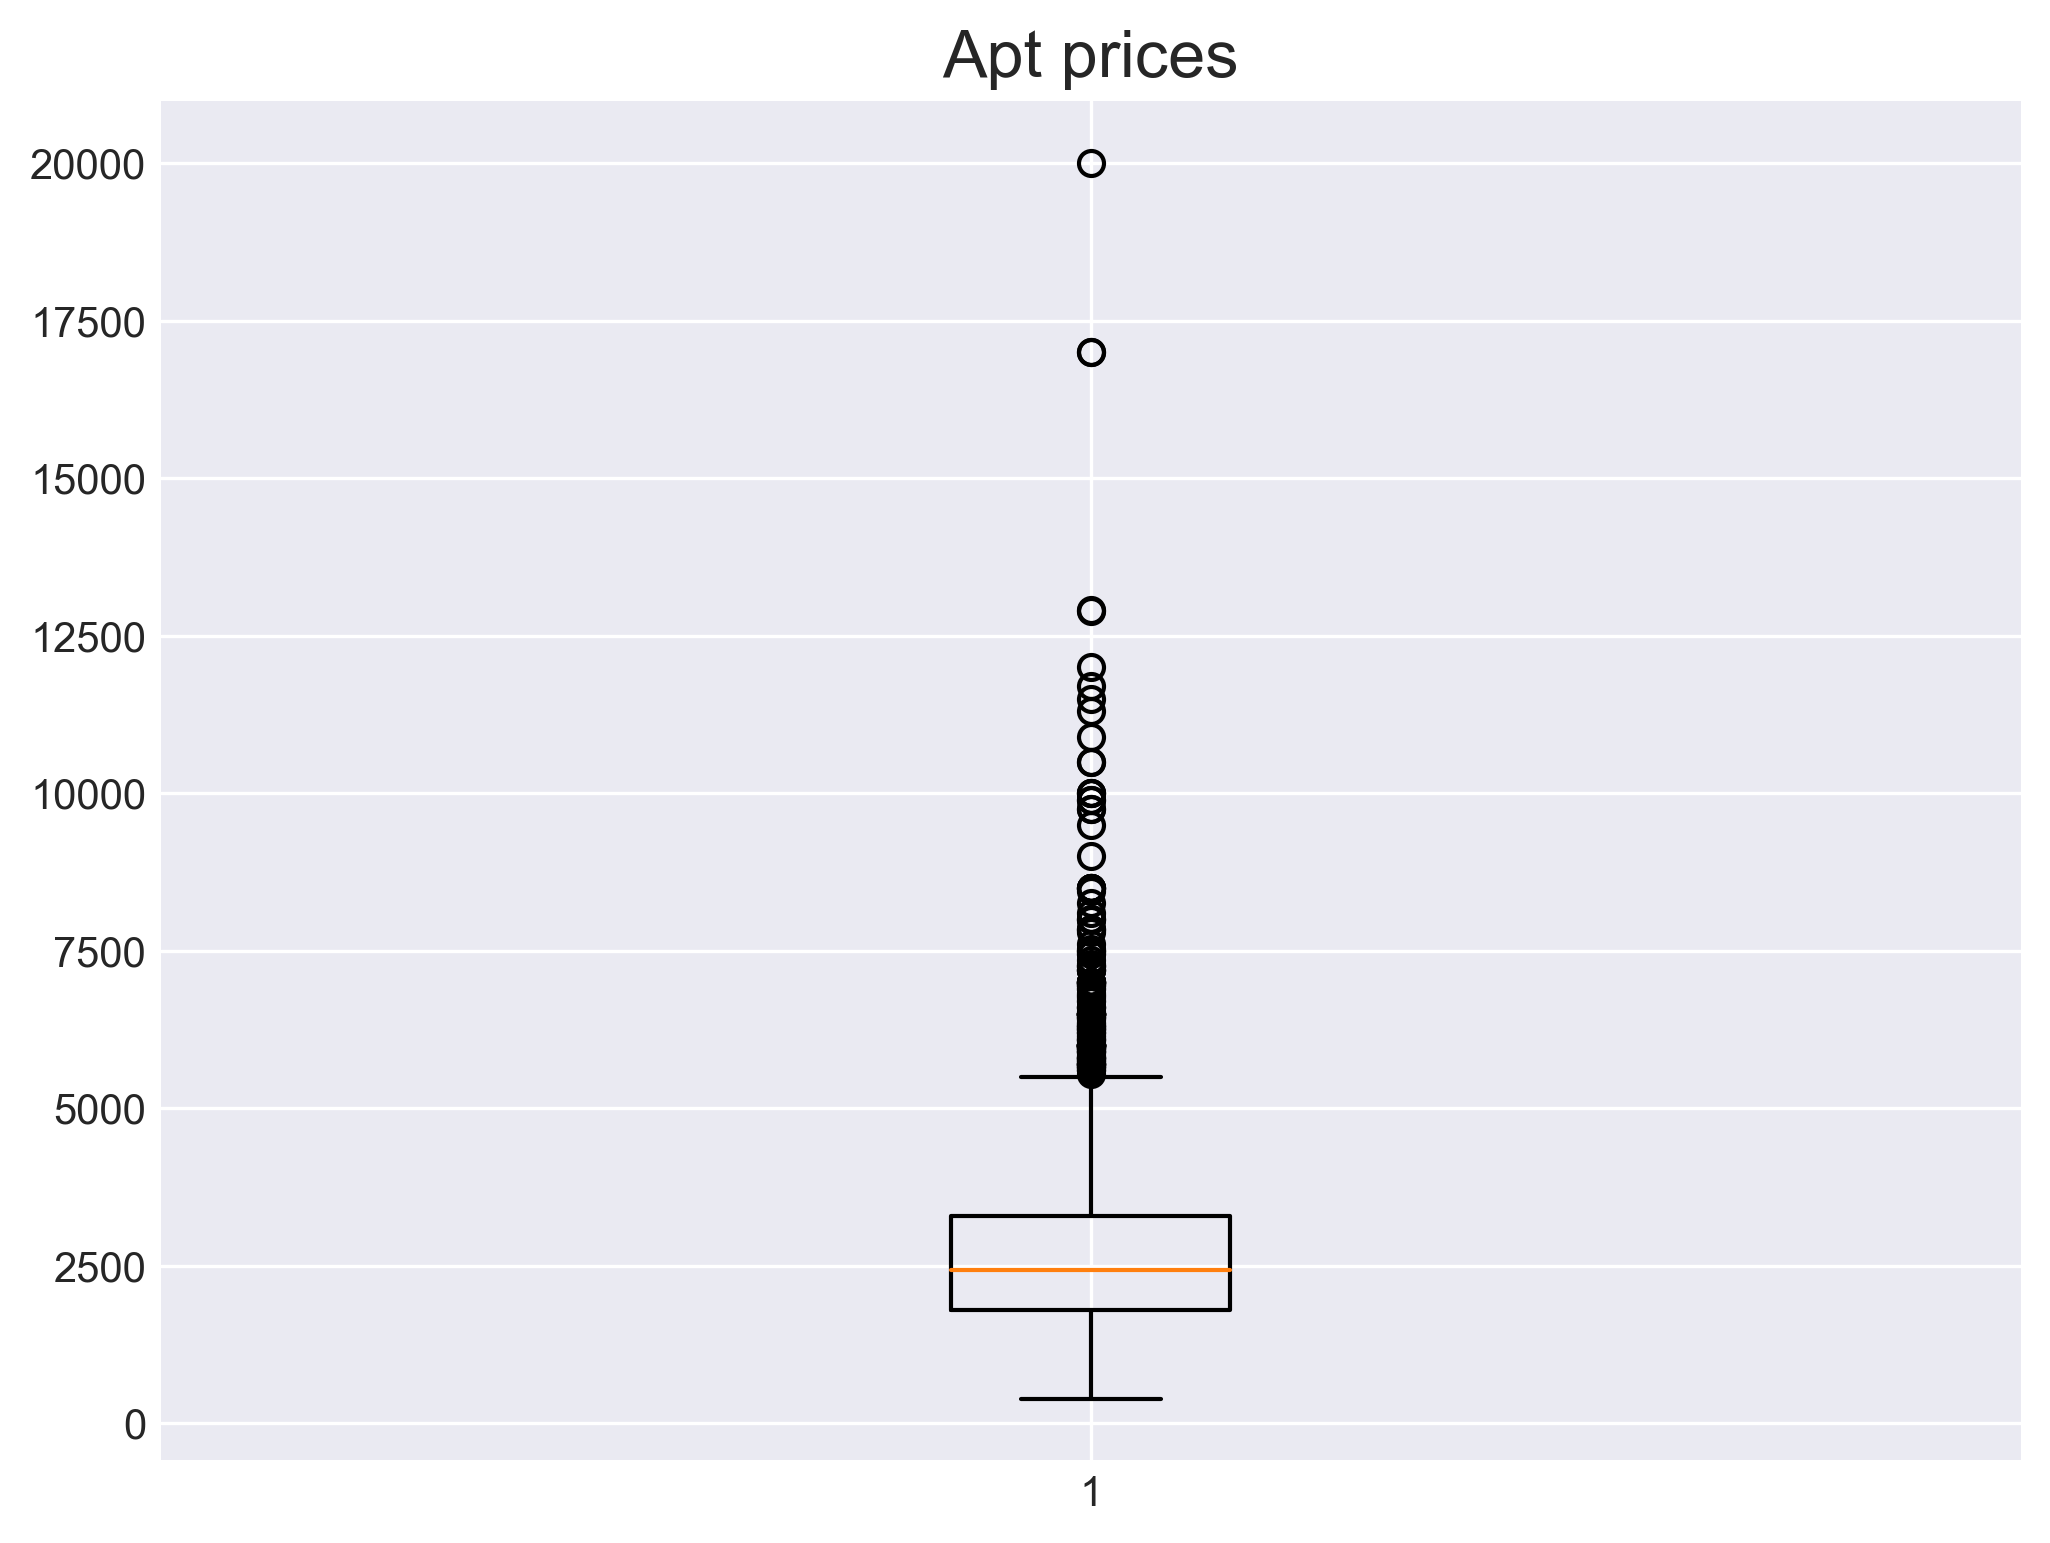

In [111]:
# remove the outlier and plot
df = df[df.price<70000].copy()
# dep variable distribution
figsize(8,6)
plt.boxplot(df.price)
plt.title('Apt prices', size=16);

Text(0.5,1,'Monthly 1br Rent Price')

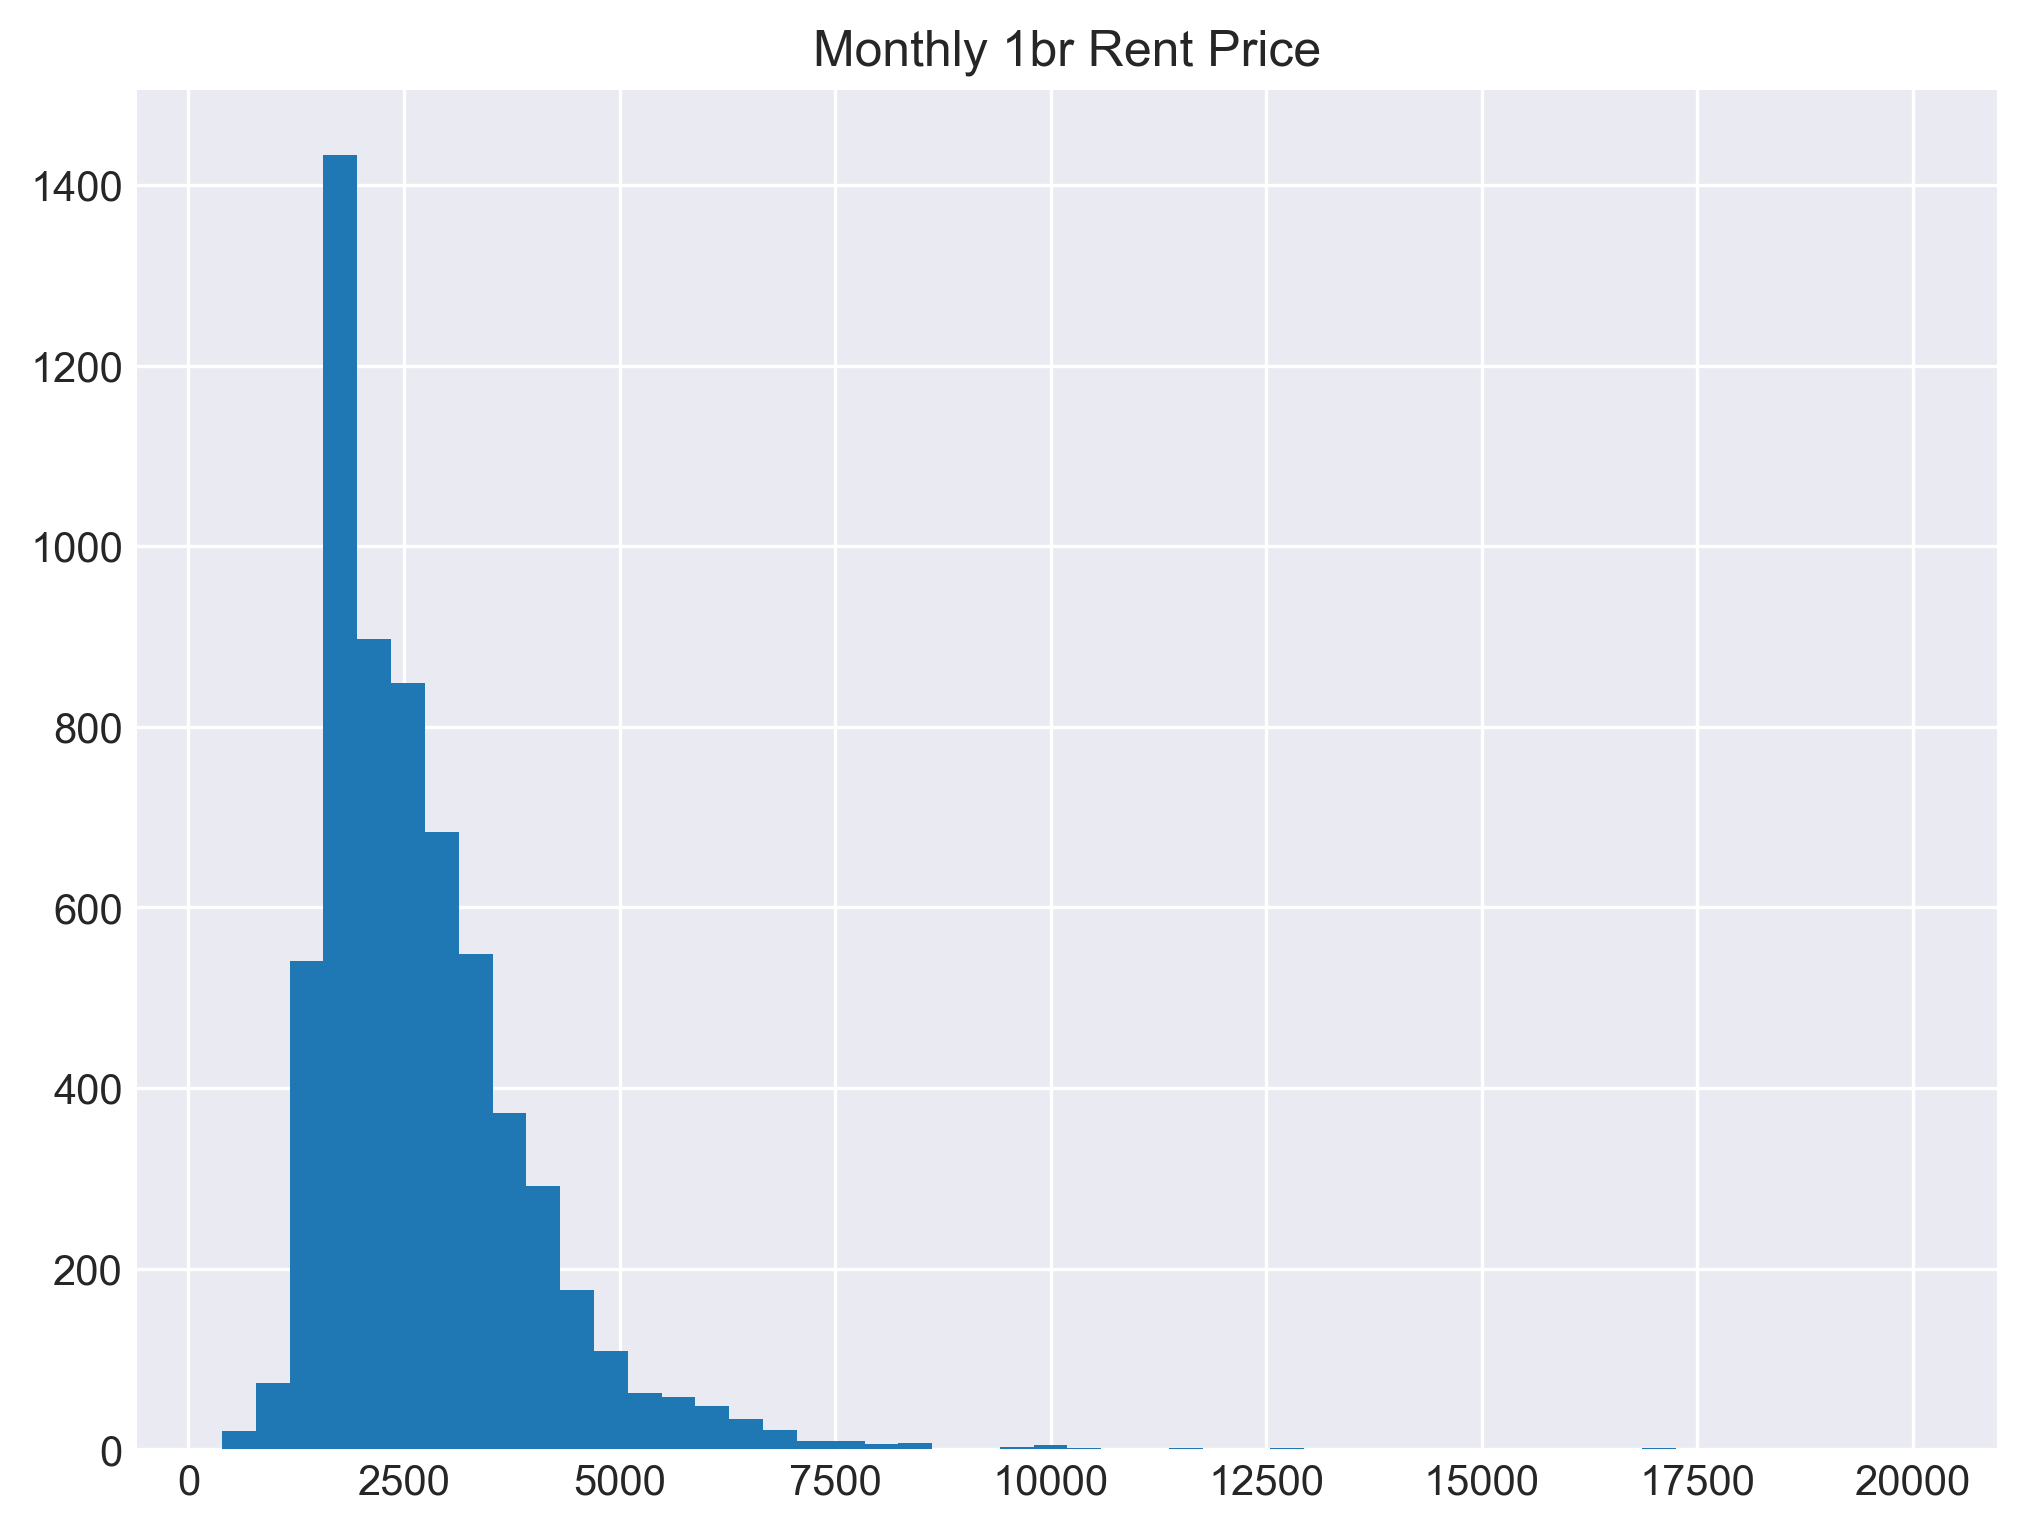

In [112]:
plt.hist(df.price, bins = 50);
plt.title('Monthly 1br Rent Price')

Text(0,0.5,'log scale')

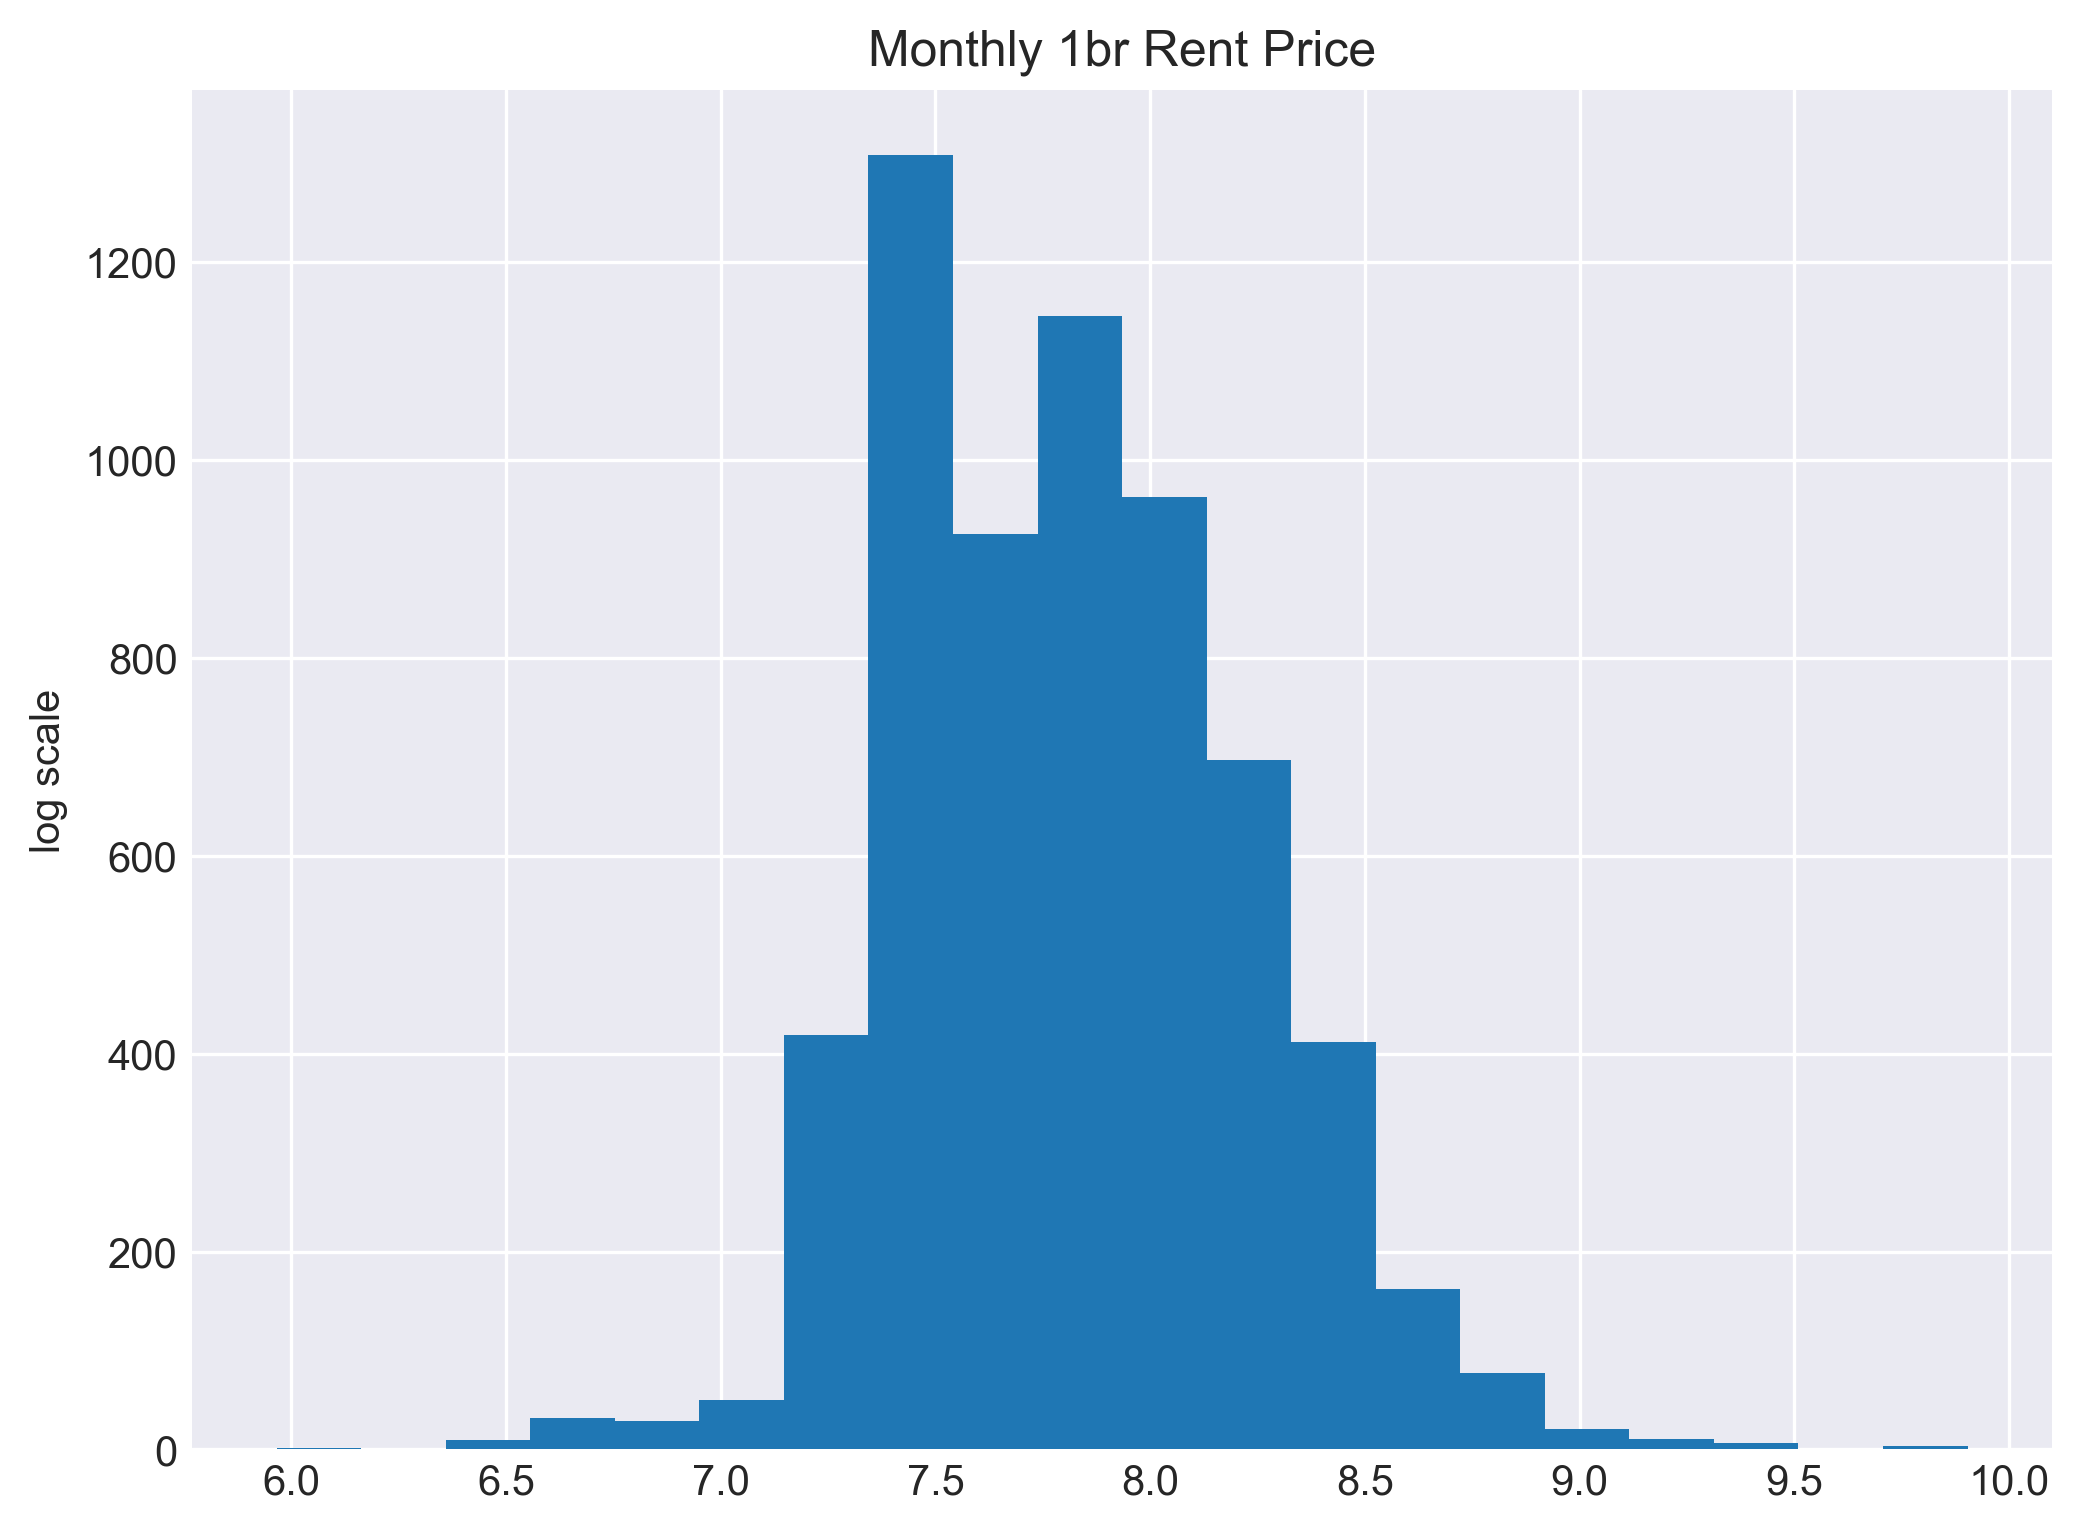

In [113]:
# the data is right-skewed: create a dep var column on a log scale & plot
# df['price_log'] = np.log(df.price)
plt.hist(np.log(df.price), bins = 20);
plt.title('Monthly 1br Rent Price')
plt.ylabel('log scale')

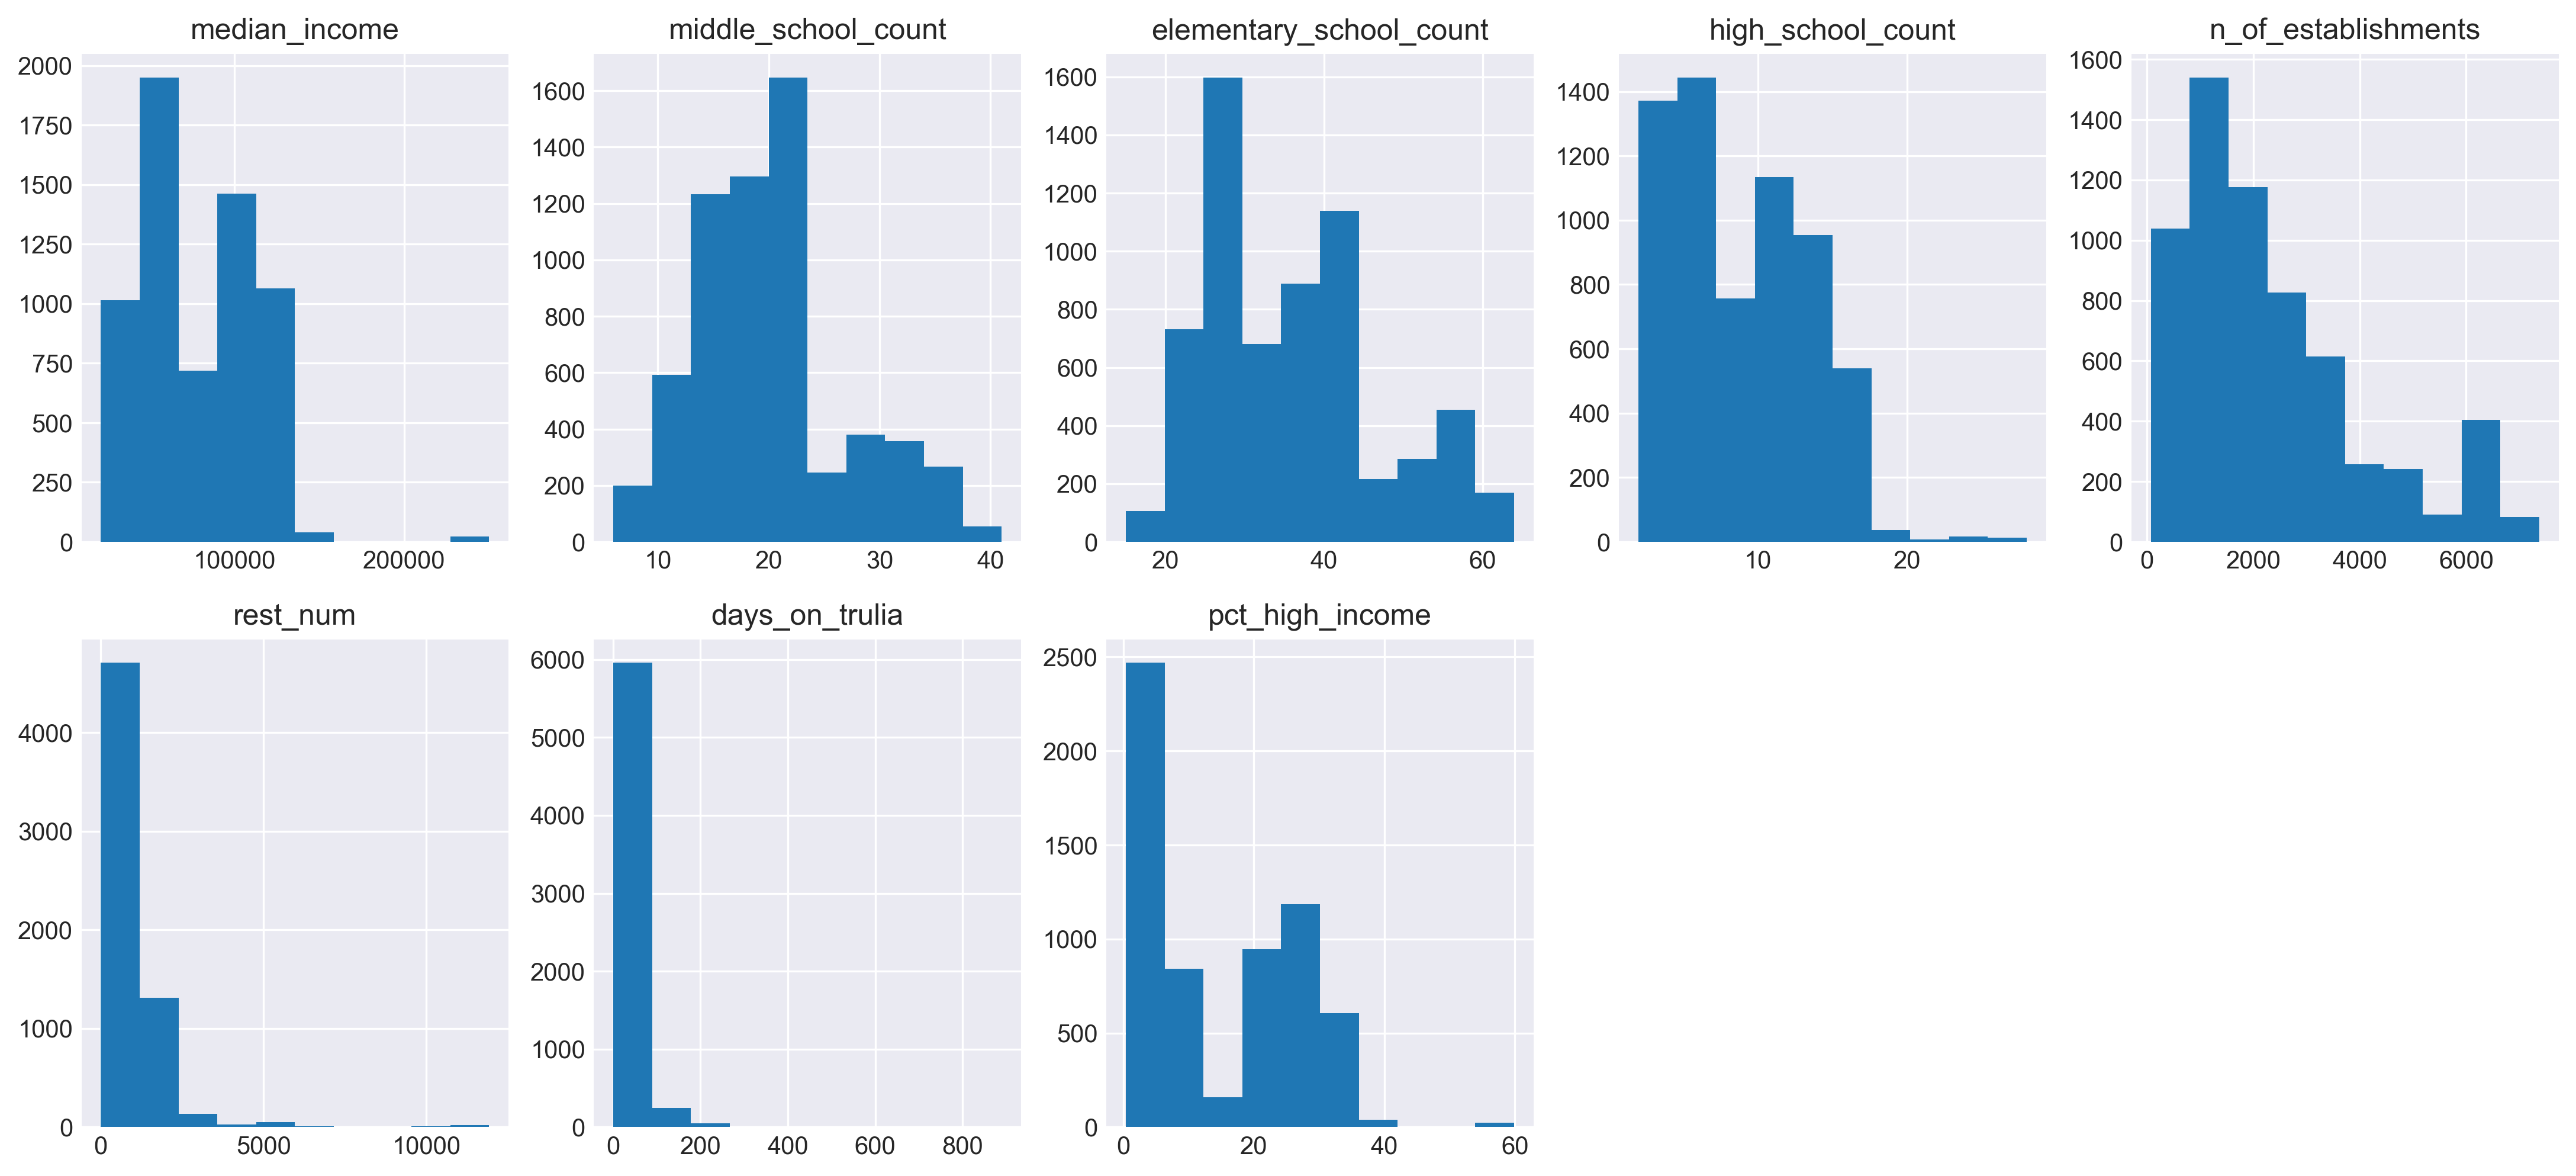

In [114]:
# plot distributions of non-binary variables
plt.figure(figsize=(18, 8))

for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.hist(df[var])
    plt.title(var);

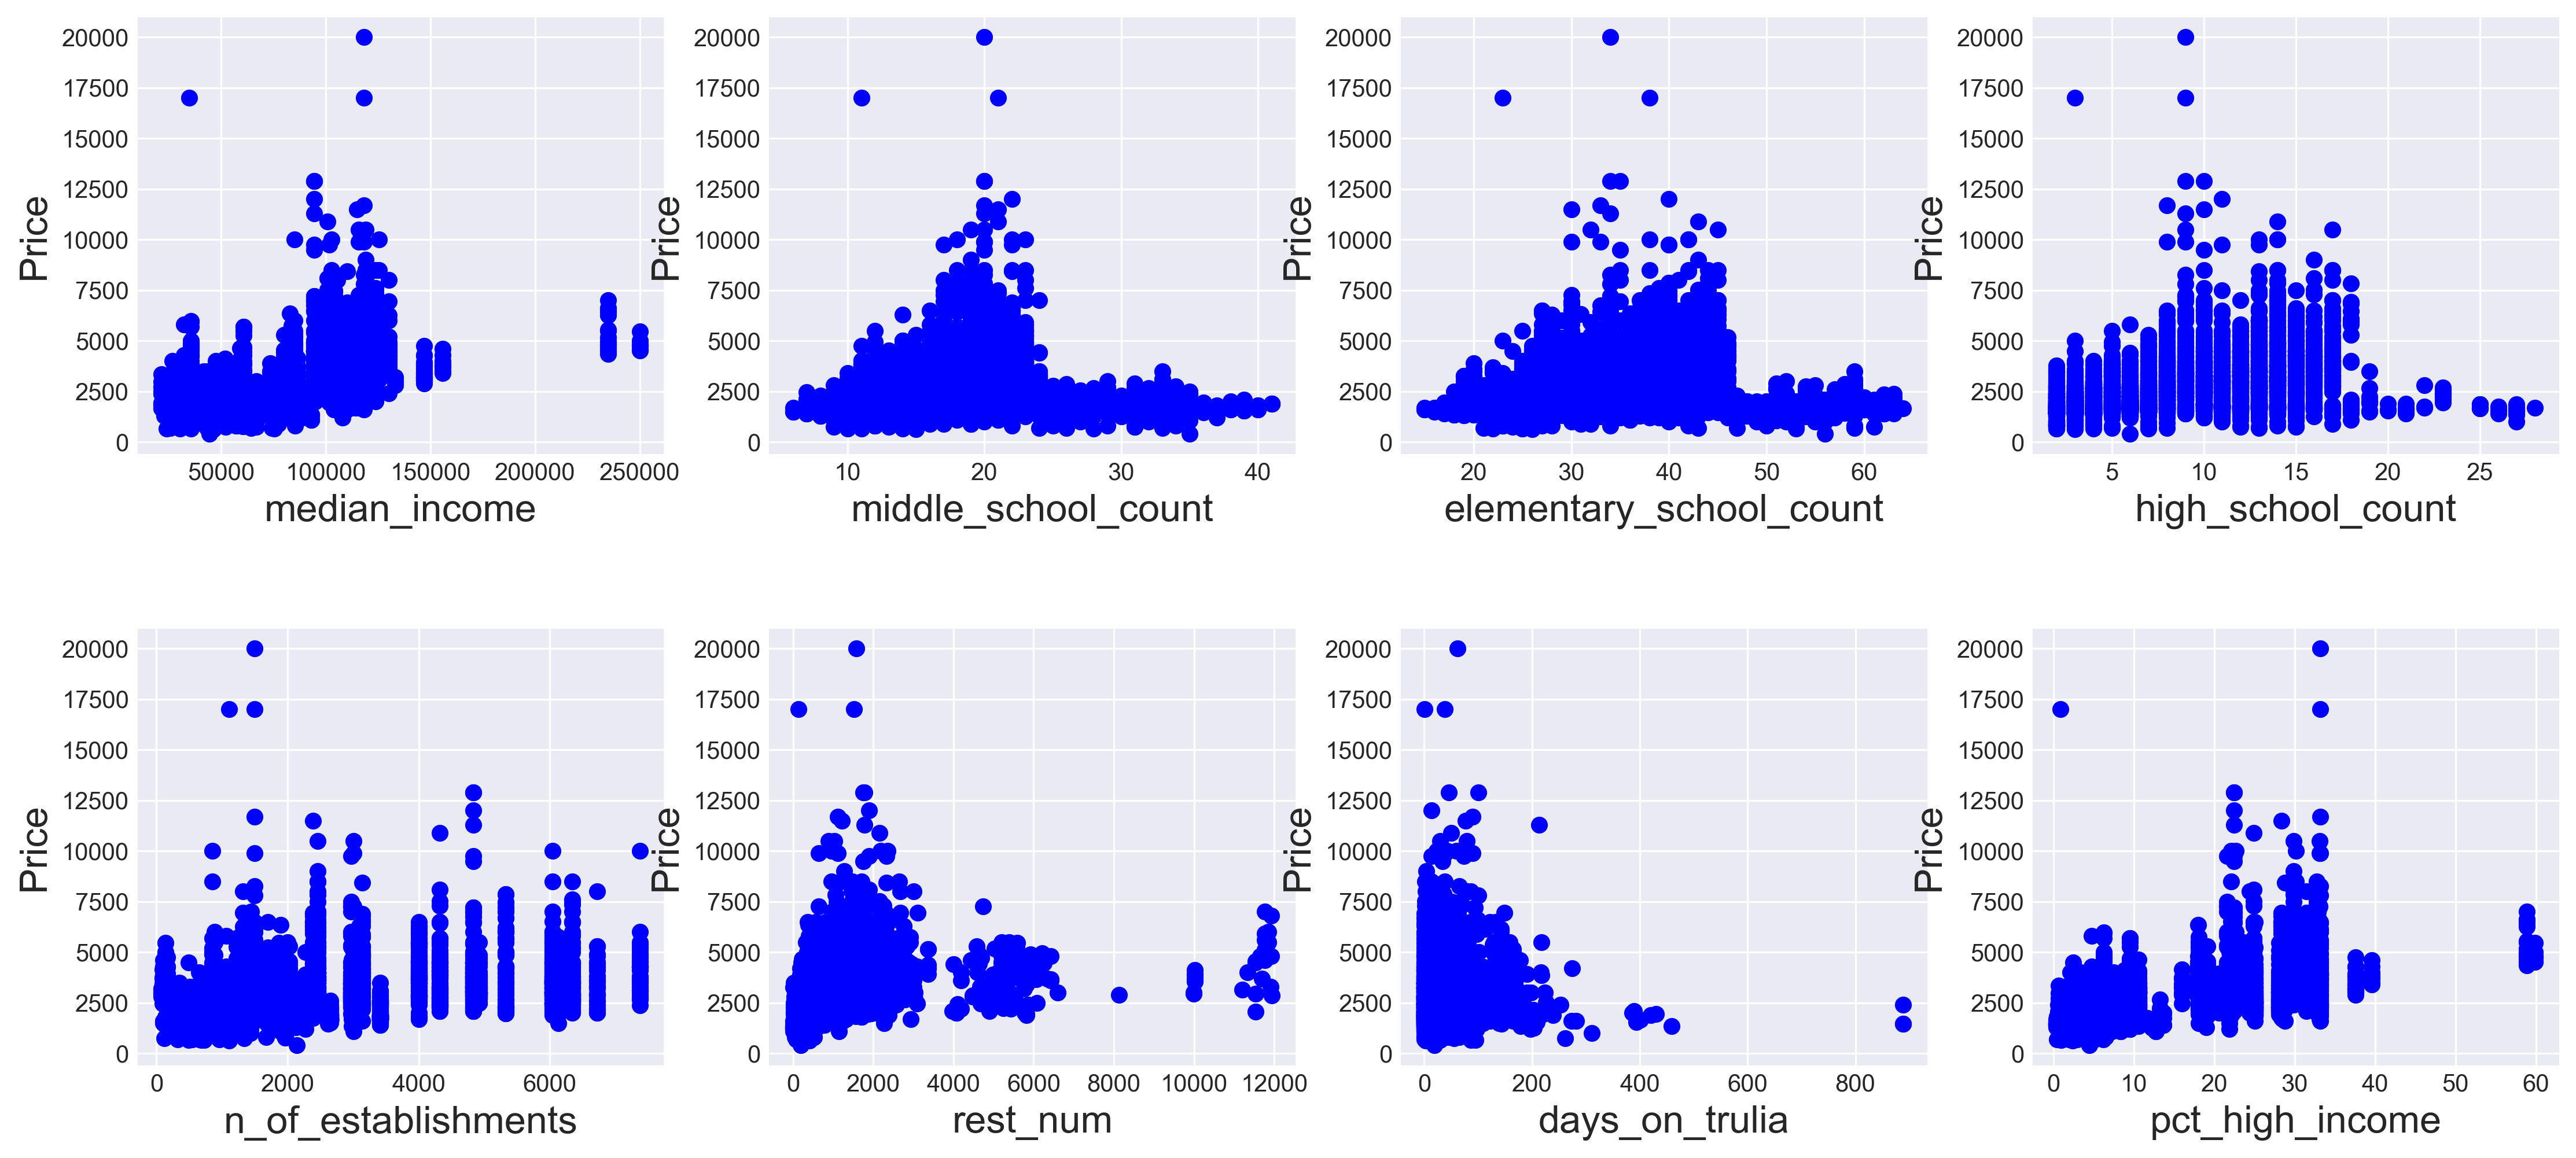

In [115]:
# create scatter plolts with dep var against non_demo_num vars
plt.figure(figsize=(18, 8))
y = df['price']
for var in non_demo_num:
    plt.subplot(2, 4, non_demo_num.index(var)+1)
    plt.plot(df[var], y,'bo')
    plt.subplots_adjust(hspace = 0.4)
    plt.xlabel(var, size = 16)
    plt.ylabel('Price', size=16);

### Observations:
- The number of schools in the neighborhood doesn't seem to be correlated to the price, which is not suprprising for one bedroom apartements

In [116]:
# change highly-skewed variables into log vars
log_vars = ['median_income','pct_high_income','rest_num','days_on_trulia']

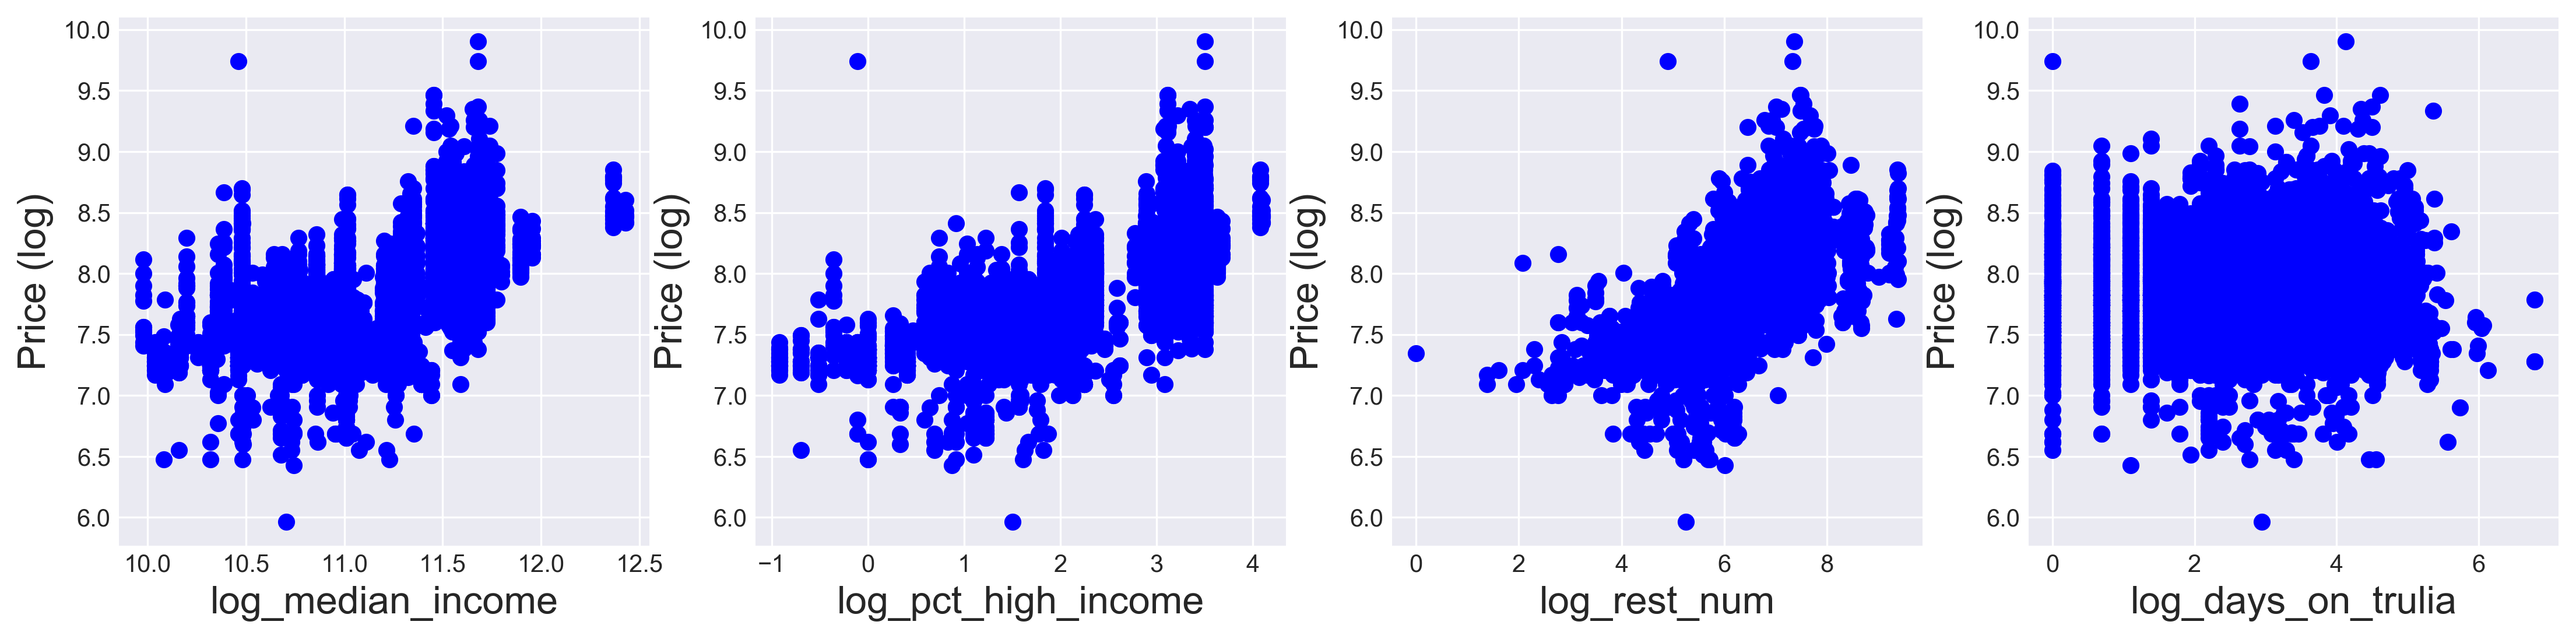

In [117]:
# create scatter plolts with dep var (log) against non_demo_num log-tansformd vars vars
plt.figure(figsize=(18, 4))
y = np.log(df.price)
for var in log_vars:
    plt.subplot(1, 4, log_vars.index(var)+1)
    x_var = np.log(df[var])
    plt.plot(x_var, y,'bo')
    plt.xlabel(f'log_{var}', size = 16)
    plt.ylabel('Price (log)', size = 16);

### Observations:
- Number of restaurants (log rest_num) has positive correlation with apt price <br>
- % of HI households (pct_hight_income) also has a positive correlation with apt price <br>

In [118]:
# school count variables are expected to be multicollinear, let's test that
school_vars = ['middle_school_count', 'elementary_school_count','high_school_count']

df[['middle_school_count', 'elementary_school_count','high_school_count','price']].corr()

middle_school_count  elementary_school_count  \
middle_school_count                 1.000000                 0.871883   
elementary_school_count             0.871883                 1.000000   
high_school_count                   0.415667                 0.593135   
price                              -0.093755                 0.007522   

                         high_school_count     price  
middle_school_count               0.415667 -0.093755  
elementary_school_count           0.593135  0.007522  
high_school_count                 1.000000  0.409157  
price                             0.409157  1.000000

### Obesrvations:
- There is a collinearity between elementary school and middle school
- High school has moderate correlation with elementary school
- Our dep var has a very low correlation with school-counts, with the expection of high school

In [119]:
len(non_demo_bool)

35

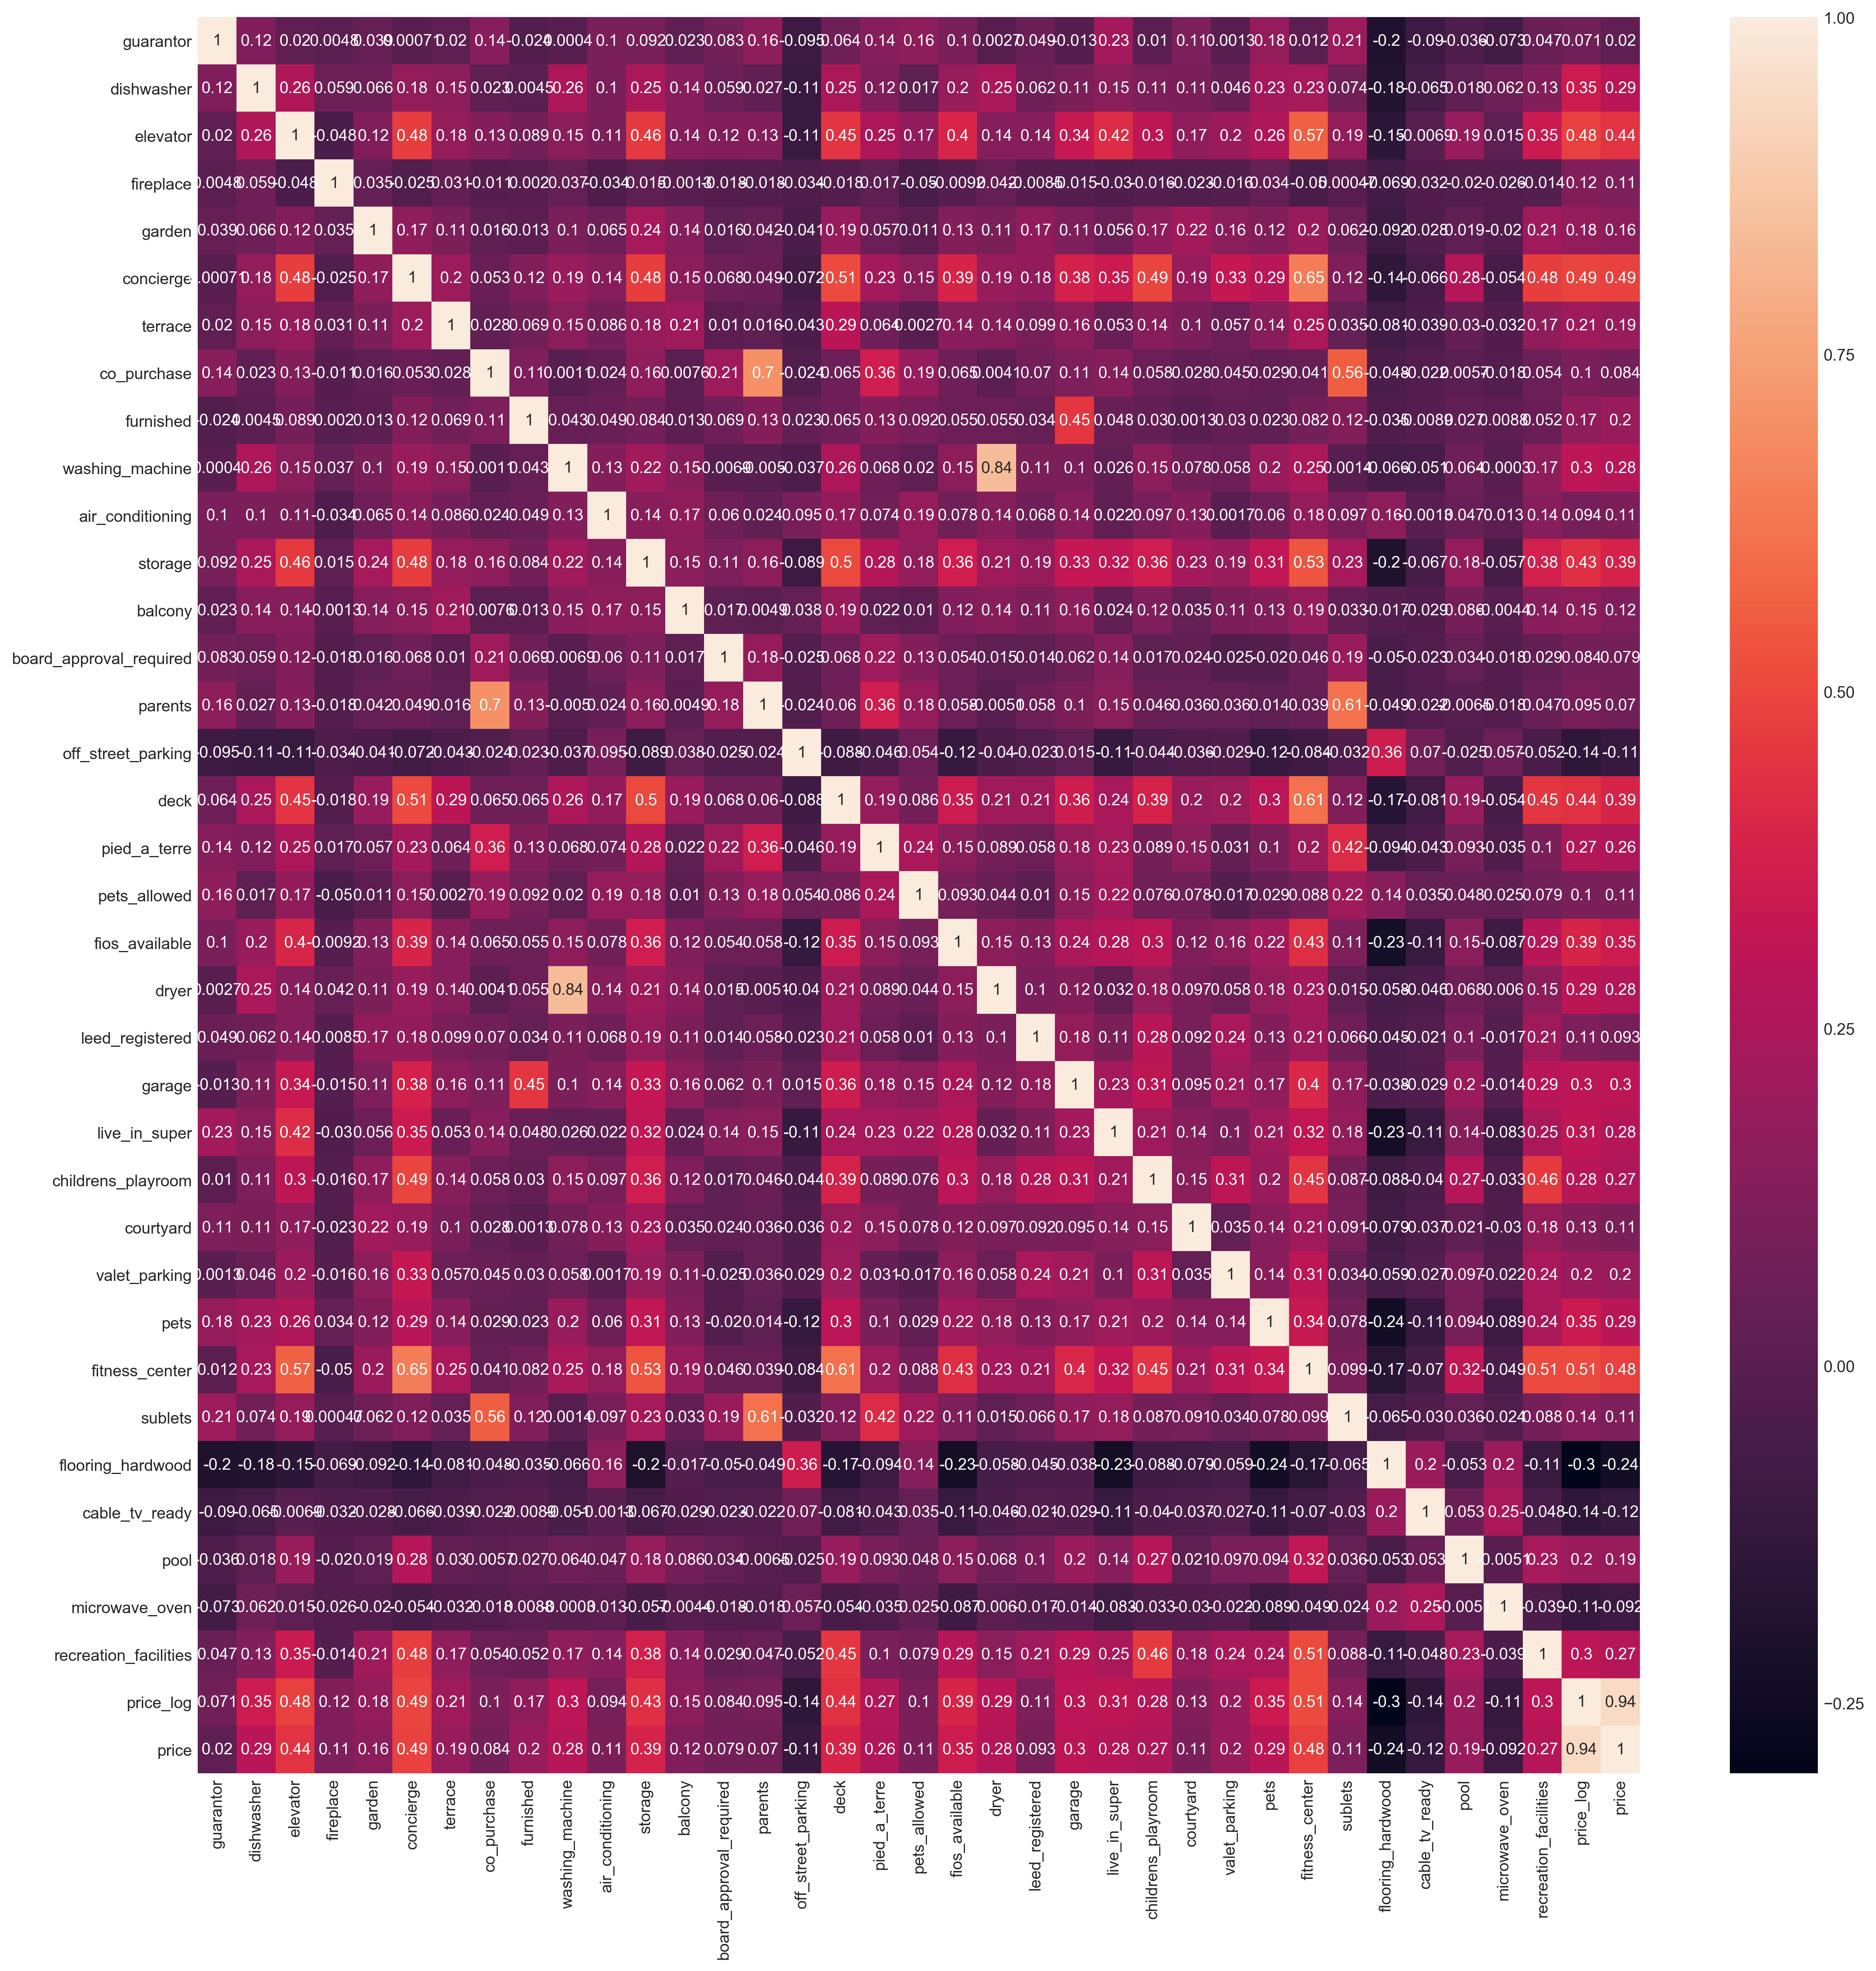

In [120]:
# test correlation between dep var, log-transformed dep var and non-demo binary features
df_test = df[non_demo_bool].copy()

df_test['price_log'] = np.log(df.price).copy()

df_test['price'] = df.price.copy()

df_test.head()

f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df_test.corr(), annot=True)
plt.show()

### Observations:
- from all features 'fitness center' has the highest correlation with the 1br apt rent price
- concierge, garage, deck and storage also have moderate correlation with rent price
- washing machine should be merged with dryer into one since they are highly correlated features

In [121]:
# merge washing machine and dryer since one comes with another in the apts
df['wash_dry'] = df.loc[(df['washing_machine'] == 1) |  (df['dryer'] == 1), 'wash_dry'] = 1
# drop the other two columns
df.drop(labels = ['washing_machine', 'dryer'], axis=1, inplace=True)
# update non_demo_bool list
non_demo_bool.remove('washing_machine')
non_demo_bool.remove('dryer')
non_demo_bool.append('wash_dry')

# Modeling

# 1. Statsmodels

In [122]:
# split data into test and train 
x = df.drop(labels=['price','address','sqft','url','evac','zip_code'], axis=1)
y = df['price']

X_train , X_test, y_train, y_test = model_selection.train_test_split(x,y, test_size = 0.3)

# Delete

In [123]:
# # drop outliers from train
# X_train['price'] = y_train.copy()

In [124]:
# X_train['price'].describe()

In [125]:
# price_cut_off = 2709 + 3*1286
# price_cut_off

In [126]:
# X_train = X_train[X_train.price < 6567].copy()
# y_train = X_train['price'].copy()
# X_train.drop('price', axis = 1, inplace = True)

### 1.1. Test Linear Regression on a subset on non-boolean non-demo features

In [127]:
non_demo_num

['median_income',
 'middle_school_count',
 'elementary_school_count',
 'high_school_count',
 'n_of_establishments',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [128]:
# use patsy on non_demo_num features only
df_train = X_train[non_demo_num].copy()
df_train['price'] = y_train

df_test = X_test[non_demo_num].copy()
df_test['price'] = y_test

# create a string for patsy input
non_demo_num_str = 'price' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

'price ~ median_income + middle_school_count + elementary_school_count + high_school_count + n_of_establishments + rest_num + days_on_trulia + pct_high_income'

In [129]:
# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(non_demo_num_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit1 = model.fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     484.1
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:07   Log-Likelihood:                -36092.
No. Observations:                4389   AIC:                         7.220e+04
Df Residuals:                    4380   BIC:                         7.226e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2003.5854     71.967     27.840      0.000    1862.494    2144.677
median_income              -0.0082      0.002     -5.097      0.000      -0.011      -0.005
middle_school_count       -16.4602      4.296     -3.832      0.000     -24.882      -8.039
elementary_school_count    -2.7984      2.994     -0.935      0.350      -8.668       3.071
high_school_count          47.0938      5.146      9.152      0.000      37.006      57.182
n_of_establishments         0.0768      0.011      6.736      0.000       0.054       0.099
rest_num                    0.1683      0.016     10.311      0.000       0.136       0.200
days_on_trulia              1.0534      0.334      3.154      0.002       0.399       1.708
pct_high_income            67.8875      4.891     13.879      0.000      58.298      77.477
==============================================================================
Omnibus:                     3544.376   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           212457.934
Skew:                           3.405   Prob(JB):                         0.00
Kurtosis:                      36.397   Cond. No.                     4.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Observations:
- Based on the Skewness number and very high Kurtosis, the values have heavy tails and a single high peak

### 1.2. Run Linear Regression on all features

In [130]:
# use patsy on all features
df_train = X_train.copy()
df_train['price'] = y_train

df_test = X_test.copy()
df_test['price'] = y_test

# create a string for patsy input
all_features_str = 'price' + ' ~ ' + ' + '.join(list(X_train.columns))

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(all_features_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit2 = model.fit()

fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     111.5
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:07   Log-Likelihood:                -35300.
No. Observations:                4389   AIC:                         7.073e+04
Df Residuals:                    4322   BIC:                         7.116e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -3.669e+09   4.73e+09     -0.776      0.438   -1.29e+10     5.6e+09
days_on_trulia                                          0.7670      0.289      2.652      0.008       0.200       1.334
elementary_school_count                                 3.6203      2.940      1.232      0.218      -2.143       9.383
high_school_count                                      25.0770      5.046      4.970      0.000      15.184      34.970
middle_school_count                                   -11.4811      4.592     -2.500      0.012     -20.483      -2.479
pets_allowed                                           69.0849     28.502      2.424      0.015      13.207     124.963
guarantor                                            -149.1190     29.882     -4.990      0.000    -207.703     -90.535
storage                                                69.0989     34.850      1.983      0.047       0.775     137.423
garage                                                -55.7997     40.915     -1.364      0.173    -136.013      24.414
deck                                                   54.0145     39.582      1.365      0.172     -23.586     131.615
elevator                                              292.6738     32.056      9.130      0.000     229.828     355.519
dishwasher                                            156.2543     26.948      5.798      0.000     103.422     209.086
pets                                                   56.9753     27.821      2.048      0.041       2.431     111.519
fios_available                                         95.0276     29.360      3.237      0.001      37.467     152.588
live_in_super                                        -113.6149     30.258     -3.755      0.000    -172.935     -54.295
fitness_center                                        324.2569     45.152      7.182      0.000     235.736     412.777
concierge                                             365.7557     48.790      7.496      0.000     270.102     461.410
balcony                                                64.7639     36.850      1.757      0.079      -7.482     137.010
air_conditioning                                      139.6497     39.488      3.537      0.000      62.233     217.066
flooring_hardwood                                     -26.1524     47.184     -0.554      0.579    -118.656      66.352
recreation_facilities                                 -44.7486     52.021     -0.860      0.390    -146.736      57.238
garden                                                147.5506     44.627      3.306      0.001      60.059     235.042
pied_a_terre                                          225.7917     55.350      4.07

### Test scores on all features for future comparison

In [131]:
lr = LinearRegression(fit_intercept=True,)
lr.fit(X_train, y_train)

print('Train score: ', round(lr.score(X_train, y_train),3))
print('Test score: ', round(lr.score(X_test, y_test),3))

Train score:  0.63
Test score:  0.586


### 1.3. Run model on features with p < 0.05

In [132]:
# get a list of features with p-val < 0.05 
low_p_feat = ['days_on_trulia',
'elementary_school_count',
'high_school_count',
'middle_school_count',
'pets_allowed',
'guarantor',
'storage',
'elevator',
'dishwasher',
'pets',
'fios_available',
'live_in_super',
'fitness_center',
'concierge',
'air_conditioning',
'recreation_facilities',
'garden',
'pied_a_terre',
'terrace',
'pool',
'furnished',
'fireplace',
'sublets',
'parents',
'leed_registered',
'median_income',
'pct_high_income',
'demo_total_population',
'demo_pct_18_years_and_over',
'rest_num',
'n_of_establishments']

In [133]:
# model only with features with p-val < 0.05
df_train = X_train[low_p_feat].copy()
df_train['price'] = y_train

df_test = X_test[low_p_feat].copy()
df_test['price'] = y_test

# create a string for patsy input
low_p_feat_str = 'price' + ' ~ ' + ' + '.join(low_p_feat)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit3 = model.fit()

fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     227.7
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:07   Log-Likelihood:                -35369.
No. Observations:                4389   AIC:                         7.080e+04
Df Residuals:                    4357   BIC:                         7.101e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1004.5784    274.611     -3.658      0.000   -1542.956    -466.201
days_on_trulia                 0.4789      0.287      1.667      0.096      -0.084       1.042
elementary_school_count        5.5940      2.583      2.165      0.030       0.529      10.659
high_school_count             28.5002      4.579      6.225      0.000      19.524      37.477
middle_school_count          -21.1713      3.713     -5.703      0.000     -28.450     -13.893
pets_allowed                  50.9215     28.089      1.813      0.070      -4.147     105.991
guarantor                   -134.7760     29.589     -4.555      0.000    -192.785     -76.766
storage                       83.1934     34.283      2.427      0.015      15.981     150.405
elevator                     267.2211     31.712      8.427      0.000     205.050     329.393
dishwasher                   180.6002     26.426      6.834      0.000     128.791     232.409
pets                          82.4555     27.700      2.977      0.003      28.148     136.763
fios_available               127.4791     28.958      4.402      0.000      70.707     184.252
live_in_super               -113.2044     29.811     -3.797      0.000    -171.650     -54.759
fitness_center               352.9972     43.554      8.105      0.000     267.609     438.386
concierge                    342.4192     46.740      7.326      0.000     250.784     434.054
air_conditioning             129.9354     38.285      3.394      0.001      54.878     204.993
recreation_facilities        -41.9889     50.016     -0.840      0.401    -140.046      56.068
garden                       164.0617     43.996      3.729      0.000      77.806     250.317
pied_a_terre                 204.5562     54.548      3.750      0.000      97.614     311.498
terrace                      198.4657     50.344      3.942      0.000      99.765     297.166
pool                         269.2577     57.617      4.673      0.000     156.299     382.216
furnished                    419.6263     59.480      7.055      0.000     303.015     536.238
fireplace                    184.6175     61.806      2.987      0.003      63.445     305.790
sublets                     -164.5154     86.009     -1.913      0.056    -333.137       4.106
parents                     -346.9889    106.908     -3.246      0.001    -556.582    -137.396
leed_registered             -141.1760     94.059     -1.501      0.133    -325.579      43.227
median_income                 -0.0091      0.001     -6.438      0.000      -0.012      -0.006
pct_high_income               57.5927      4.231     13.612      0.000      49.298      65.888
demo_total_population          0.0022      0.001      3.402      0.001       0.001       0.003
demo_pct_18_years_and_over  3507.6739    33

In [134]:
low_p_feat

['days_on_trulia',
 'elementary_school_count',
 'high_school_count',
 'middle_school_count',
 'pets_allowed',
 'guarantor',
 'storage',
 'elevator',
 'dishwasher',
 'pets',
 'fios_available',
 'live_in_super',
 'fitness_center',
 'concierge',
 'air_conditioning',
 'recreation_facilities',
 'garden',
 'pied_a_terre',
 'terrace',
 'pool',
 'furnished',
 'fireplace',
 'sublets',
 'parents',
 'leed_registered',
 'median_income',
 'pct_high_income',
 'demo_total_population',
 'demo_pct_18_years_and_over',
 'rest_num',
 'n_of_establishments']

### Best model results on non-transformed dep var for future comparison:

In [135]:
# compare test and train scores using sklearn
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train[low_p_feat], y_train)

best_non_log_train = round(lr.score(X_train[low_p_feat], y_train),3)
best_non_log_test = round(lr.score(X_test[low_p_feat], y_test),3)

print('Train score: ', best_non_log_train)
print('Test score: ', best_non_log_test)

Train score:  0.618
Test score:  0.579


Text(0,0.5,'Residiuals')

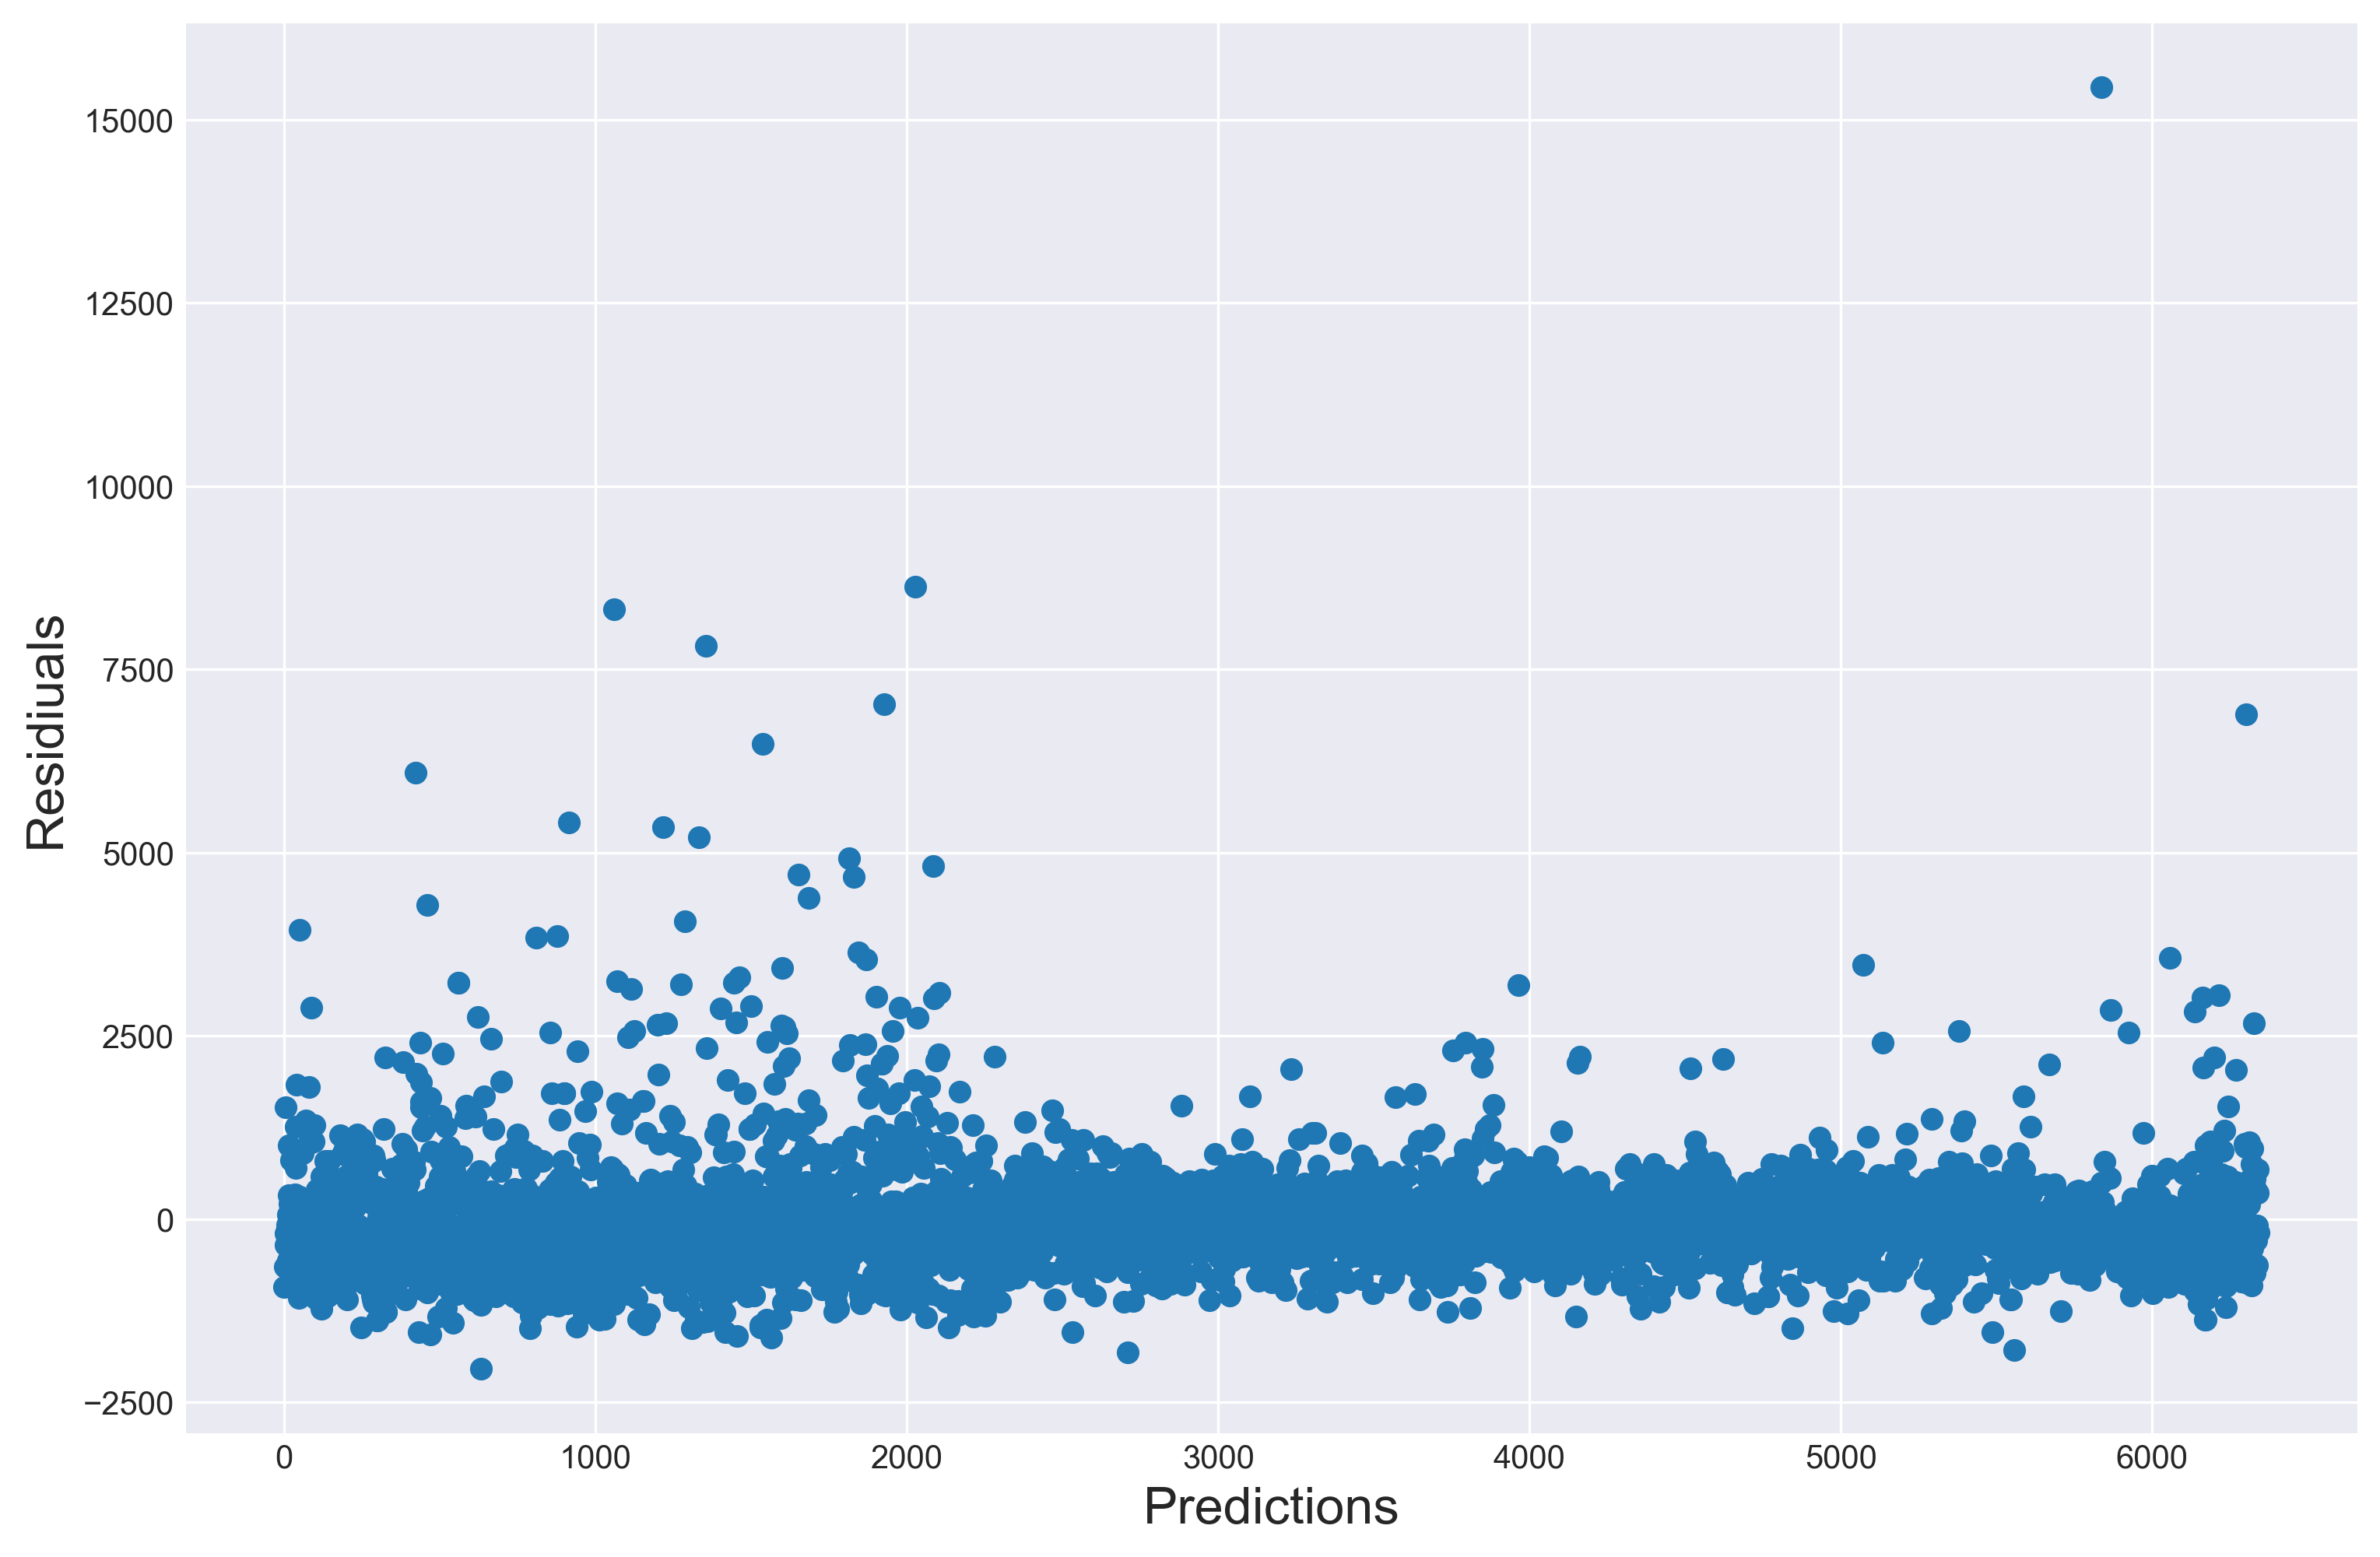

In [136]:
# Plot the residuals
fit3.resid.plot(style='o', figsize=(12,8))
plt.xlabel('Predictions', size = 16)
plt.ylabel('Residiuals', size = 16)

In [137]:
# check residuals against individual features
resids3 = fit3.predict(X_sm) - y_sm.price

In [138]:
log_vars = ['median_income','pct_high_income','rest_num','days_on_trulia']

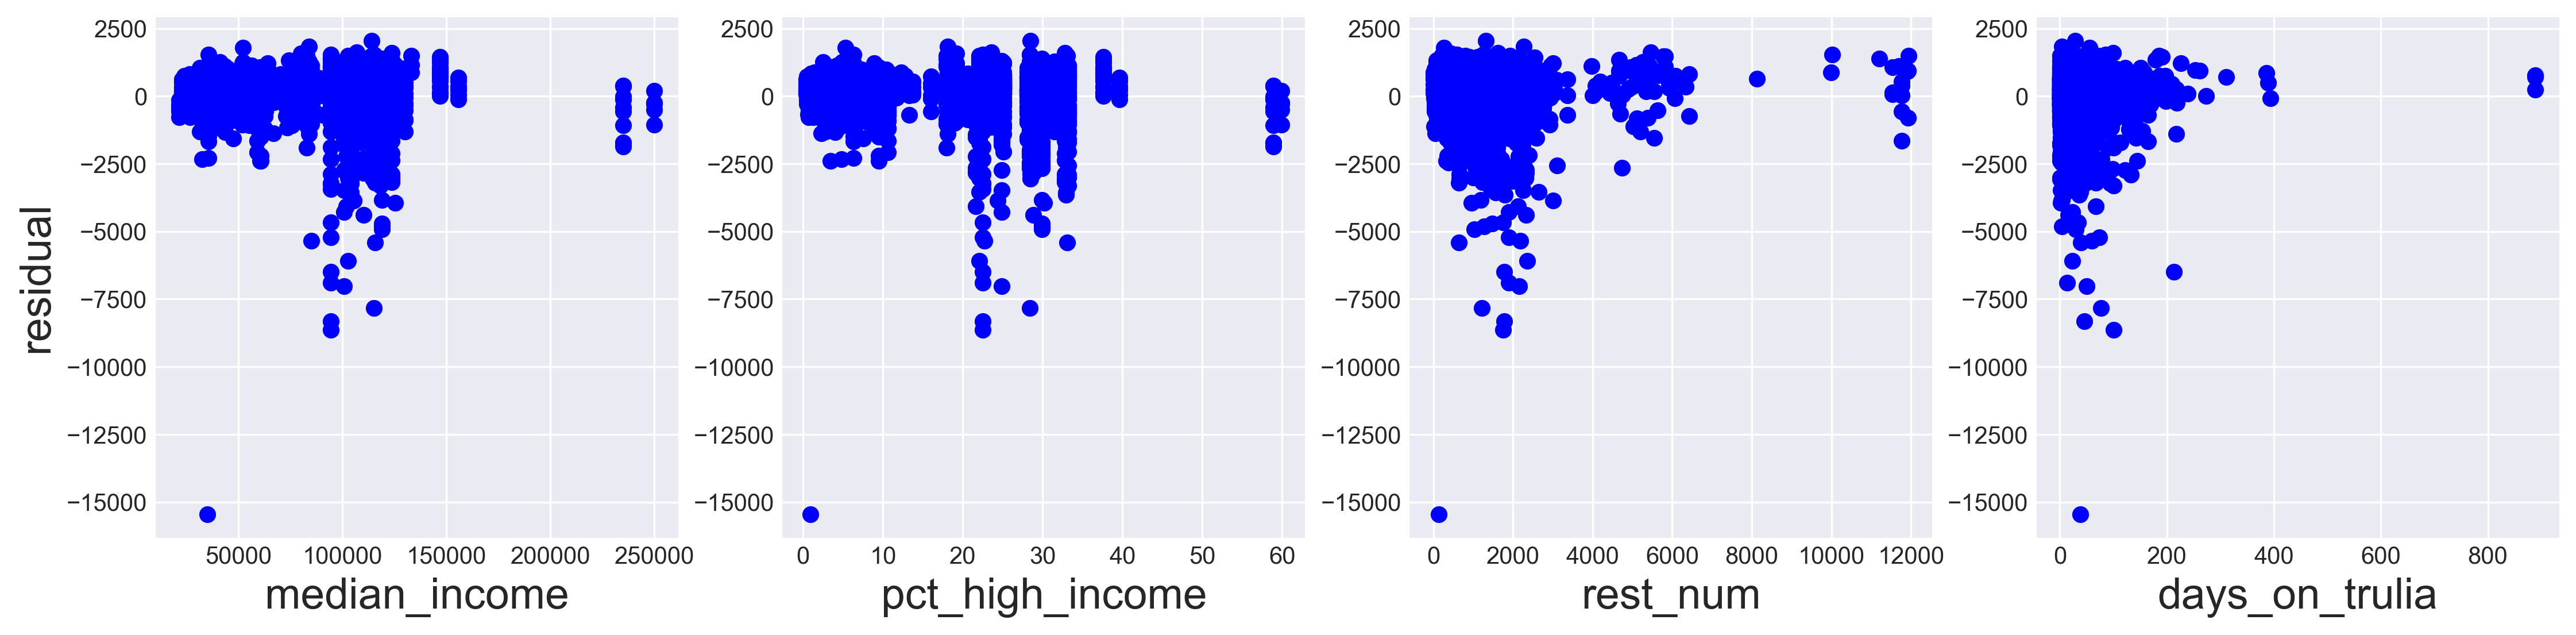

In [139]:
# check if any of the non-normally distributed variables should be transformed based on residual plots
plt.figure(figsize=(18, 4))
for var in log_vars:
    plt.subplot(1, 4, log_vars.index(var)+1)
    plt.plot(X_sm[var],resids3, 'bo')
    plt.xlabel(var, size=18)
    if log_vars.index(var)==0:
        plt.ylabel('residual', size = 18);

### Observations:
- The model is 'missing' when y values are very high. We know that our y is not-normally distributed. Transforming y variable can improve model accuracy

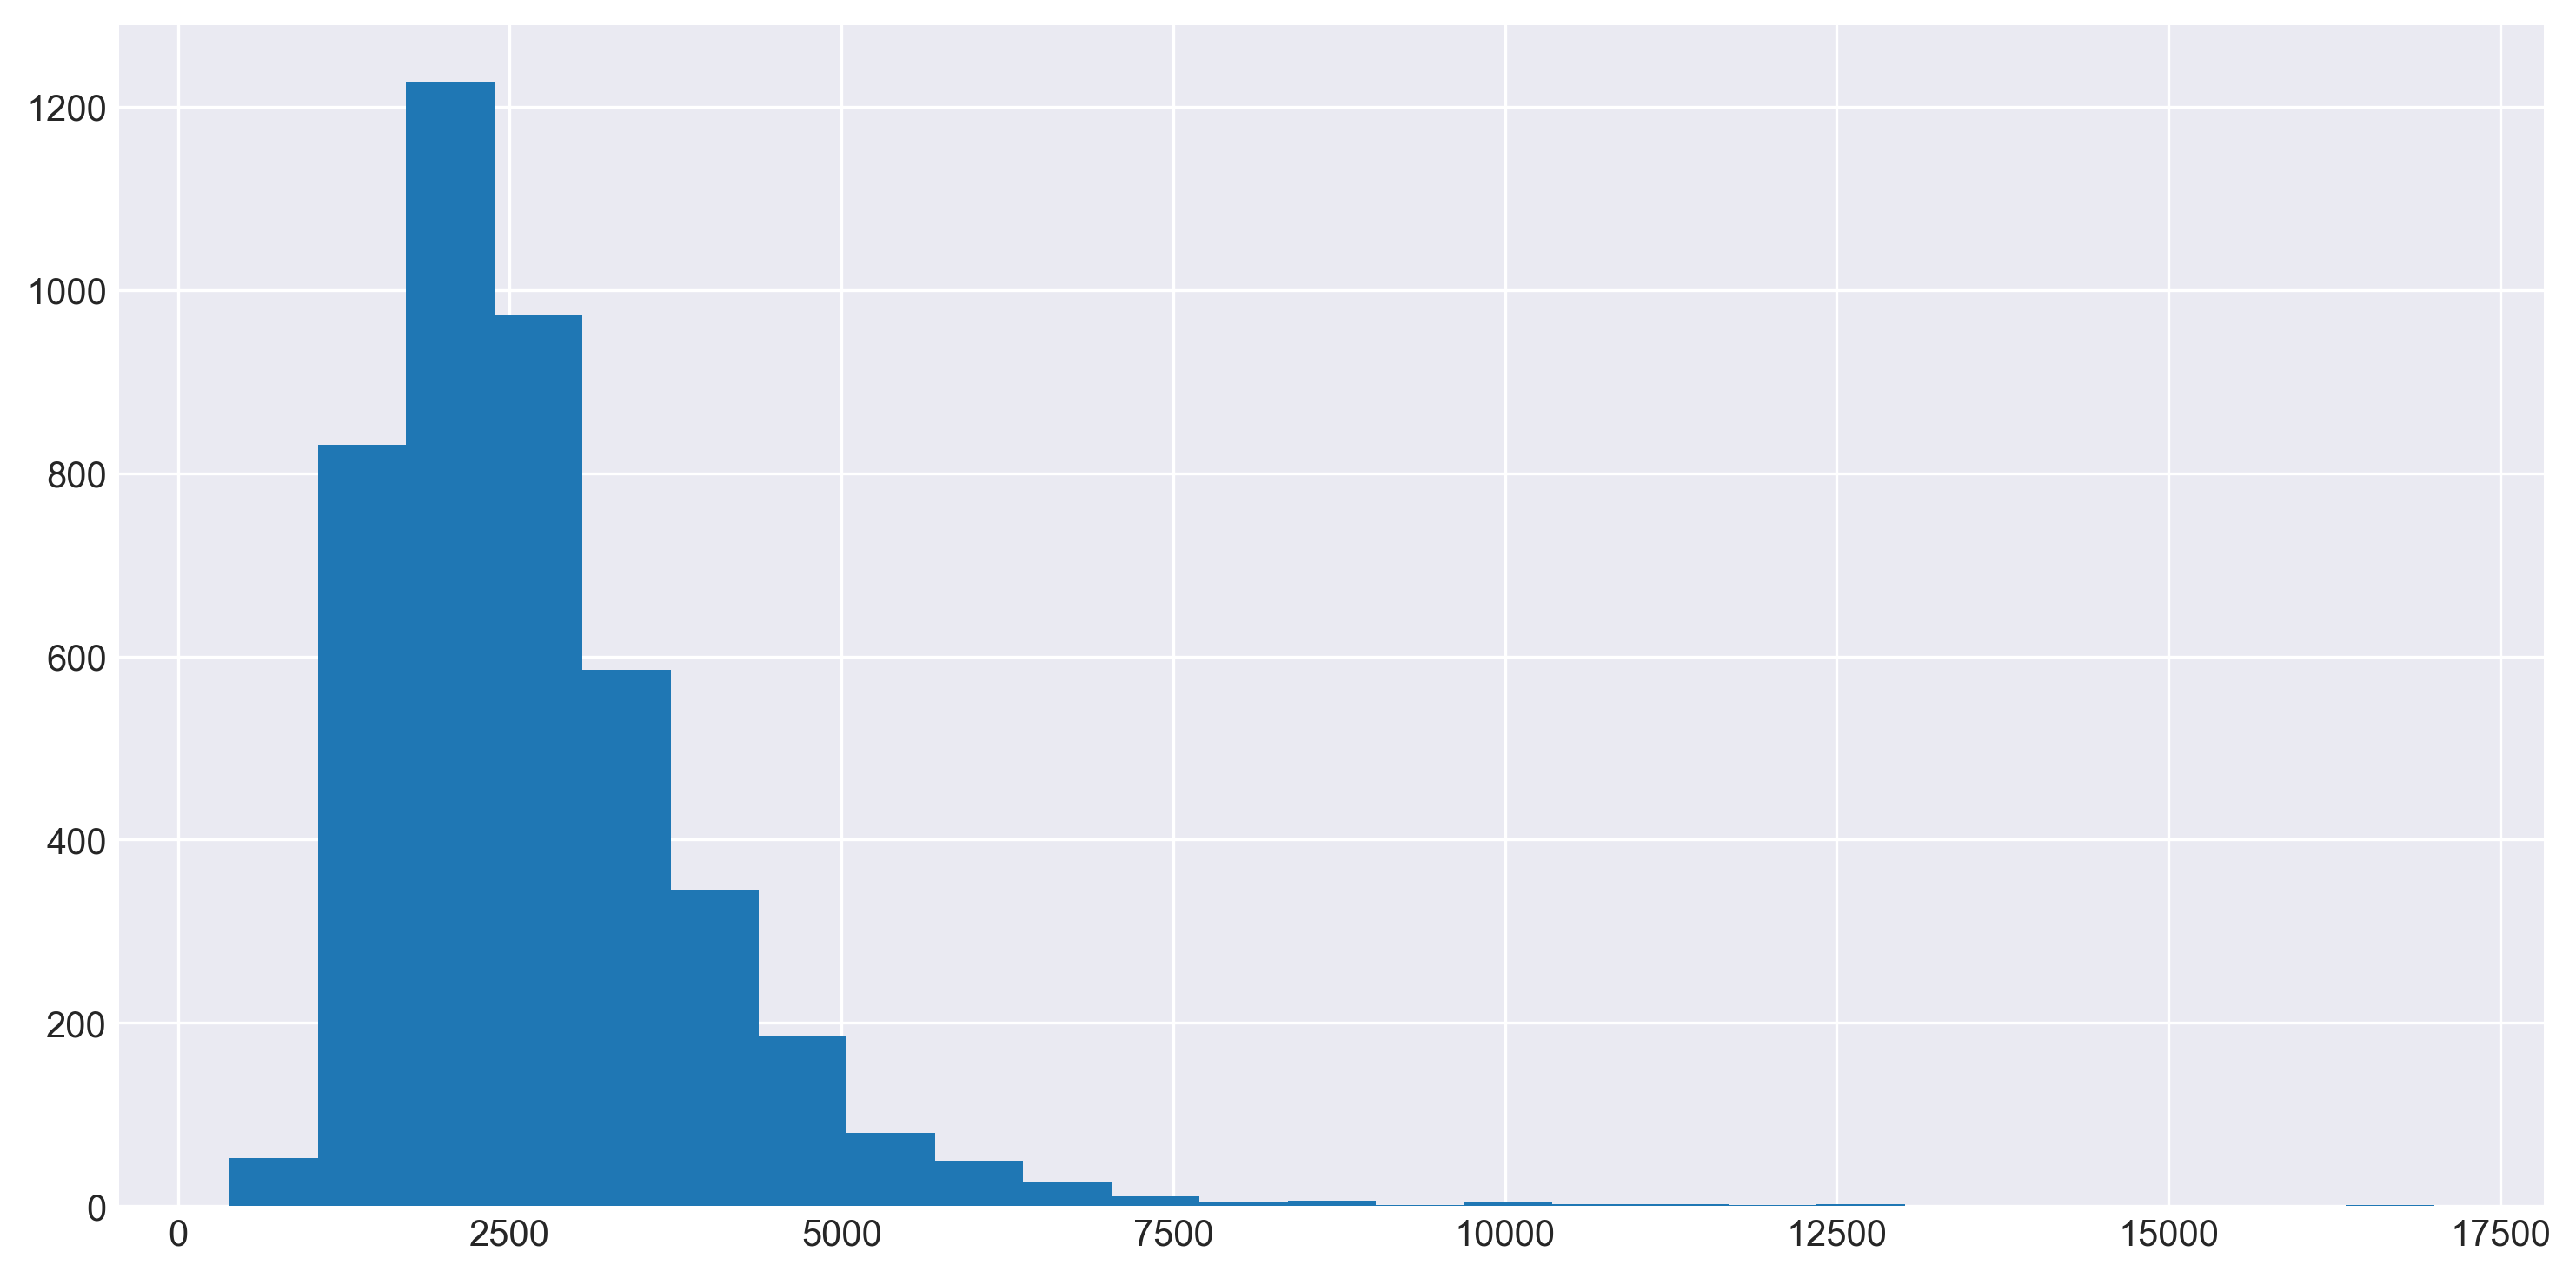

In [140]:
plt.figure(figsize=(12, 6))
plt.hist(y_train,bins=25);

### 1.4. Run the model on log-transformed dep var

In [141]:
# test statmodels on log-transformed dep var
df_train = X_train[low_p_feat].copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test[low_p_feat].copy()
df_test['price_log'] = np.log(y_test)

# create a string for patsy input
low_p_feat_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit4 = model.fit()

fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     391.7
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:11   Log-Likelihood:                 664.10
No. Observations:                4389   AIC:                            -1264.
Df Residuals:                    4357   BIC:                            -1060.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.2320      0.075     83.440      0.000       6.086       6.378
days_on_trulia              4.124e-05   7.82e-05      0.528      0.598      -0.000       0.000
elementary_school_count        0.0010      0.001      1.402      0.161      -0.000       0.002
high_school_count              0.0088      0.001      7.030      0.000       0.006       0.011
middle_school_count           -0.0059      0.001     -5.797      0.000      -0.008      -0.004
pets_allowed                   0.0119      0.008      1.560      0.119      -0.003       0.027
guarantor                     -0.0220      0.008     -2.730      0.006      -0.038      -0.006
storage                        0.0437      0.009      4.685      0.000       0.025       0.062
elevator                       0.0882      0.009     10.222      0.000       0.071       0.105
dishwasher                     0.0867      0.007     12.066      0.000       0.073       0.101
pets                           0.0480      0.008      6.366      0.000       0.033       0.063
fios_available                 0.0525      0.008      6.666      0.000       0.037       0.068
live_in_super                 -0.0346      0.008     -4.270      0.000      -0.051      -0.019
fitness_center                 0.1154      0.012      9.740      0.000       0.092       0.139
concierge                      0.0603      0.013      4.740      0.000       0.035       0.085
air_conditioning               0.0273      0.010      2.623      0.009       0.007       0.048
recreation_facilities         -0.0006      0.014     -0.046      0.963      -0.027       0.026
garden                         0.0646      0.012      5.400      0.000       0.041       0.088
pied_a_terre                   0.0289      0.015      1.951      0.051      -0.000       0.058
terrace                        0.0700      0.014      5.111      0.000       0.043       0.097
pool                           0.0837      0.016      5.339      0.000       0.053       0.114
furnished                      0.0704      0.016      4.352      0.000       0.039       0.102
fireplace                      0.0682      0.017      4.055      0.000       0.035       0.101
sublets                       -0.0483      0.023     -2.064      0.039      -0.094      -0.002
parents                       -0.0647      0.029     -2.227      0.026      -0.122      -0.008
leed_registered               -0.0267      0.026     -1.044      0.296      -0.077       0.023
median_income              -3.892e-06   3.85e-07    -10.117      0.000   -4.65e-06   -3.14e-06
pct_high_income                0.0230      0.001     19.959      0.000       0.021       0.025
demo_total_population       7.642e-07   1.73e-07      4.421      0.000    4.25e-07     1.1e-06
demo_pct_18_years_and_over     1.6130      

### 1.5. Run model on log-transformed dep var using features with p < 0.05

In [142]:
# create a list of features with p < 0.05 that came out of log-transformed dep var model
low_p_feat_log = ['elementary_school_count',
'high_school_count',
'middle_school_count',
'guarantor',
'storage',
'elevator',
'dishwasher',
'pets',
'fios_available',
'live_in_super',
'fitness_center',
'concierge',
'air_conditioning',
'garden',
'terrace',
'pool',
'furnished',
'fireplace',
'median_income',
'pct_high_income',
'demo_total_population',
'demo_pct_18_years_and_over',
'rest_num',
'n_of_establishments']

In [143]:
df_train = X_train[low_p_feat_log].copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test[low_p_feat_log].copy()
df_test['price_log'] = np.log(y_test)

# create a string for patsy input
low_p_feat_log_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat_log)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_log_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit5 = model.fit()

fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     503.1
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:11   Log-Likelihood:                 652.56
No. Observations:                4389   AIC:                            -1255.
Df Residuals:                    4364   BIC:                            -1095.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.2503      0.074     84.044      0.000       6.104       6.396
elementary_school_count        0.0010      0.001      1.392      0.164      -0.000       0.002
high_school_count              0.0087      0.001      6.948      0.000       0.006       0.011
middle_school_count           -0.0057      0.001     -5.700      0.000      -0.008      -0.004
guarantor                     -0.0260      0.008     -3.310      0.001      -0.041      -0.011
storage                        0.0408      0.009      4.462      0.000       0.023       0.059
elevator                       0.0870      0.009     10.193      0.000       0.070       0.104
dishwasher                     0.0871      0.007     12.111      0.000       0.073       0.101
pets                           0.0483      0.007      6.443      0.000       0.034       0.063
fios_available                 0.0530      0.008      6.720      0.000       0.038       0.068
live_in_super                 -0.0340      0.008     -4.238      0.000      -0.050      -0.018
fitness_center                 0.1168      0.012     10.088      0.000       0.094       0.139
concierge                      0.0639      0.012      5.135      0.000       0.039       0.088
air_conditioning               0.0288      0.010      2.799      0.005       0.009       0.049
garden                         0.0610      0.012      5.154      0.000       0.038       0.084
terrace                        0.0686      0.014      5.011      0.000       0.042       0.095
pool                           0.0840      0.016      5.387      0.000       0.053       0.115
furnished                      0.0665      0.016      4.149      0.000       0.035       0.098
fireplace                      0.0689      0.017      4.102      0.000       0.036       0.102
median_income              -3.941e-06   3.85e-07    -10.246      0.000    -4.7e-06   -3.19e-06
pct_high_income                0.0232      0.001     20.149      0.000       0.021       0.025
demo_total_population       7.622e-07   1.73e-07      4.407      0.000    4.23e-07     1.1e-06
demo_pct_18_years_and_over     1.5974      0.090     17.726      0.000       1.421       1.774
rest_num                    2.902e-05   3.92e-06      7.410      0.000    2.13e-05    3.67e-05
n_of_establishments         -9.16e-06   2.96e-06     -3.099      0.002    -1.5e-05   -3.37e-06
==============================================================================
Omnibus:                      850.865   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9253.910
Skew:                           0.602   Prob(JB):                         0.00
Kurtosis:                      10.011   Cond. No.                     3.58e+06
============================

Text(0,0.5,'Residiuals')

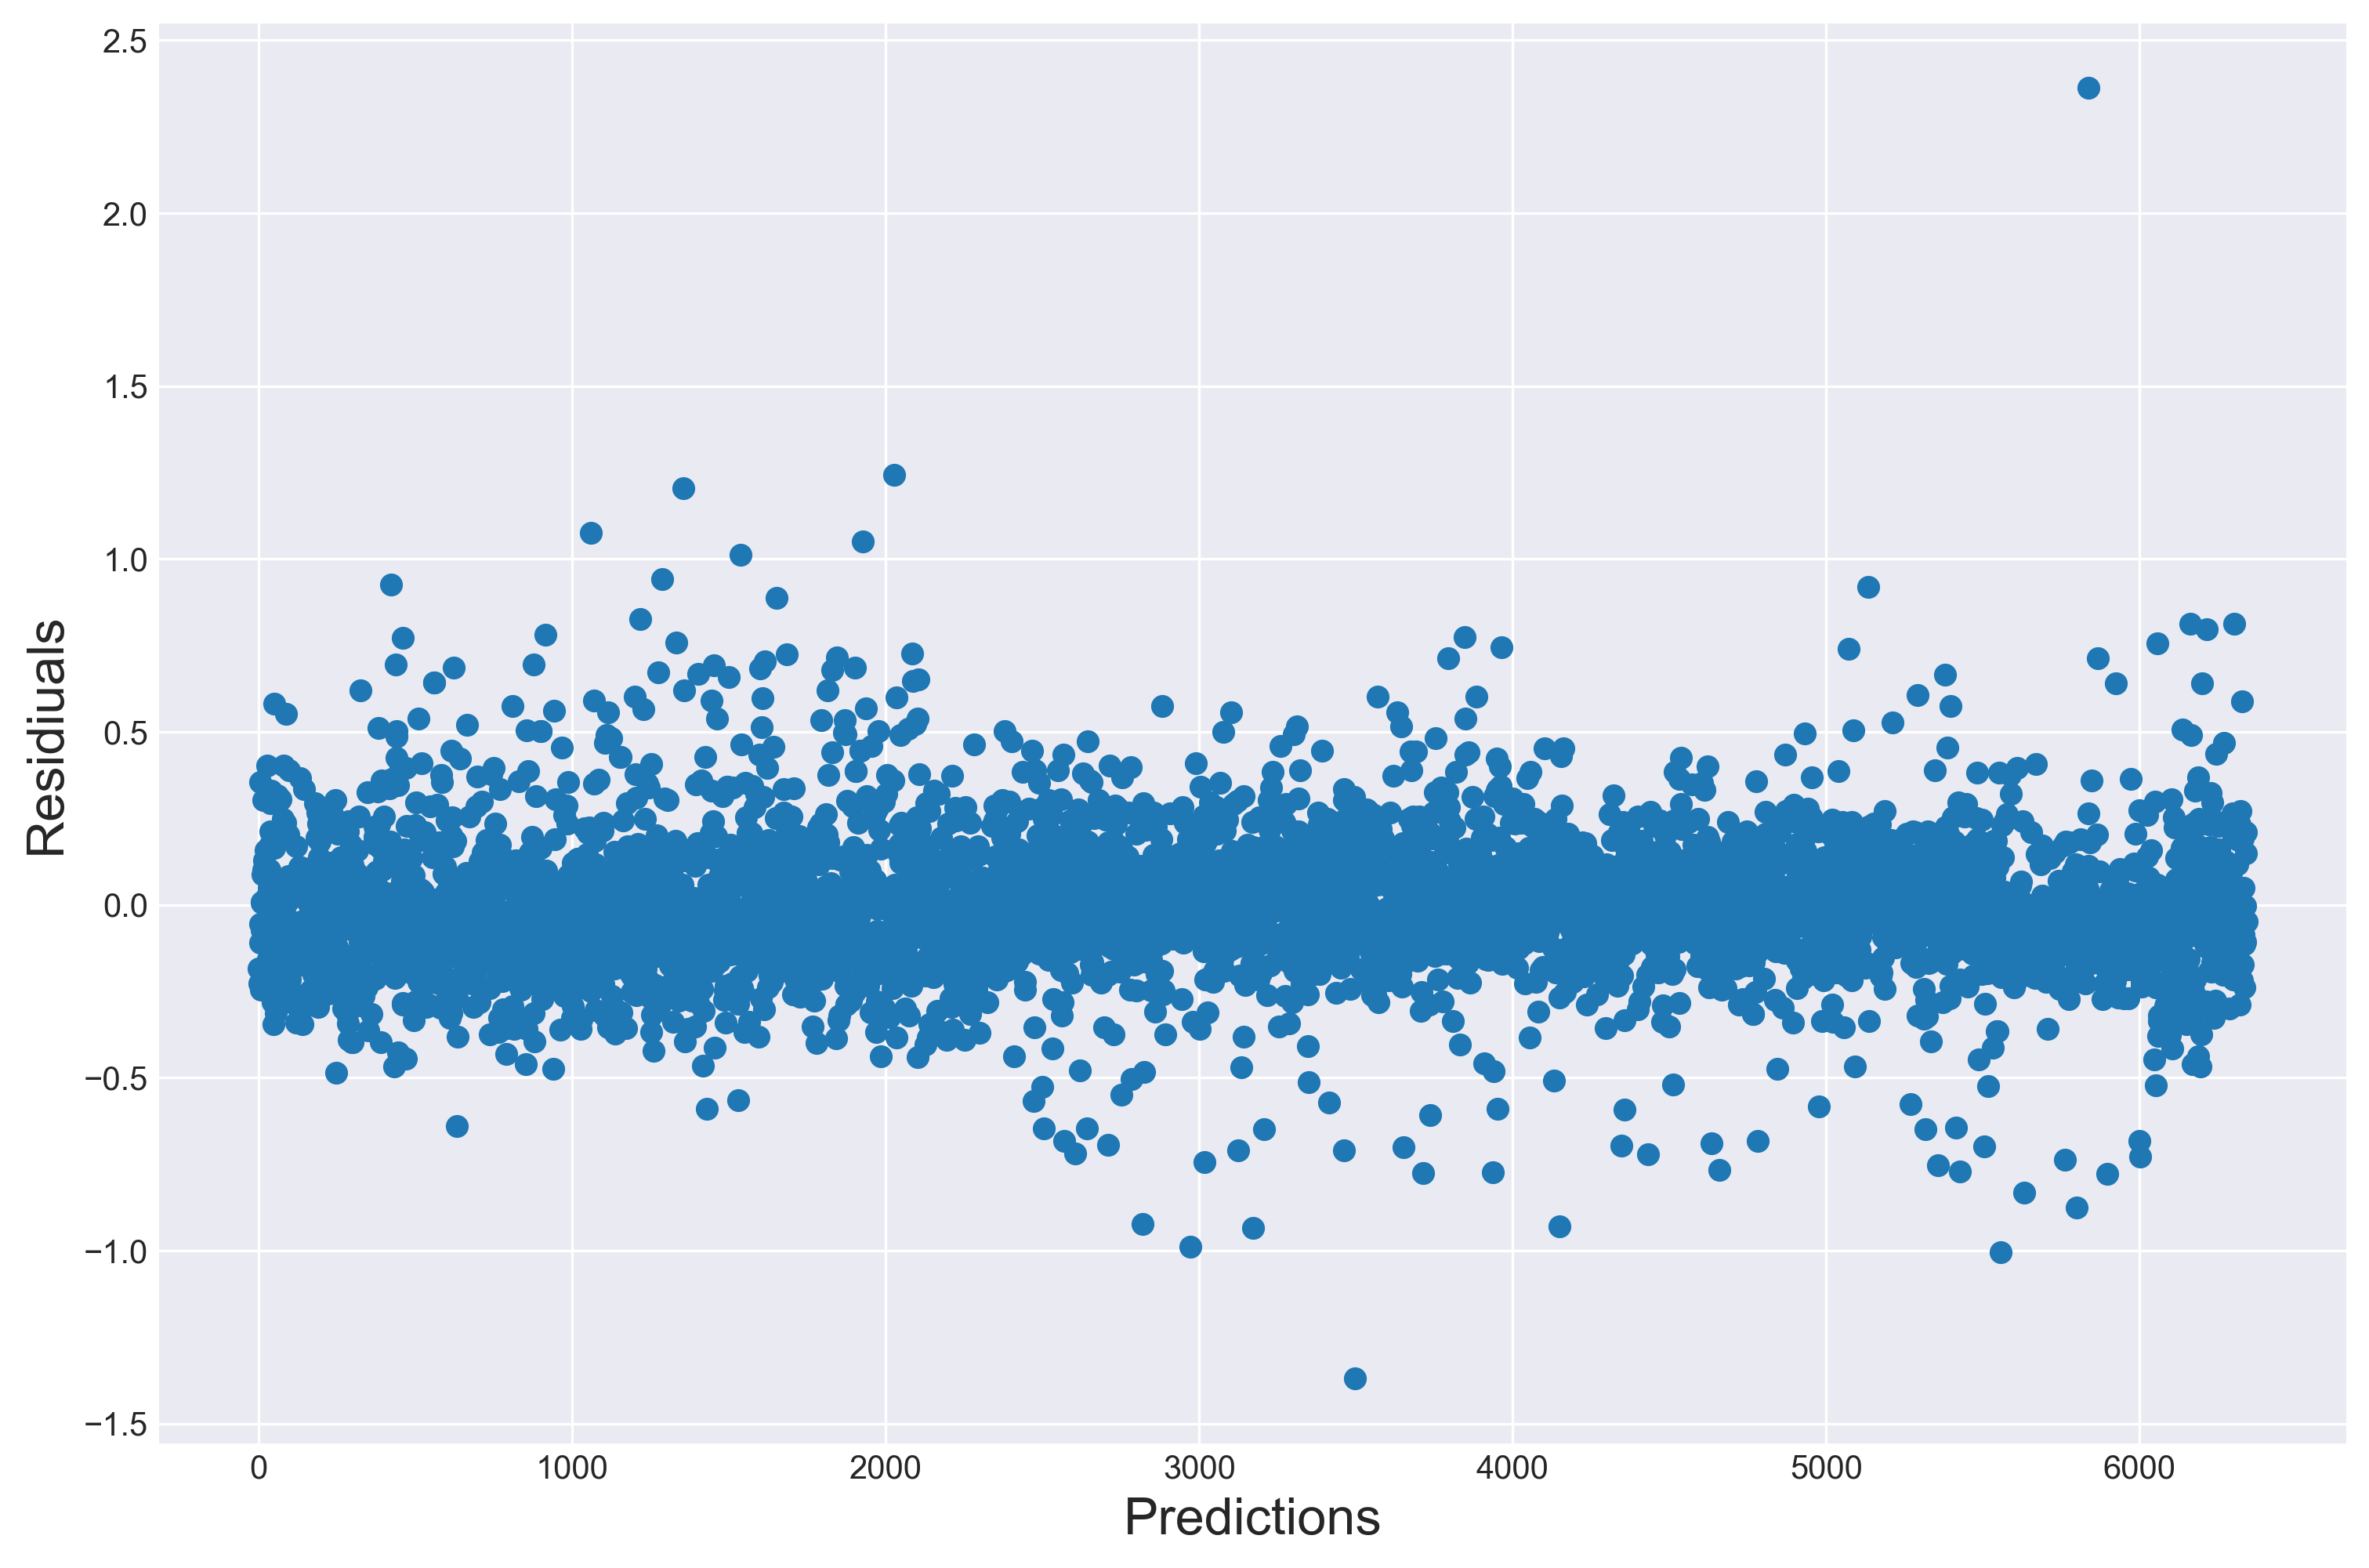

In [144]:
# Plot the residuals
fit5.resid.plot(style='o', figsize=(12,8))
plt.xlabel('Predictions', size = 16)
plt.ylabel('Residiuals', size = 16)

### Observations:
- The residuals are 'clustered' tighter around zero compared to the previous models

In [145]:
# compare test and train scores using sklearn
lr = LinearRegression(fit_intercept=True,)
lr.fit(X_train[low_p_feat_log], np.log(y_train))

print('Train score: ', round(lr.score(X_train[low_p_feat_log], np.log(y_train)),3))
print('Test score: ', round(lr.score(X_test[low_p_feat_log], np.log(y_test)),3))

Train score:  0.735
Test score:  0.724


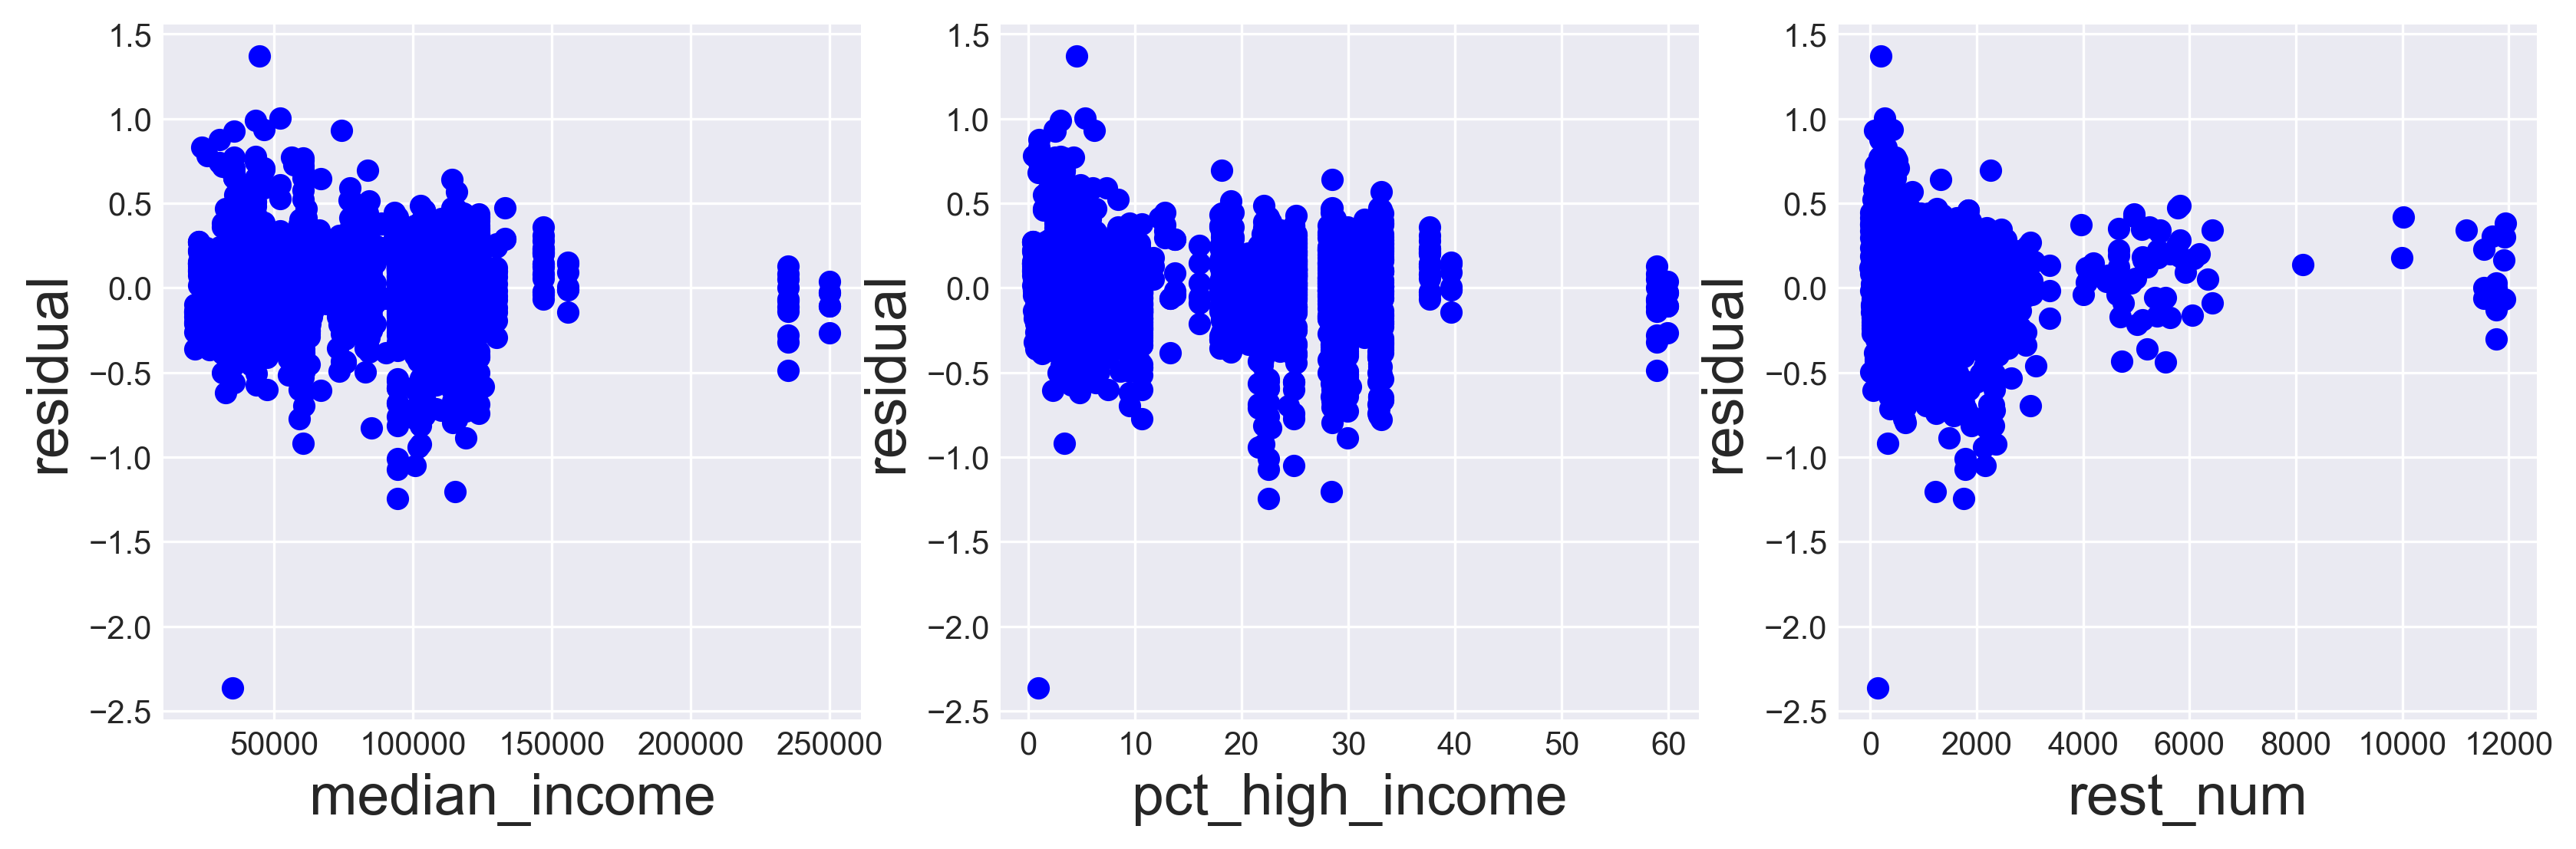

In [146]:
# another check of residuals on the non-normally distributed variables 
resids5 = fit5.predict(X_sm) - y_sm.price_log

plt.figure(figsize=(18, 4))
for var in log_vars:
    if var in list(X_sm.columns):
        plt.subplot(1, 4, log_vars.index(var)+1)
        plt.plot(X_sm[var],resids5, 'bo')
        plt.xlabel(var, size=18)
        plt.ylabel('residual', size = 18);

### Observations:
- It looks like the models is still missing when y_var values are very high, while residuals on high x_vars are normally distibuted around zero

### 1.6. Test log-transformed x-vars with log-stansformed dep var and top features

In [147]:
vars_to_be_log = []
for var in log_vars:
    if var in low_p_feat_log:
        vars_to_be_log.append(var)

In [148]:
vars_to_be_log

['median_income', 'pct_high_income', 'rest_num']

In [149]:
# Still check model results when log-transforming x_vars

def test_log_vars(variable_str):
    df_train = X_train[low_p_feat_log].copy()
    df_train['price_log'] = np.log(y_train)

    df_test = X_test[low_p_feat_log].copy()
    df_test['price_log'] = np.log(y_test)
    
    # log-transform var
    df_train[variable_str] = np.log(df_train[variable_str])
    df_test[variable_str] = np.log(df_test[variable_str])

    # create a string for patsy input
    low_p_feat_log_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat_log)

    # create feature matrix (X) and target vector (y)
    y_sm, X_sm = patsy.dmatrices(low_p_feat_log_str, data=df_train, return_type="dataframe")
    # create model
    model = sm.OLS(y_sm, X_sm)
    # fit model to training set
    fit6 = model.fit()
    
    lr = LinearRegression(fit_intercept=True,)
    lr.fit(df_train.drop('price_log', axis=1), df_train['price_log'])

    train_score = round(lr.score(df_train.drop('price_log', axis=1), df_train['price_log']),3)
    test_score = round(lr.score(df_test.drop('price_log', axis=1), df_test['price_log']),3)

    print('Logged var:', var)
    print('Train score:', train_score)
    print('Test score:', test_score)

In [150]:
for var in vars_to_be_log:
    test_log_vars(var)
    print('\n')

Logged var: median_income
Train score: 0.732
Test score: 0.72


Logged var: pct_high_income
Train score: 0.722
Test score: 0.706


Logged var: rest_num
Train score: 0.741
Test score: 0.734




### Observations:
- Compared to the model ran on non-transformed features only restaurant number transformation slightly improved R squared

### 1.7. Check summary stats with log-transformed restaurant number feature

In [151]:
# log-transform rest_num
# remove elementary school count since its p-val was > 0.05

df_train = X_train[low_p_feat_log].copy()
df_train['price_log'] = np.log(y_train)
df_train['rest_num'] = np.log(df_train['rest_num'])
df_train.drop('elementary_school_count', axis=1, inplace=True)

df_test = X_test[low_p_feat_log].copy()
df_test['price_log'] = np.log(y_test)
df_test['rest_num'] = np.log(df_test['rest_num'])
df_test.drop('elementary_school_count', axis=1, inplace=True)

# create a string for patsy input
low_p_feat_log.remove('elementary_school_count')
low_p_feat_log_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat_log)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_log_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit7 = model.fit()

fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     544.2
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:01:13   Log-Likelihood:                 710.26
No. Observations:                4389   AIC:                            -1373.
Df Residuals:                    4365   BIC:                            -1219.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.1496      0.072     85.429      0.000       6.008       6.291
high_school_count              0.0107      0.001     10.345      0.000       0.009       0.013
middle_school_count           -0.0039      0.001     -6.508      0.000      -0.005      -0.003
guarantor                     -0.0255      0.008     -3.299      0.001      -0.041      -0.010
storage                        0.0385      0.009      4.267      0.000       0.021       0.056
elevator                       0.0888      0.008     10.537      0.000       0.072       0.105
dishwasher                     0.0835      0.007     11.749      0.000       0.070       0.097
pets                           0.0420      0.007      5.675      0.000       0.028       0.057
fios_available                 0.0478      0.008      6.141      0.000       0.033       0.063
live_in_super                 -0.0362      0.008     -4.580      0.000      -0.052      -0.021
fitness_center                 0.1126      0.011      9.867      0.000       0.090       0.135
concierge                      0.0672      0.012      5.483      0.000       0.043       0.091
air_conditioning               0.0309      0.010      3.044      0.002       0.011       0.051
garden                         0.0608      0.012      5.207      0.000       0.038       0.084
terrace                        0.0678      0.013      5.025      0.000       0.041       0.094
pool                           0.0860      0.015      5.591      0.000       0.056       0.116
furnished                      0.0670      0.016      4.233      0.000       0.036       0.098
fireplace                      0.0719      0.017      4.333      0.000       0.039       0.104
median_income              -2.642e-06   3.91e-07     -6.750      0.000   -3.41e-06   -1.87e-06
pct_high_income                0.0184      0.001     15.667      0.000       0.016       0.021
demo_total_population       6.421e-07   1.71e-07      3.764      0.000    3.08e-07    9.77e-07
demo_pct_18_years_and_over     1.1942      0.096     12.476      0.000       1.007       1.382
rest_num                       0.0699      0.005     13.282      0.000       0.060       0.080
n_of_establishments        -1.371e-05   2.91e-06     -4.713      0.000   -1.94e-05   -8.01e-06
==============================================================================
Omnibus:                      880.840   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11026.174
Skew:                           0.590   Prob(JB):                         0.00
Kurtosis:                      10.675   Cond. No.                     3.63e+06
==============================================================================

Warnings:
[1] Standard Errors assume that t

Text(0,0.5,'Residiuals')

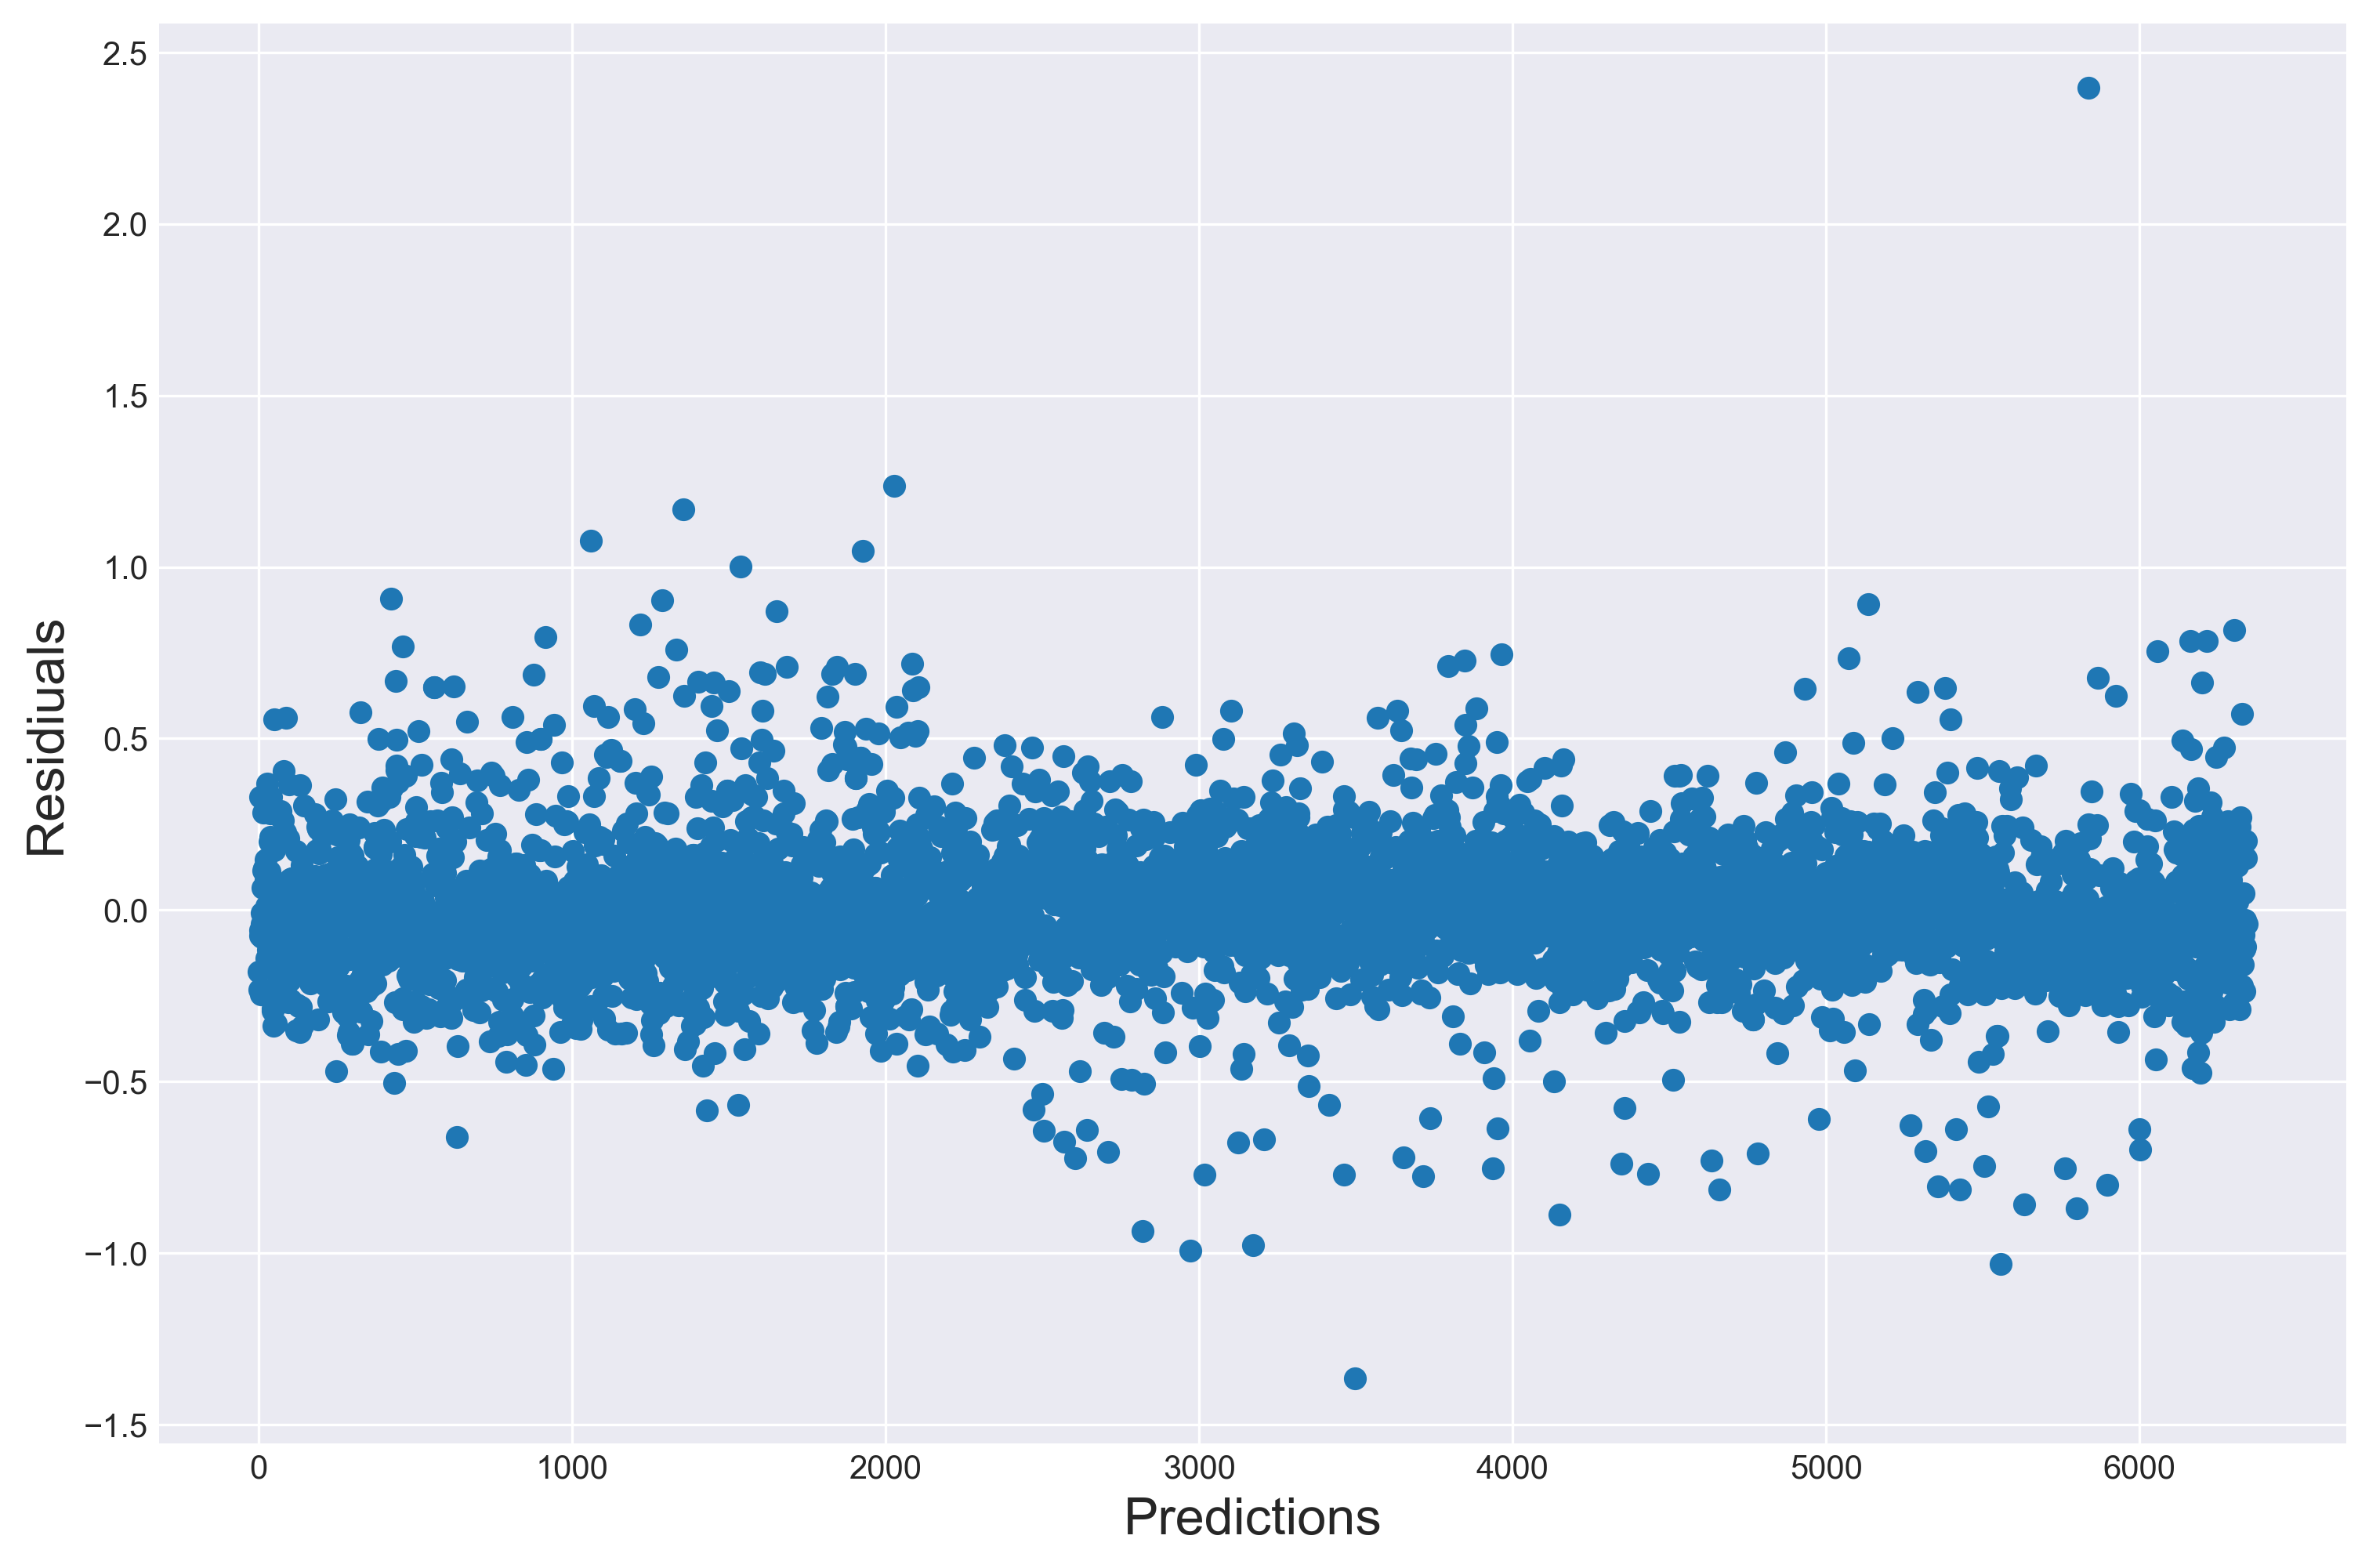

In [152]:
# Plot the residuals
fit7.resid.plot(style='o', figsize=(12,8))
plt.xlabel('Predictions', size = 16)
plt.ylabel('Residiuals', size = 16)

In [153]:
# get residuals
resids7 = fit7.predict(X_sm) - y_sm.price_log

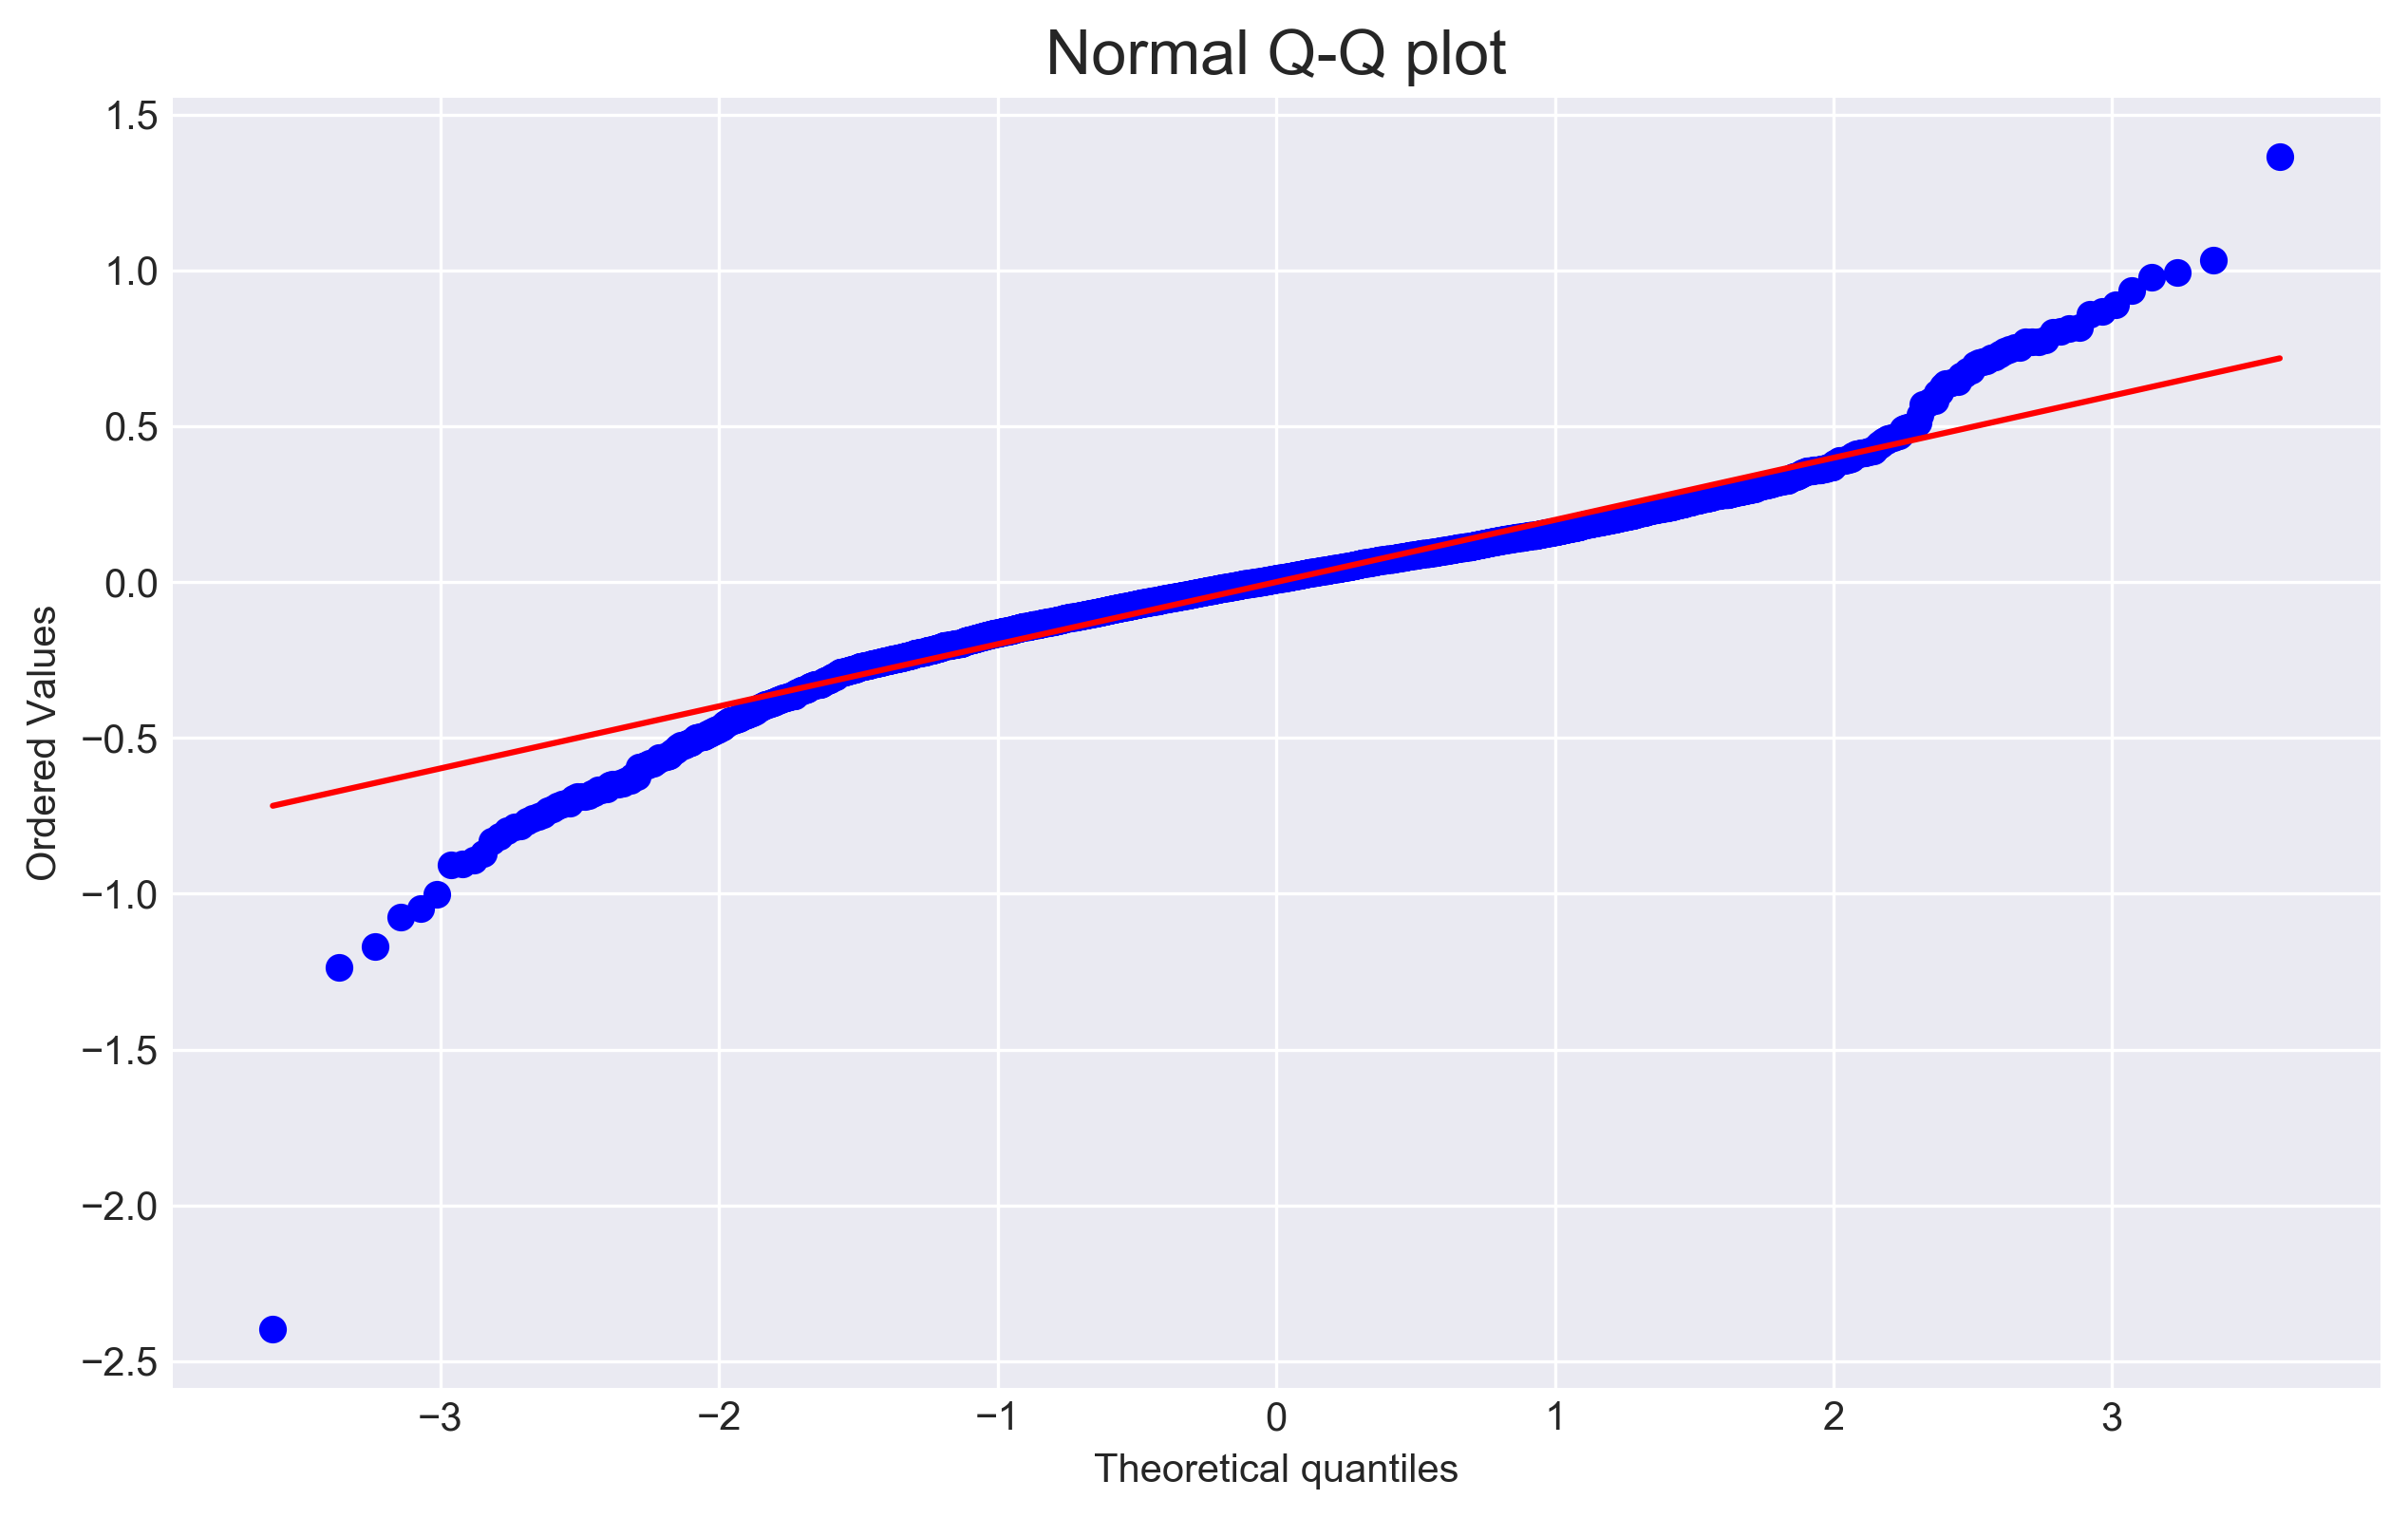

In [154]:
figsize(10,6)
stats.probplot(resids7, dist="norm", plot=plt)
plt.title("Normal Q-Q plot", size=16)
plt.xticks(size=10)
plt.yticks(size=10);

In [155]:
from sklearn.metrics import r2_score

In [156]:
x_train_fit7 = df_train.drop('price_log', axis=1)
x_test_fit7 = df_test.drop('price_log', axis=1)

lr = LinearRegression(fit_intercept=True,)
lr.fit(x_train_fit7, df_train['price_log'])

print('Train: ', round(lr.score(x_train_fit7, df_train['price_log']),3))
print('Test: ', round(lr.score(x_test_fit7, df_test['price_log']),3))

Train:  0.741
Test:  0.734


### Check model performance on exponentiated dep var

In [157]:
print('Train: ',  round(r2_score(y_train, np.exp(lr.predict(x_train_fit7))), 3))
print('Test: ', round(r2_score(y_test, np.exp(lr.predict(x_test_fit7))), 3))

Train:  0.624
Test:  0.58


#### Compare with:

In [158]:
print('Non-transformed dep-var train score: ', best_non_log_train)
print('Non-transformed dep-var test score: ', best_non_log_test)

Non-transformed dep-var train score:  0.618
Non-transformed dep-var test score:  0.579


# 2. Moving to Sklearn

In [159]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing

In [5]:
df_sklearn = df.select_dtypes(["float64", "int64"]).copy()
df_sklearn.head()

days_on_trulia  elementary_school_count  high_school_count  \
0               2                       42                 12   
1               2                       42                 11   
2              14                       42                 16   
3               2                       40                 13   
4              14                       27                  6   

   middle_school_count  pets_allowed  price  zip_code  guarantor  storage  \
0                   22             1   3795     10018          0        1   
1                   22             1   1950     10036          1        0   
2                   19             0   4550     10011          1        0   
3                   17             0   5350     10012          0        0   
4                   15             0   2475     10025          0        0   

   garage         ...           demo_pct_two_or_more_races  demo_pct_white  \
0       0         ...                             0.039550        0.591078   
1       0         ...                             0.020125        0.642167   
2       0         ...                             0.029680        0.794004   
3       0         ...                             0.038882        0.756643   
4       0         ...                             0.041946        0.659955   

   demo_pct_black_or_african_american  \
0                            0.054936   
1                            0.074845   
2                            0.045889   
3                            0.026125   
4                            0.121467   

   demo_pct_american_indian_and_alaska_native  demo_pct_asian  \
0                                    0.000000        0.293474   
1                                    0.004579        0.192712   
2                                    0.001270        0.101004   
3                                    0.001549        0.161355   
4                                    0.008341        0.091821   

   demo_pct_native_hawaiian_and_other_pacific_islander  \
0                                           0.000000     
1                                           0.000000     
2                                           0.000079     
3                                           0.000489     
4                                           0.000232     

   demo_pct_some_other_race  demo_pct_hispanic_or_latino_(of_any_race)  \
0                  0.020962                                   0.165118   
1                  0.065571                                   0.177435   
2                  0.028073                                   0.109456   
3                  0.014958                                   0.058730   
4                  0.076238                                   0.227076   

   rest_num  n_of_establishments  
0      2879                 6723  
1      1783                 6131  
2      2131                 4002  
3      2328                 2972  
4       418                 2027  

[5 rows x 74 columns]

In [6]:
x = df_sklearn.drop(columns=["price", "zip_code"]).copy()
y = df_sklearn["price"]

In [7]:
len(x.columns)

72

### 2.1. KBest

In [163]:
select_pipe = pipeline.Pipeline(
    [("std", preprocessing.StandardScaler()),
     ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression)), 
     ("lin", linear_model.LinearRegression())
])

In [164]:
cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=10, return_train_score=True)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")

train: 0.564, test: 0.482


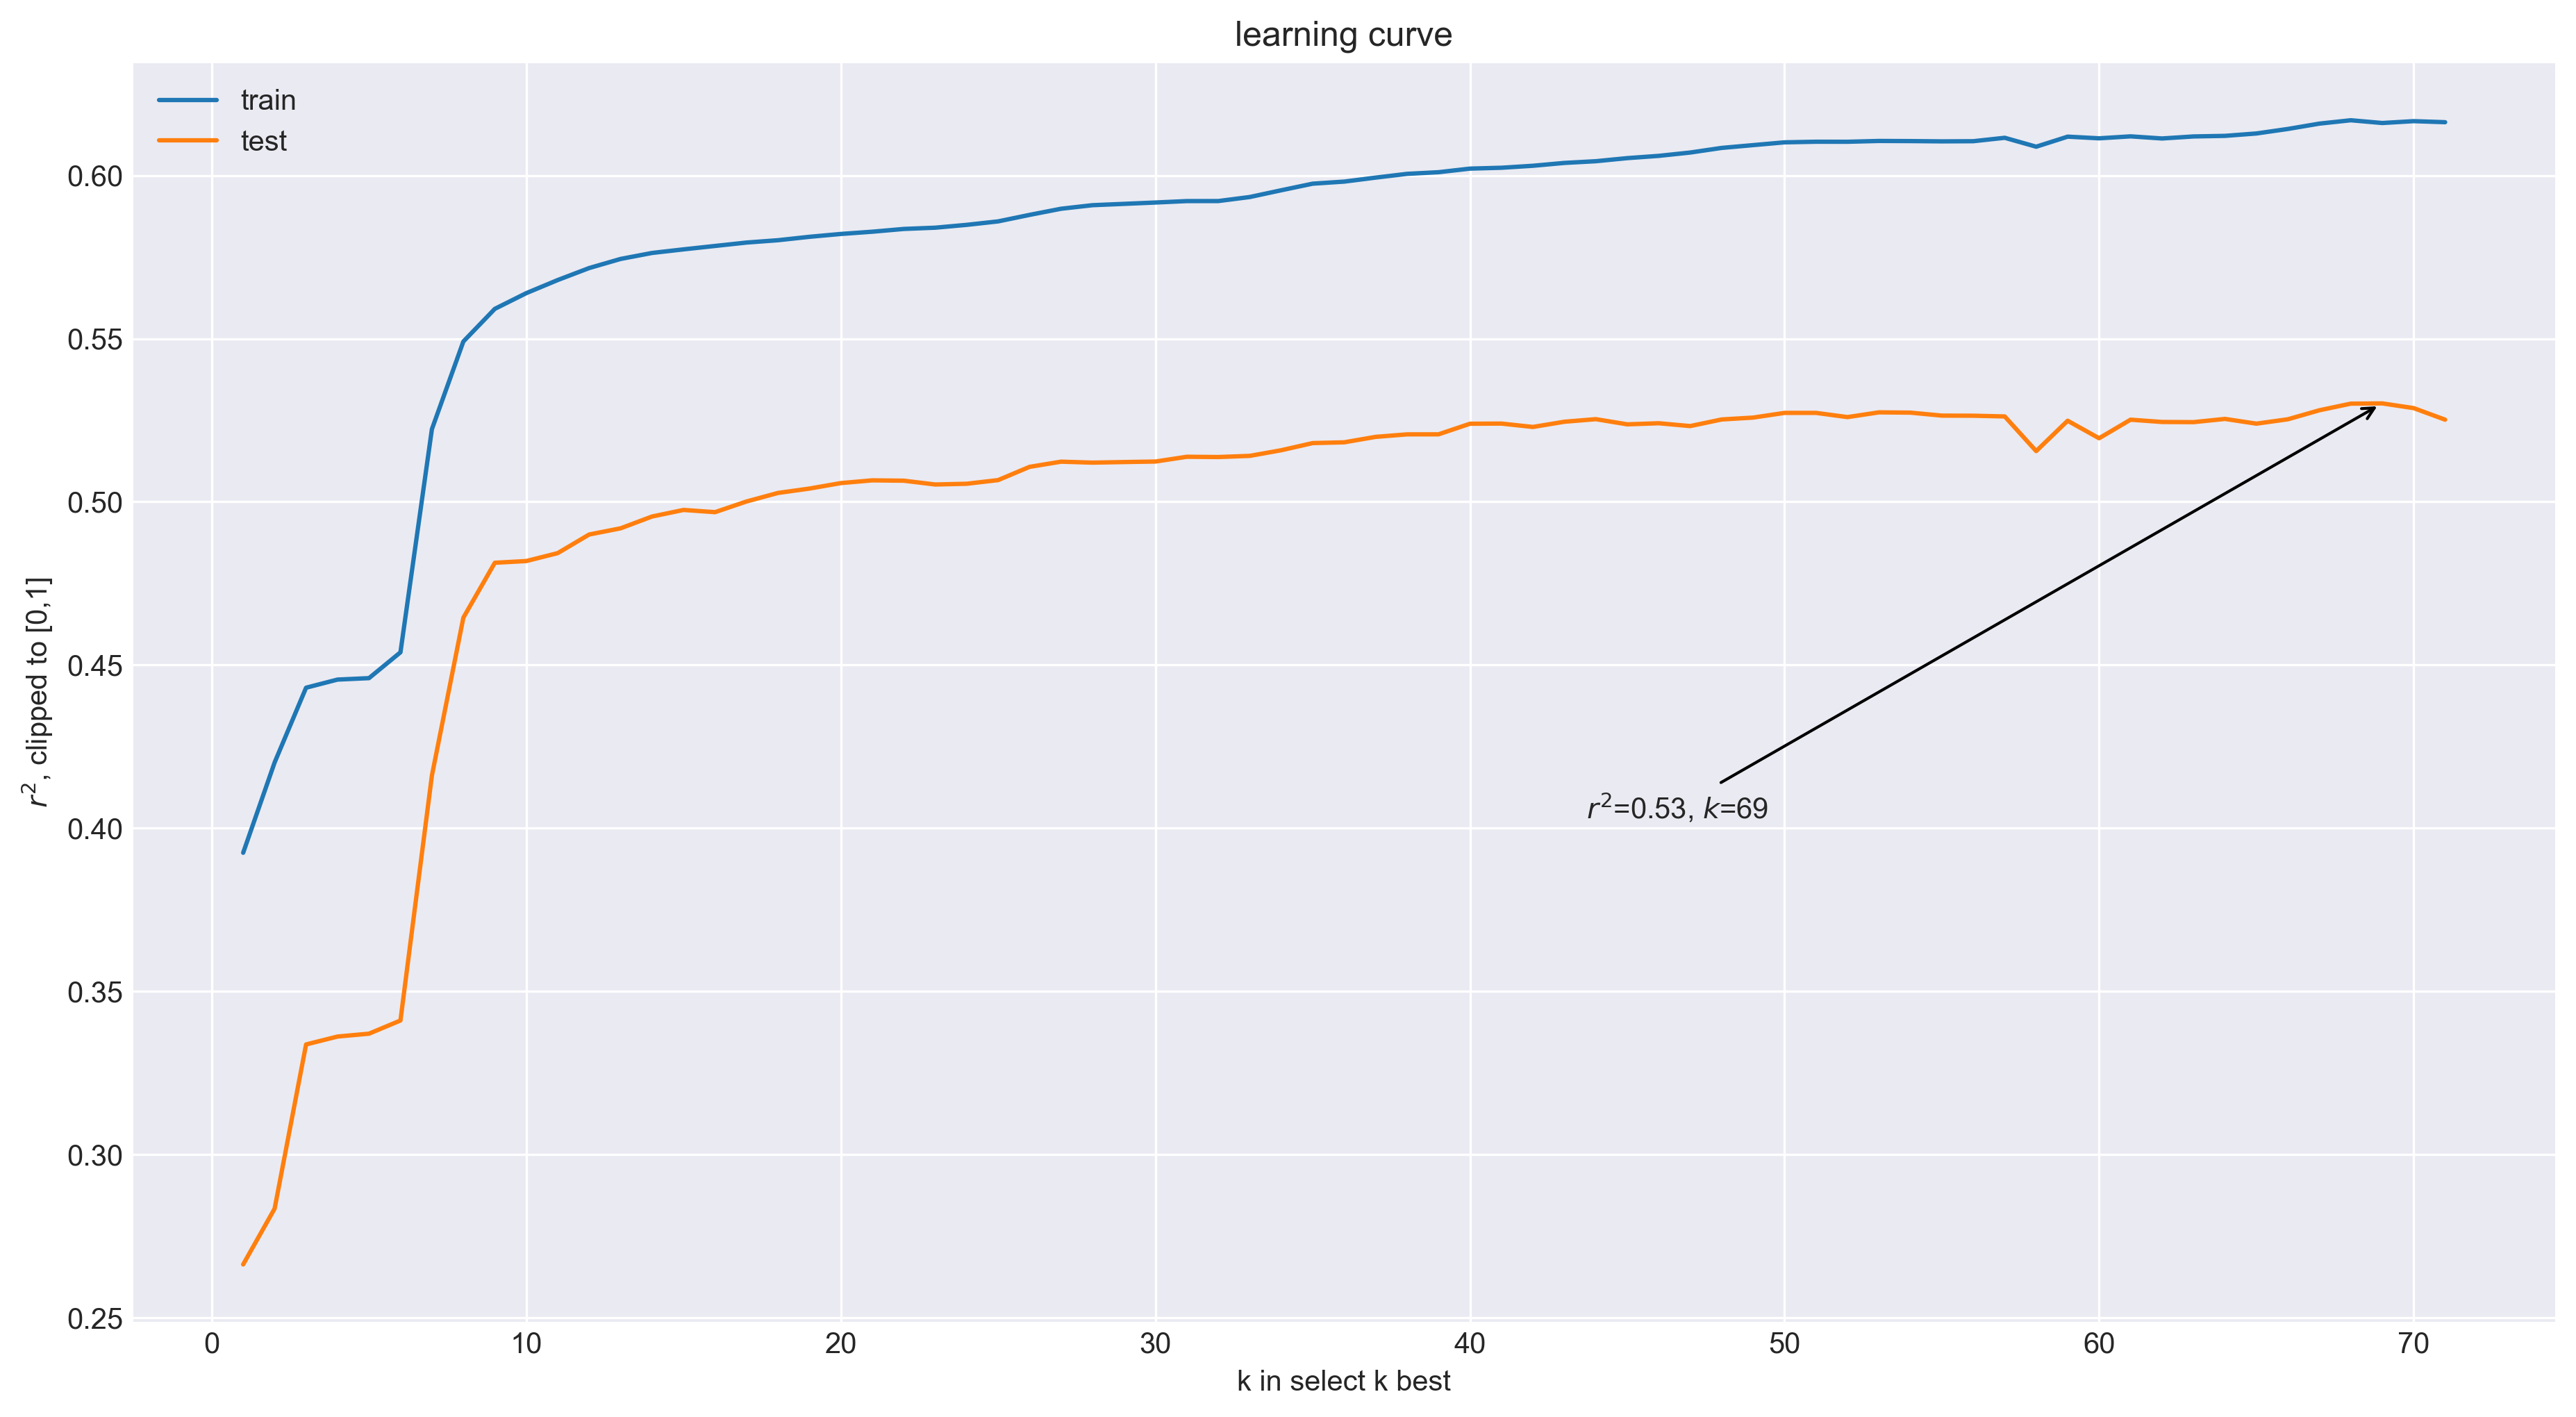

In [165]:
figsize(15, 8)


train_scores = []
test_scores = []
# define feature range
num_feats = len(x.columns)
feat_range = np.arange(num_feats)+1
# for each k in feat_range
for num_f in feat_range:
    # set pipeline params
    select_pipe.set_params(select__k=num_f)
    # get cross val scores
    cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

# plot test vs train
plot(feat_range, train_scores, label="train")
plot(feat_range, test_scores, label="test")

# find index of best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )

xlabel("k in select k best")
ylabel("$r^2$, clipped to [0,1]")
title("learning curve")
legend();

### 2.2. Ridge

In [166]:
ridge_pipe = pipeline.Pipeline([
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [167]:
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,y)

In [168]:
alphas = np.logspace(.1, 10, num=100)
coefs = []
train_scores = []
test_scores = []


for i, alpha in enumerate(alphas):
    ridge_pipe.set_params(ridge__alpha=alpha)
    cv_result = model_selection.cross_validate(
        ridge_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    
    ridge_pipe.fit(x_train, y_train)
    coefs.append(ridge_pipe.named_steps["ridge"].coef_)

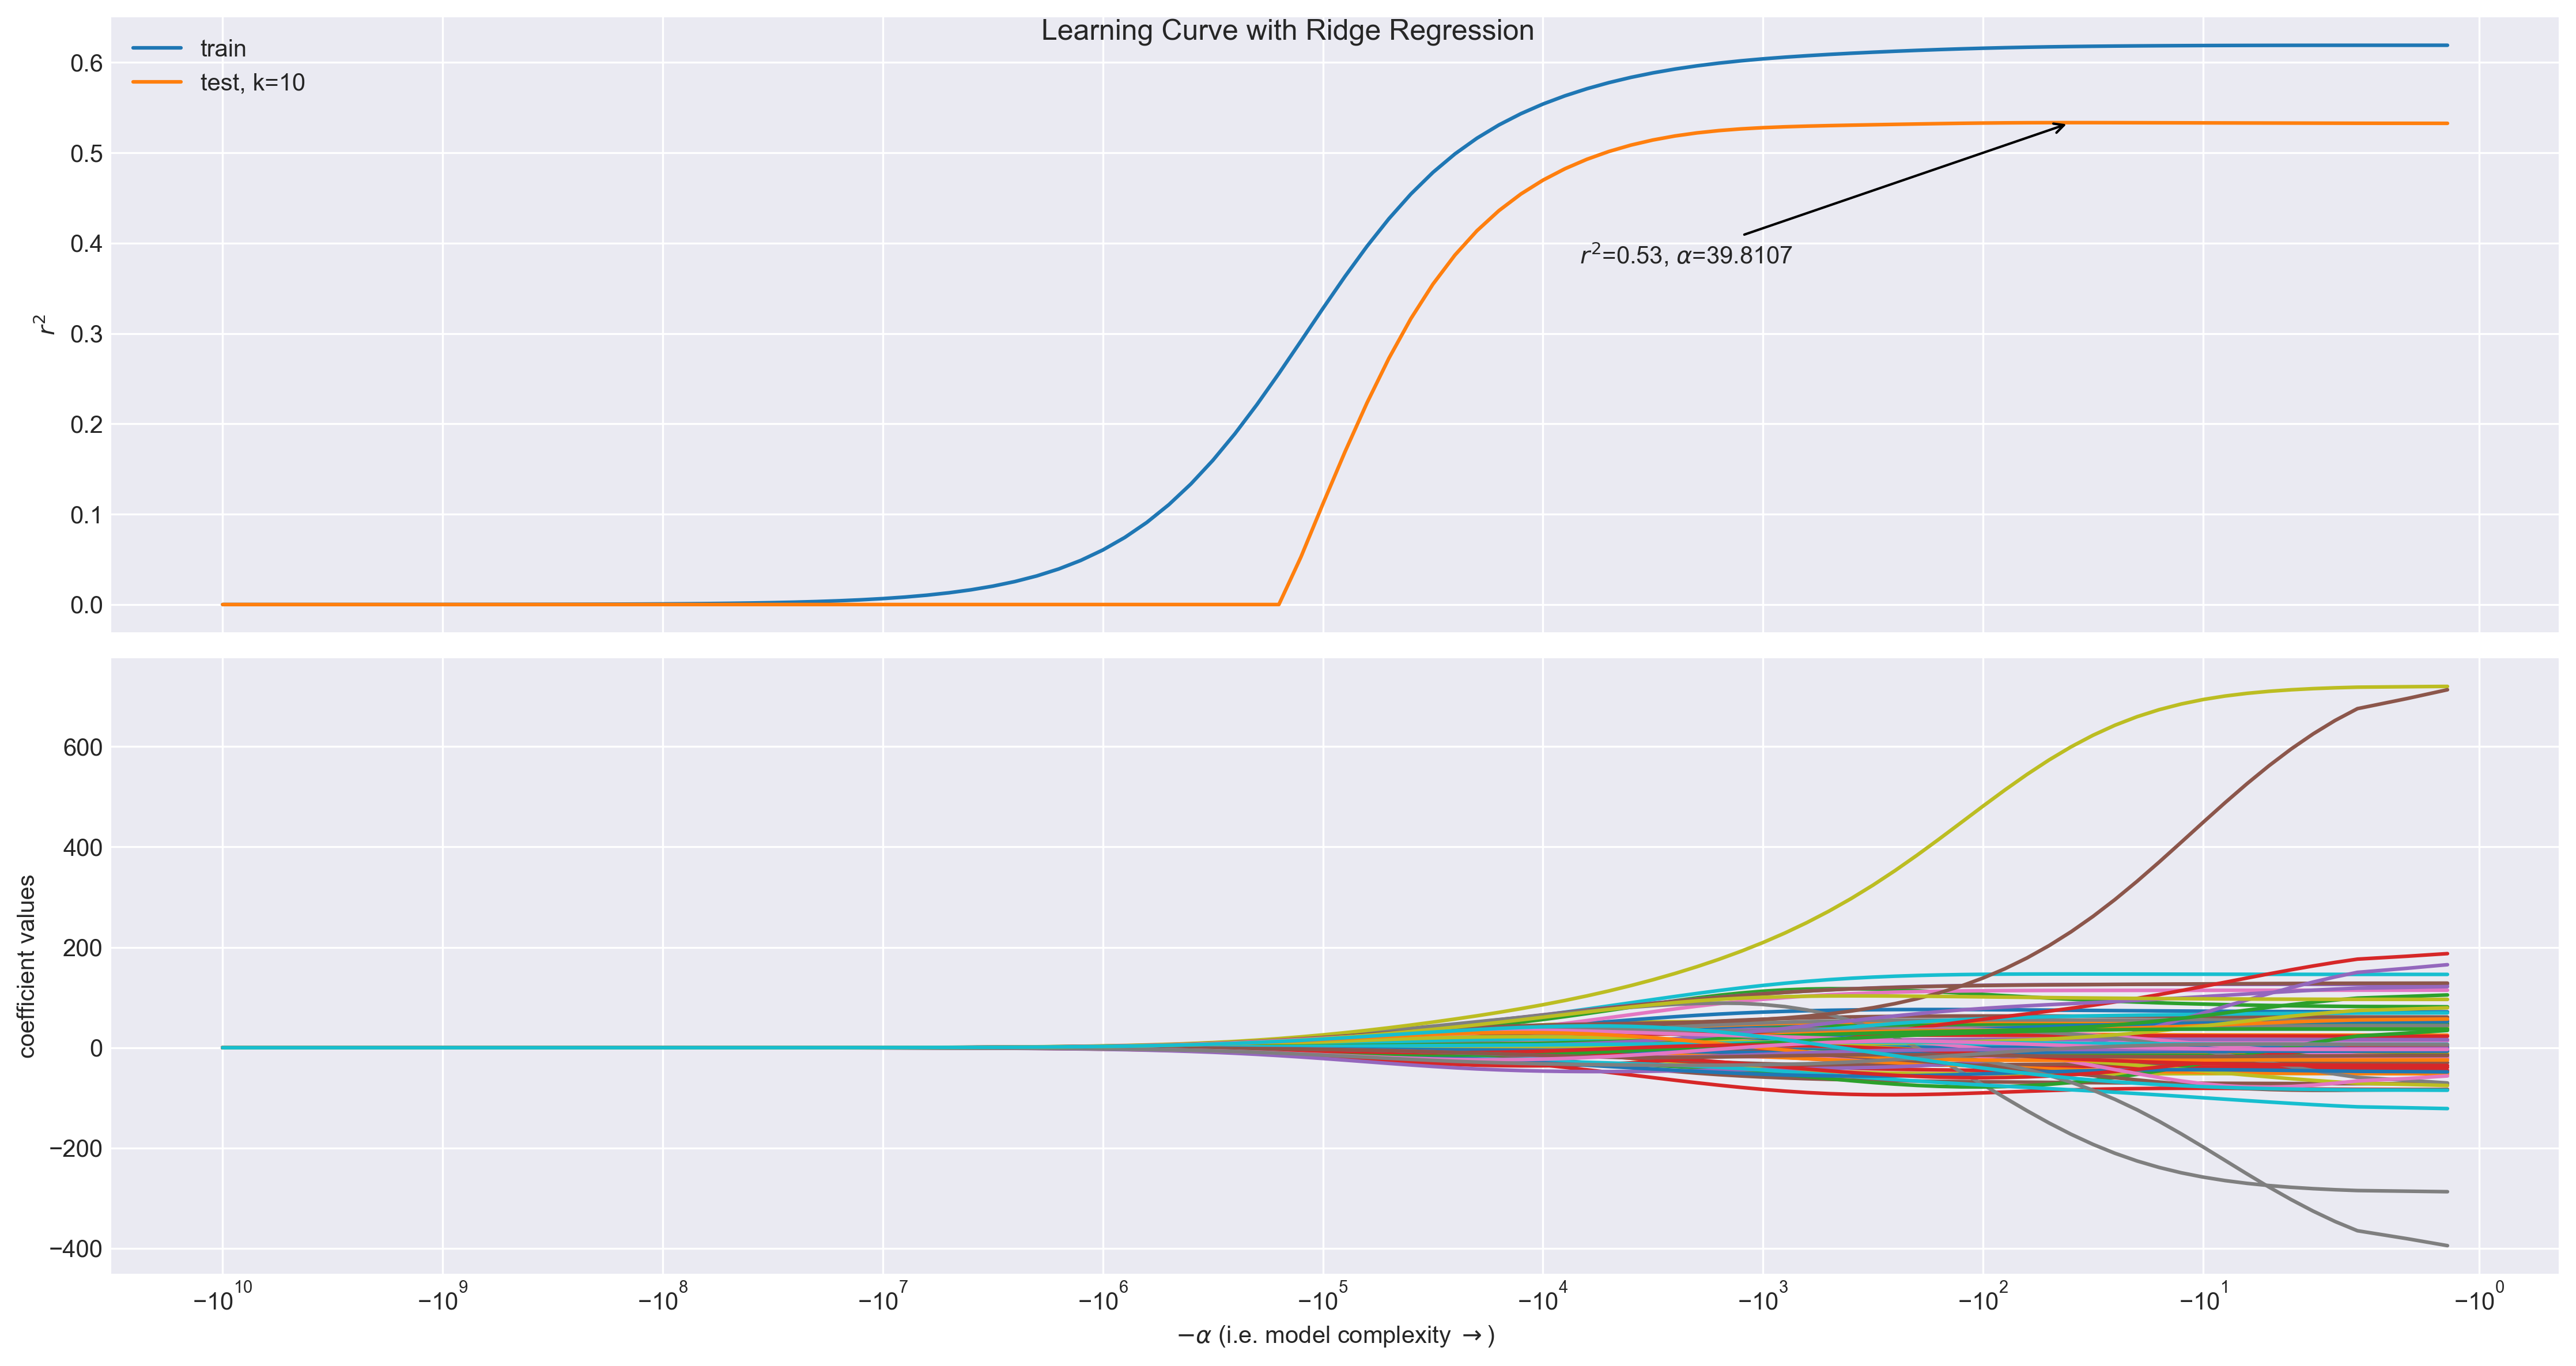

In [169]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
coef_arr = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
best_i = np.argmax(test_scores)
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")
plt.savefig("trulia_ridge.pdf")

### 2.3. Lasso

In [170]:
lasso_pipe = pipeline.Pipeline([
     ("imp", preprocessing.Imputer()), 
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("lasso", linear_model.Lasso())
    ])

In [171]:
alphas = np.logspace(.1, 10, num=100)
coefs = []
train_scores = []
test_scores = []

for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = model_selection.cross_validate(
        lasso_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

    lasso_pipe.fit(x_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)

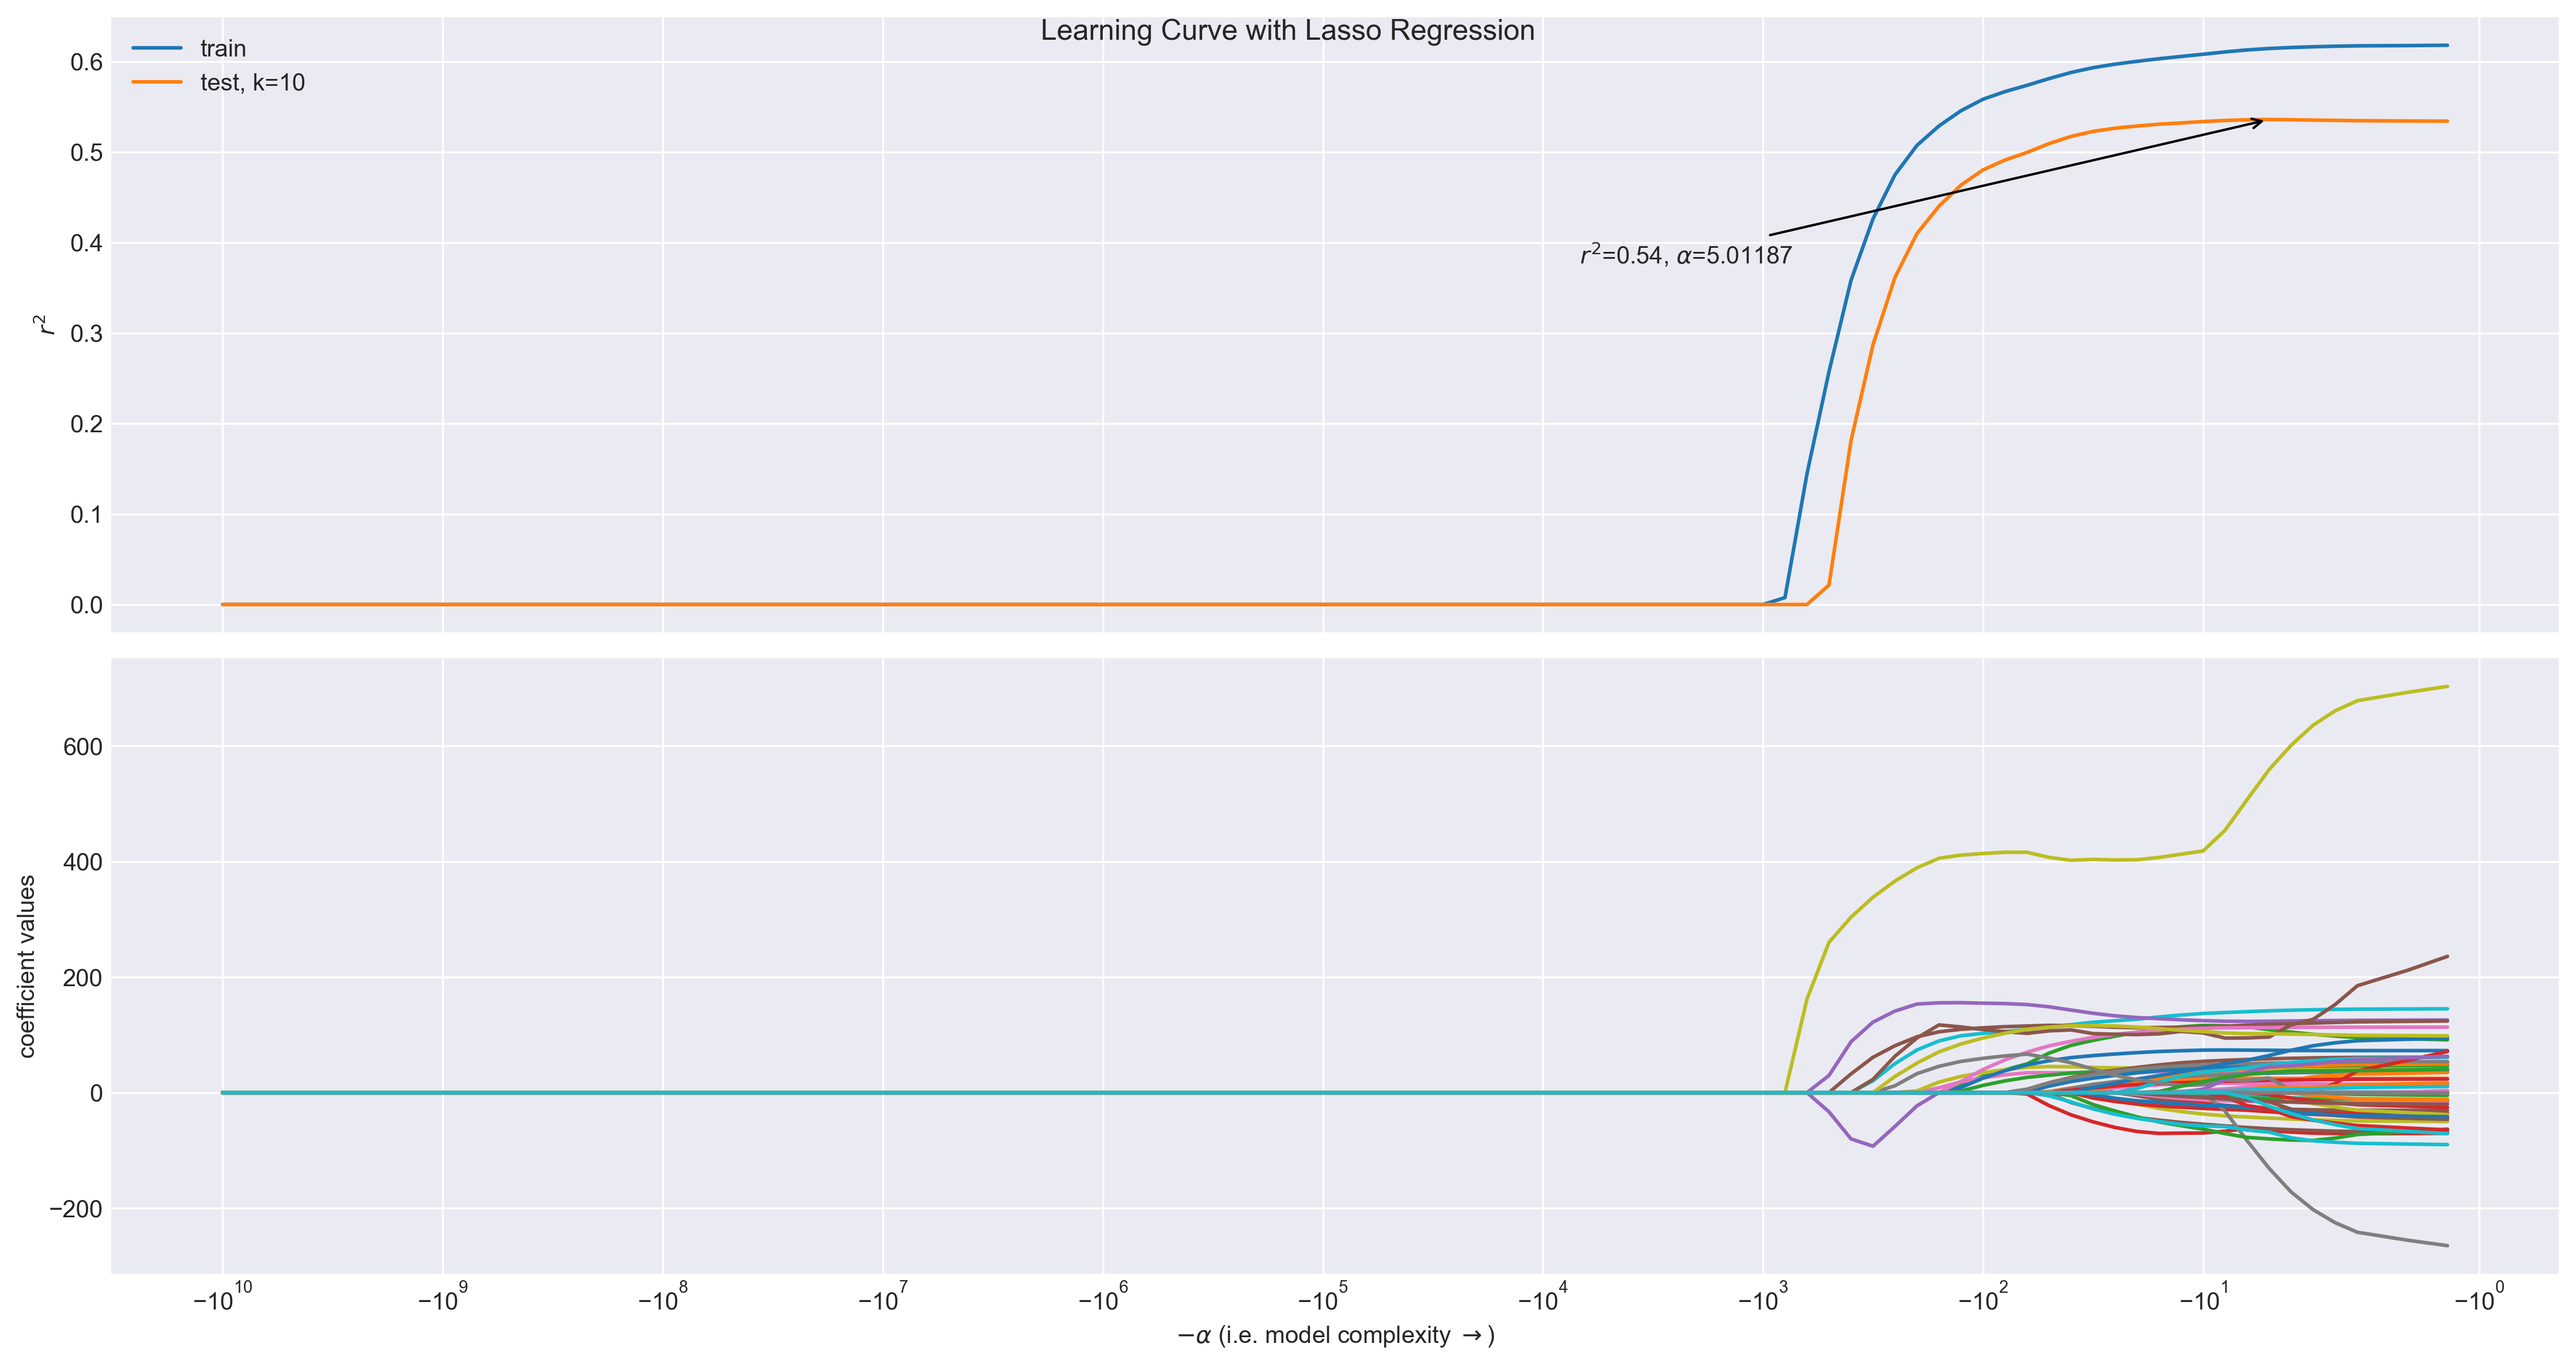

In [172]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
coef_arr = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
best_i = np.argmax(test_scores)
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Lasso Regression")
plt.xscale("symlog")
plt.savefig("trulia_lasso.pdf")

In [173]:
var_support = lasso_pipe.named_steps["var"].get_support()
feat = x.columns[var_support]
coef = coefs[best_i]
sort_i = argsort(-np.abs(coef))

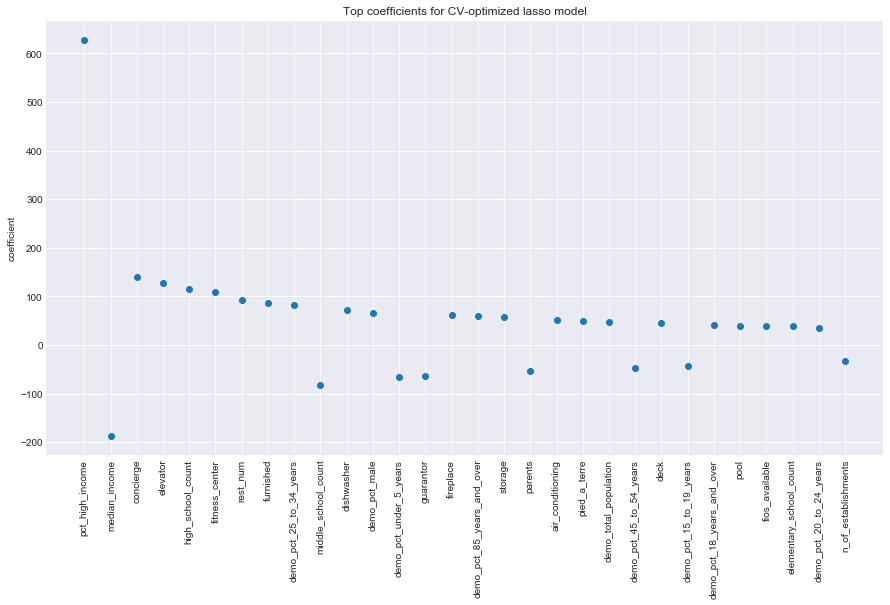

In [87]:
figsize(15,8)
n_plot = 30
ind = np.arange(n_plot)

scatter(ind, coef[sort_i][:n_plot])
plt.xticks(ind, feat[sort_i][:n_plot], rotation=90);
plt.title("Top coefficients for CV-optimized lasso model")
plt.ylabel("coefficient");